In [720]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats.distributions import chi2 
from math import sqrt
import plotly.graph_objects as go
import warnings
import scipy.stats as stats
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("ETH.csv", parse_dates = ["Fecha"], dayfirst = True)
data.head()

,Fecha,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
0,2020-09-02,441.28,476.19,476.19,441.28,227.34K,-7.33%
1,2020-09-01,476.19,434.61,485.45,433.07,200.85K,9.57%
2,2020-08-31,434.61,429.93,436.74,423.19,65.73K,1.09%
3,2020-08-30,429.93,399.29,429.93,399.29,75.80K,7.67%
4,2020-08-29,399.29,395.94,405.77,393.80,50.94K,0.85%


In [3]:
# Dropping commas
data['Cierre']=data['Cierre'].str.replace(',','')
data['Apertura']=data['Apertura'].str.replace(',','')
data['Máximo']=data['Máximo'].str.replace(',','')
data['Mínimo']=data['Mínimo'].str.replace(',','')
# Delitting 'K' & '%' from Vol. and % var fields, respectively.
data['Vol.'] = data['Vol.'].map(lambda x: x.rstrip('Kk'))
data['% var.'] = data['% var.'].map(lambda x: x.rstrip('%'))
# Convert fields except "Fecha" in float fields
cols = data.columns.drop('Fecha')
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')
# Updating Vol. and % var fields with the real value
data['Vol.'] = data['Vol.'].apply(lambda x: x*1000)
data['% var.'] = data['% var.'].apply(lambda x: x/100)

In [4]:
data.head()

,Fecha,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
0,2020-09-02,441.28,476.19,476.19,441.28,227340.0,-0.0733
1,2020-09-01,476.19,434.61,485.45,433.07,200850.0,0.0957
2,2020-08-31,434.61,429.93,436.74,423.19,65730.0,0.0109
3,2020-08-30,429.93,399.29,429.93,399.29,75800.0,0.0767
4,2020-08-29,399.29,395.94,405.77,393.80,50940.0,0.0085


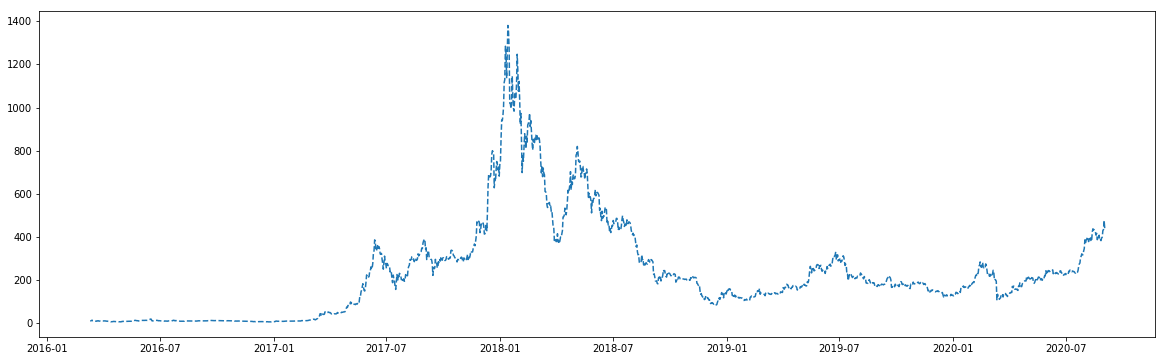

In [5]:
plt.figure(figsize=(20,6))
plt.plot(data.Fecha, data.Cierre, '--')
plt.show()

In [6]:
## Functions

def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

# create a N-order differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    history = list(history)
    n = len(yhat)
    if len(yhat) == 1:
        value = yhat[i] + history[-interval]
        history.append(value)
    else:
        value = yhat[0] + history[-interval]
        history.append(value)
        
        for i in range(1, n):
            value = yhat[i] + history[-interval]
            history.append(value)
    return np.array(history[-n:])

In [7]:
df_comp = data.copy()
df_comp.set_index("Fecha", inplace=True)
df_comp=df_comp.sort_index().asfreq('D')
df_comp.head()

,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
Fecha,,,,,,
2016-03-10,11.75,11.20,11.85,11.07,0.0,0.0491
2016-03-11,11.95,11.75,11.95,11.75,50.0,0.0170
2016-03-12,12.92,11.95,13.45,11.95,240.0,0.0812
2016-03-13,15.07,12.92,15.07,12.92,370.0,0.1664
2016-03-14,12.50,15.07,15.07,11.40,26340.0,-0.1705


In [145]:
# Splitting data in training and testing
size = int(len(df_comp)*0.9)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

In [68]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.Cierre)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

There isn't enough proves to reject that data isn't stationary with a 0.99% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.95% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.90% of confidence


## Trasnforming non-stationary data into stationary data

In [146]:
x = df.Cierre.values

# Regarding 1 ordered differenced time serie
differenced = difference(x, 1)

In [71]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(differenced)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


In [155]:
# Let's take a quick look
differenced

array([  0.2 ,   0.97,   2.15, ...,  -3.06,  -0.6 , -10.35])

In [73]:
print(len(df.Cierre))
print(len(differenced))

1474
1473


## Model

### Fitting an ARMA(1,1), in order to look for the best model

In [74]:
## ARIMA(1,0,1)

model_ar_1_i_0_ma_1 = ARIMA(differenced, order=(1,0,1))
results_ar_1_i_0_ma_1 = model_ar_1_i_0_ma_1.fit()
results_ar_1_i_0_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(1, 1)   Log Likelihood               -6601.147
Method:                       css-mle   S.D. of innovations             21.380
Date:                Tue, 06 Oct 2020   AIC                          13210.294
Time:                        15:04:46   BIC                          13231.475
Sample:                             0   HQIC                         13218.192
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0740      0.568      0.130      0.896      -1.039       1.187
ar.L1.y       -0.8875      0.050    -17.820      0.000      -0.985      -0.790
ma.L1.y        0.9242      0.041     22.514      0.000       0.844       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1267           +0.0000j            1.1267            0.5000
MA.1           -1.0820           +0.0000j            1.0820            0.5000
-----------------------------------------------------------------------------
"""

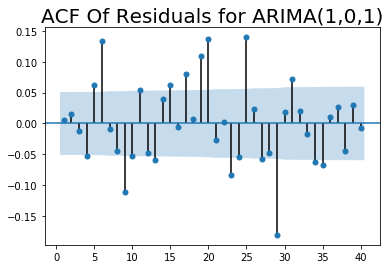

In [89]:
## Residuals of the ARIMA(1,0,1)

df['res_ar_1_i_0_ma_1'] = np.concatenate([0,results_ar_1_i_0_ma_1.resid], axis=None)
sgt.plot_acf(df.res_ar_1_i_0_ma_1[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,0,1)",size=20)
plt.show()

The resiudal plot suggest to train an ARMA with $p$=6 y/o $q$=6. Also we could look for a higer number(9). Nonetheless, this could not necessary be that could obtain a better performance due to time variable so we will try with a lesser value.

## Training with original data

In [105]:
model_ar_6_i_0_ma_6 = ARIMA(df.Cierre, order=(6,0,6))
results_ar_6_i_0_ma_6 = model_ar_6_i_0_ma_6.fit()

model_ar_6_i_0_ma_5 = ARIMA(df.Cierre, order=(6,0,5))
results_ar_6_i_0_ma_5 = model_ar_6_i_0_ma_5.fit()

model_ar_5_i_0_ma_6 = ARIMA(df.Cierre, order=(5,0,6))
results_ar_5_i_0_ma_6 = model_ar_5_i_0_ma_6.fit()

model_ar_6_i_1_ma_4 = ARIMA(df.Cierre, order=(6,1,4))
results_ar_6_i_1_ma_4 = model_ar_6_i_1_ma_4.fit()

model_ar_4_i_1_ma_6 = ARIMA(df.Cierre, order=(4,1,6))
results_ar_4_i_1_ma_6 = model_ar_4_i_1_ma_6.fit()

model_ar_6_i_0_ma_3 = ARIMA(df.Cierre, order=(6,0,3))
results_ar_6_i_0_ma_3 = model_ar_6_i_0_ma_3.fit()

model_ar_3_i_0_ma_6 = ARIMA(df.Cierre, order=(3,0,6))
results_ar_3_i_0_ma_6 = model_ar_3_i_0_ma_6.fit()

model_ar_6_i_0_ma_2 = ARIMA(df.Cierre, order=(6,0,2))
results_ar_6_i_0_ma_2 = model_ar_6_i_0_ma_2.fit()

model_ar_2_i_0_ma_6 = ARIMA(df.Cierre, order=(2,0,6))
results_ar_2_i_0_ma_6 = model_ar_2_i_0_ma_6.fit()

model_ar_6_i_0_ma_1 = ARIMA(df.Cierre, order=(6,0,1))
results_ar_6_i_0_ma_1 = model_ar_6_i_0_ma_1.fit()

model_ar_1_i_0_ma_6 = ARIMA(df.Cierre, order=(1,0,6))
results_ar_1_i_0_ma_6 = model_ar_1_i_0_ma_6.fit()

In [106]:
results_ar_6_i_0_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(6, 6)   Log Likelihood               -6550.239
Method:                       css-mle   S.D. of innovations             20.548
Date:                Tue, 06 Oct 2020   AIC                          13128.477
Time:                        15:28:53   BIC                          13202.618
Sample:                    03-10-2016   HQIC                         13156.121
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          231.7290    113.096      2.049      0.040      10.066     453.392
ar.L1.Cierre     2.8240      0.058     48.421      0.000       2.710       2.938
ar.L2.Cierre    -3.5032      0.158    -22.204      0.000      -3.812      -3.194
ar.L3.Cierre     2.5139      0.213     11.801      0.000       2.096       2.931
ar.L4.Cierre    -0.8855      0.216     -4.101      0.000      -1.309      -0.462
ar.L5.Cierre    -0.2196      0.155     -1.414      0.157      -0.524       0.085
ar.L6.Cierre     0.2689      0.054      5.018      0.000       0.164       0.374
ma.L1.Cierre    -1.8241      0.062    -29.203      0.000      -1.947      -1.702
ma.L2.Cierre     1.6776      0.112     15.045      0.000       1.459       1.896
ma.L3.Cierre    -0.8037      0.134     -6.016      0.000      -1.066      -0.542
ma.L4.Cierre    -0.0930      0.119     -0.778      0.437      -0.327       0.141
ma.L5.Cierre     0.5614      0.069      8.121      0.000       0.426       0.697
ma.L6.Cierre    -0.1643      0.031     -5.237      0.000      -0.226      -0.103
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2988           -1.0947j            1.1348           -0.2076
AR.2            0.2988           +1.0947j            1.1348            0.2076
AR.3           -2.6634           -0.0000j            2.6634           -0.5000
AR.4            0.9390           -0.4445j            1.0390           -0.0704
AR.5            0.9390           +0.4445j            1.0390            0.0704
AR.6            1.0044           -0.0000j            1.0044           -0.0000
MA.1            0.9026           -0.4683j            1.0169           -0.0762
MA.2            0.9026           +0.4683j            1.0169            0.0762
MA.3            0.1899           -1.0662j            1.0830           -0.2220
MA.4            0.1899           +1.0662j            1.0830            0.2220
MA.5           -1.7073           -0.0000j            1.7073           -0.5000
MA.6            2.9390           -0.0000j            2.9390           -0.0000
-----------------------------------------------------------------------------
"""

In [107]:
results_ar_6_i_0_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(6, 5)   Log Likelihood               -6558.648
Method:                       css-mle   S.D. of innovations             20.667
Date:                Tue, 06 Oct 2020   AIC                          13143.296
Time:                        15:28:56   BIC                          13212.141
Sample:                    03-10-2016   HQIC                         13168.966
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          231.7284     99.080      2.339      0.019      37.535     425.922
ar.L1.Cierre     2.1932      0.058     37.594      0.000       2.079       2.308
ar.L2.Cierre    -1.7424      0.156    -11.147      0.000      -2.049      -1.436
ar.L3.Cierre     0.1867      0.219      0.853      0.394      -0.242       0.616
ar.L4.Cierre     1.1936      0.214      5.577      0.000       0.774       1.613
ar.L5.Cierre    -1.5072      0.148    -10.150      0.000      -1.798      -1.216
ar.L6.Cierre     0.6726      0.055     12.287      0.000       0.565       0.780
ma.L1.Cierre    -1.1458      0.047    -24.180      0.000      -1.239      -1.053
ma.L2.Cierre     0.5365      0.087      6.184      0.000       0.366       0.707
ma.L3.Cierre     0.3698      0.101      3.665      0.000       0.172       0.568
ma.L4.Cierre    -0.8866      0.082    -10.824      0.000      -1.047      -0.726
ma.L5.Cierre     0.8189      0.045     18.397      0.000       0.732       0.906
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1222           -0.0000j            1.1222           -0.5000
AR.2            0.2331           -1.0614j            1.0867           -0.2156
AR.3            0.2331           +1.0614j            1.0867            0.2156
AR.4            0.9452           -0.4705j            1.0558           -0.0735
AR.5            0.9452           +0.4705j            1.0558            0.0735
AR.6            1.0063           -0.0000j            1.0063           -0.0000
MA.1           -1.0786           -0.0000j            1.0786           -0.5000
MA.2            0.1819           -1.0312j            1.0472           -0.2222
MA.3            0.1819           +1.0312j            1.0472            0.2222
MA.4            0.8988           -0.4739j            1.0161           -0.0772
MA.5            0.8988           +0.4739j            1.0161            0.0772
-----------------------------------------------------------------------------
"""

In [108]:
results_ar_5_i_0_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(5, 6)   Log Likelihood               -6569.957
Method:                       css-mle   S.D. of innovations             20.832
Date:                Tue, 06 Oct 2020   AIC                          13165.913
Time:                        15:28:58   BIC                          13234.758
Sample:                    03-10-2016   HQIC                         13191.583
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          201.1425    100.988      1.992      0.046       3.210     399.075
ar.L1.Cierre     1.0512      0.128      8.208      0.000       0.800       1.302
ar.L2.Cierre    -0.1350      0.148     -0.914      0.361      -0.425       0.155
ar.L3.Cierre    -0.4719      0.112     -4.222      0.000      -0.691      -0.253
ar.L4.Cierre     0.8760      0.092      9.556      0.000       0.696       1.056
ar.L5.Cierre    -0.3276      0.085     -3.840      0.000      -0.495      -0.160
ma.L1.Cierre    -0.0261      0.128     -0.204      0.838      -0.276       0.224
ma.L2.Cierre     0.0962      0.083      1.162      0.245      -0.066       0.258
ma.L3.Cierre     0.6043      0.074      8.180      0.000       0.459       0.749
ma.L4.Cierre    -0.4046      0.082     -4.936      0.000      -0.565      -0.244
ma.L5.Cierre     0.0862      0.034      2.561      0.010       0.020       0.152
ma.L6.Cierre     0.1504      0.038      4.009      0.000       0.077       0.224
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0836           -0.0000j            1.0836           -0.5000
AR.2            0.3360           -1.1107j            1.1604           -0.2032
AR.3            0.3360           +1.1107j            1.1604            0.2032
AR.4            1.0060           -0.0000j            1.0060           -0.0000
AR.5            2.0794           -0.0000j            2.0794           -0.0000
MA.1            0.1863           -1.0833j            1.0992           -0.2229
MA.2            0.1863           +1.0833j            1.0992            0.2229
MA.3            1.2184           -0.8656j            1.4946           -0.0983
MA.4            1.2184           +0.8656j            1.4946            0.0983
MA.5           -1.0610           -0.0000j            1.0610           -0.5000
MA.6           -2.3217           -0.0000j            2.3217           -0.5000
-----------------------------------------------------------------------------
"""

In [109]:
results_ar_6_i_1_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Cierre   No. Observations:                 1473
Model:                 ARIMA(6, 1, 4)   Log Likelihood               -6567.514
Method:                       css-mle   S.D. of innovations             20.895
Date:                Tue, 06 Oct 2020   AIC                          13159.028
Time:                        15:29:00   BIC                          13222.569
Sample:                    03-11-2016   HQIC                         13182.721
                         - 03-22-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0735      0.620      0.119      0.906      -1.142       1.289
ar.L1.D.Cierre    -0.0702      0.154     -0.457      0.648      -0.371       0.231
ar.L2.D.Cierre    -0.1934      0.089     -2.180      0.029      -0.367      -0.020
ar.L3.D.Cierre    -0.4890      0.094     -5.227      0.000      -0.672      -0.306
ar.L4.D.Cierre     0.2952      0.121      2.446      0.014       0.059       0.532
ar.L5.D.Cierre     0.0487      0.032      1.521      0.128      -0.014       0.112
ar.L6.D.Cierre     0.1110      0.030      3.690      0.000       0.052       0.170
ma.L1.D.Cierre     0.1044      0.153      0.683      0.494      -0.195       0.404
ma.L2.D.Cierre     0.2139      0.090      2.375      0.018       0.037       0.390
ma.L3.D.Cierre     0.5395      0.096      5.624      0.000       0.352       0.728
ma.L4.D.Cierre    -0.3787      0.124     -3.055      0.002      -0.622      -0.136
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0878           -0.0000j            1.0878           -0.5000
AR.2            0.3288           -1.0641j            1.1137           -0.2023
AR.3            0.3288           +1.0641j            1.1137            0.2023
AR.4            1.5096           -0.0000j            1.5096           -0.0000
AR.5           -0.7591           -1.9608j            2.1026           -0.3088
AR.6           -0.7591           +1.9608j            2.1026            0.3088
MA.1           -1.0627           -0.0000j            1.0627           -0.5000
MA.2            0.2119           -1.0767j            1.0973           -0.2191
MA.3            0.2119           +1.0767j            1.0973            0.2191
MA.4            2.0635           -0.0000j            2.0635           -0.0000
-----------------------------------------------------------------------------
"""

In [110]:
results_ar_4_i_1_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Cierre   No. Observations:                 1473
Model:                 ARIMA(4, 1, 6)   Log Likelihood               -6565.379
Method:                       css-mle   S.D. of innovations             20.864
Date:                Tue, 06 Oct 2020   AIC                          13154.759
Time:                        15:29:06   BIC                          13218.300
Sample:                    03-11-2016   HQIC                         13178.452
                         - 03-22-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0739      0.647      0.114      0.909      -1.194       1.342
ar.L1.D.Cierre     0.0385      0.132      0.291      0.771      -0.221       0.298
ar.L2.D.Cierre    -0.0892      0.082     -1.085      0.278      -0.250       0.072
ar.L3.D.Cierre    -0.5566      0.075     -7.470      0.000      -0.703      -0.411
ar.L4.D.Cierre     0.3173      0.089      3.579      0.000       0.144       0.491
ma.L1.D.Cierre    -0.0102      0.132     -0.077      0.939      -0.269       0.248
ma.L2.D.Cierre     0.1050      0.084      1.257      0.209      -0.059       0.269
ma.L3.D.Cierre     0.6084      0.075      8.081      0.000       0.461       0.756
ma.L4.D.Cierre    -0.3959      0.085     -4.652      0.000      -0.563      -0.229
ma.L5.D.Cierre     0.0815      0.034      2.398      0.016       0.015       0.148
ma.L6.D.Cierre     0.1468      0.037      3.936      0.000       0.074       0.220
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0838           -0.0000j            1.0838           -0.5000
AR.2            0.3353           -1.1087j            1.1583           -0.2033
AR.3            0.3353           +1.1087j            1.1583            0.2033
AR.4            2.1676           -0.0000j            2.1676           -0.0000
MA.1            0.1871           -1.0827j            1.0988           -0.2228
MA.2            0.1871           +1.0827j            1.0988            0.2228
MA.3            1.2278           -0.8838j            1.5128           -0.0993
MA.4            1.2278           +0.8838j            1.5128            0.0993
MA.5           -1.0612           -0.0000j            1.0612           -0.5000
MA.6           -2.3236           -0.0000j            2.3236           -0.5000
-----------------------------------------------------------------------------
"""

In [111]:
results_ar_6_i_0_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(6, 3)   Log Likelihood               -6573.864
Method:                       css-mle   S.D. of innovations             20.888
Date:                Tue, 06 Oct 2020   AIC                          13169.729
Time:                        15:29:08   BIC                          13227.982
Sample:                    03-10-2016   HQIC                         13191.449
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          199.4872    103.769      1.922      0.055      -3.896     402.870
ar.L1.Cierre     1.8390      0.141     13.005      0.000       1.562       2.116
ar.L2.Cierre    -1.8276      0.207     -8.825      0.000      -2.233      -1.422
ar.L3.Cierre     1.4156      0.198      7.166      0.000       1.028       1.803
ar.L4.Cierre    -0.5417      0.141     -3.851      0.000      -0.817      -0.266
ar.L5.Cierre     0.2505      0.057      4.359      0.000       0.138       0.363
ar.L6.Cierre    -0.1396      0.028     -5.031      0.000      -0.194      -0.085
ma.L1.Cierre    -0.8112      0.141     -5.736      0.000      -1.088      -0.534
ma.L2.Cierre     0.9845      0.066     14.840      0.000       0.854       1.114
ma.L3.Cierre    -0.3827      0.131     -2.921      0.003      -0.639      -0.126
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3347           -1.0657j            1.1170           -0.2016
AR.2            0.3347           +1.0657j            1.1170            0.2016
AR.3            1.0055           -0.0000j            1.0055           -0.0000
AR.4            1.4960           -0.0000j            1.4960           -0.0000
AR.5           -0.6880           -1.8288j            1.9539           -0.3073
AR.6           -0.6880           +1.8288j            1.9539            0.3073
MA.1            0.2103           -1.0817j            1.1020           -0.2194
MA.2            0.2103           +1.0817j            1.1020            0.2194
MA.3            2.1517           -0.0000j            2.1517           -0.0000
-----------------------------------------------------------------------------
"""

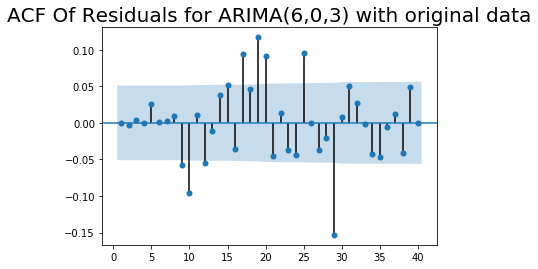

In [112]:
df['res_ar_6_i_0_ma_3_original_data'] = results_ar_6_i_0_ma_3.resid
sgt.plot_acf(df.res_ar_6_i_0_ma_3_original_data, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(6,0,3) with original data",size=20)
plt.show()

In [113]:
results_ar_3_i_0_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(3, 6)   Log Likelihood               -6571.912
Method:                       css-mle   S.D. of innovations             20.860
Date:                Tue, 06 Oct 2020   AIC                          13165.824
Time:                        15:30:31   BIC                          13224.077
Sample:                    03-10-2016   HQIC                         13187.544
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          198.9484    104.084      1.911      0.056      -5.052     402.949
ar.L1.Cierre     1.5096      0.062     24.368      0.000       1.388       1.631
ar.L2.Cierre    -1.1962      0.113    -10.580      0.000      -1.418      -0.975
ar.L3.Cierre     0.6802      0.079      8.663      0.000       0.526       0.834
ma.L1.Cierre    -0.4873      0.066     -7.439      0.000      -0.616      -0.359
ma.L2.Cierre     0.6845      0.082      8.369      0.000       0.524       0.845
ma.L3.Cierre     0.0572      0.034      1.664      0.096      -0.010       0.125
ma.L4.Cierre    -0.0966      0.034     -2.818      0.005      -0.164      -0.029
ma.L5.Cierre     0.1205      0.033      3.666      0.000       0.056       0.185
ma.L6.Cierre     0.0786      0.037      2.144      0.032       0.007       0.150
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0055           -0.0000j            1.0055           -0.0000
AR.2            0.3765           -1.1490j            1.2092           -0.1996
AR.3            0.3765           +1.1490j            1.2092            0.1996
MA.1            0.1684           -1.1015j            1.1143           -0.2259
MA.2            0.1684           +1.1015j            1.1143            0.2259
MA.3            1.0903           -0.9502j            1.4463           -0.1141
MA.4            1.0903           +0.9502j            1.4463            0.1141
MA.5           -2.0258           -0.8934j            2.2141           -0.4339
MA.6           -2.0258           +0.8934j            2.2141            0.4339
-----------------------------------------------------------------------------
"""

In [114]:
results_ar_6_i_0_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(6, 2)   Log Likelihood               -6575.412
Method:                       css-mle   S.D. of innovations             20.910
Date:                Tue, 06 Oct 2020   AIC                          13170.824
Time:                        15:30:32   BIC                          13223.781
Sample:                    03-10-2016   HQIC                         13190.570
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          195.8945    109.139      1.795      0.073     -18.013     409.803
ar.L1.Cierre     1.4433      0.064     22.544      0.000       1.318       1.569
ar.L2.Cierre    -1.2705      0.083    -15.232      0.000      -1.434      -1.107
ar.L3.Cierre     0.8779      0.064     13.688      0.000       0.752       1.004
ar.L4.Cierre    -0.1683      0.057     -2.949      0.003      -0.280      -0.056
ar.L5.Cierre     0.2253      0.047      4.760      0.000       0.133       0.318
ar.L6.Cierre    -0.1140      0.030     -3.837      0.000      -0.172      -0.056
ma.L1.Cierre    -0.4114      0.060     -6.811      0.000      -0.530      -0.293
ma.L2.Cierre     0.8313      0.032     25.930      0.000       0.768       0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0048           -0.0000j            1.0048           -0.0000
AR.2            0.3330           -1.0319j            1.0843           -0.2003
AR.3            0.3330           +1.0319j            1.0843            0.2003
AR.4           -0.9549           -1.5620j            1.8307           -0.3373
AR.5           -0.9549           +1.5620j            1.8307            0.3373
AR.6            2.2152           -0.0000j            2.2152           -0.0000
MA.1            0.2475           -1.0685j            1.0968           -0.2138
MA.2            0.2475           +1.0685j            1.0968            0.2138
-----------------------------------------------------------------------------
"""

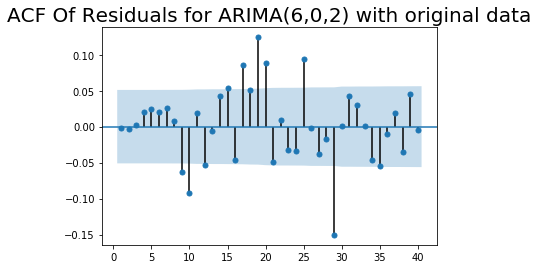

In [115]:
df['res_ar_6_i_0_ma_2_original_data'] = results_ar_6_i_0_ma_2.resid
sgt.plot_acf(df.res_ar_6_i_0_ma_2_original_data, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(6,0,2) with original data",size=20)
plt.show()

In [116]:
results_ar_2_i_0_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(2, 6)   Log Likelihood               -6587.611
Method:                       css-mle   S.D. of innovations             21.085
Date:                Tue, 06 Oct 2020   AIC                          13195.222
Time:                        15:31:16   BIC                          13248.179
Sample:                    03-10-2016   HQIC                         13214.967
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          207.3132     92.107      2.251      0.024      26.786     387.840
ar.L1.Cierre     1.1950      0.101     11.820      0.000       0.997       1.393
ar.L2.Cierre    -0.2010      0.101     -1.995      0.046      -0.398      -0.004
ma.L1.Cierre    -0.1685      0.099     -1.699      0.089      -0.363       0.026
ma.L2.Cierre     0.0116      0.026      0.437      0.662      -0.040       0.063
ma.L3.Cierre     0.0649      0.027      2.366      0.018       0.011       0.119
ma.L4.Cierre    -0.0632      0.030     -2.125      0.034      -0.121      -0.005
ma.L5.Cierre     0.0894      0.030      2.997      0.003       0.031       0.148
ma.L6.Cierre     0.1470      0.033      4.428      0.000       0.082       0.212
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0075           +0.0000j            1.0075            0.0000
AR.2            4.9379           +0.0000j            4.9379            0.0000
MA.1            1.1001           -0.6501j            1.2778           -0.0849
MA.2            1.1001           +0.6501j            1.2778            0.0849
MA.3            0.0026           -1.3231j            1.3231           -0.2497
MA.4            0.0026           +1.3231j            1.3231            0.2497
MA.5           -1.4067           -0.6336j            1.5428           -0.4326
MA.6           -1.4067           +0.6336j            1.5428            0.4326
-----------------------------------------------------------------------------
"""

In [103]:
results_ar_6_i_0_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(6, 1)   Log Likelihood               -6584.574
Method:                       css-mle   S.D. of innovations             21.141
Date:                Tue, 06 Oct 2020   AIC                          13187.149
Time:                        15:22:24   BIC                          13234.804
Sample:                             0   HQIC                         13204.918
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0760      0.659      0.115      0.908      -1.215       1.367
ar.L1.y        0.0423      0.155      0.274      0.784      -0.261       0.345
ar.L2.y       -0.0078      0.027     -0.292      0.770      -0.060       0.045
ar.L3.y        0.0157      0.026      0.607      0.544      -0.035       0.066
ar.L4.y       -0.0783      0.026     -3.028      0.002      -0.129      -0.028
ar.L5.y        0.0860      0.029      3.015      0.003       0.030       0.142
ar.L6.y        0.1121      0.029      3.820      0.000       0.055       0.170
ma.L1.y       -0.0066      0.154     -0.043      0.966      -0.309       0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3786           -0.0000j            1.3786           -0.0000
AR.2            0.6591           -1.1765j            1.3486           -0.1687
AR.3            0.6591           +1.1765j            1.3486            0.1687
AR.4           -0.8468           -1.1368j            1.4175           -0.3519
AR.5           -0.8468           +1.1368j            1.4175            0.3519
AR.6           -1.7699           -0.0000j            1.7699           -0.5000
MA.1          150.9201           +0.0000j          150.9201            0.0000
-----------------------------------------------------------------------------
"""

In [104]:
results_ar_1_i_0_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(1, 6)   Log Likelihood               -6583.562
Method:                       css-mle   S.D. of innovations             21.126
Date:                Tue, 06 Oct 2020   AIC                          13185.124
Time:                        15:22:36   BIC                          13232.780
Sample:                             0   HQIC                         13202.894
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0786      0.725      0.108      0.914      -1.342       1.500
ar.L1.y        0.1823      0.104      1.749      0.080      -0.022       0.387
ma.L1.y       -0.1517      0.102     -1.484      0.138      -0.352       0.049
ma.L2.y        0.0086      0.026      0.327      0.743      -0.043       0.060
ma.L3.y        0.0608      0.027      2.227      0.026       0.007       0.114
ma.L4.y       -0.0659      0.030     -2.213      0.027      -0.124      -0.008
ma.L5.y        0.0842      0.030      2.804      0.005       0.025       0.143
ma.L6.y        0.1420      0.033      4.319      0.000       0.078       0.206
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.4852           +0.0000j            5.4852            0.0000
MA.1            1.1149           -0.6549j            1.2930           -0.0845
MA.2            1.1149           +0.6549j            1.2930            0.0845
MA.3           -0.0010           -1.3281j            1.3281           -0.2501
MA.4           -0.0010           +1.3281j            1.3281            0.2501
MA.5           -1.4105           -0.6319j            1.5456           -0.4330
MA.6           -1.4105           +0.6319j            1.5456            0.4330
-----------------------------------------------------------------------------
"""

In [117]:
print("ARIMA(6,0,3):  \t LL = ", results_ar_6_i_0_ma_3.llf, "\t AIC = ", results_ar_6_i_0_ma_3.aic)
print("ARIMA(6,0,2):  \t LL = ", results_ar_6_i_0_ma_2.llf, "\t AIC = ", results_ar_6_i_0_ma_2.aic)

ARIMA(6,0,3):  	 LL =  -6573.864289164232 	 AIC =  13169.728578328464
ARIMA(6,0,2):  	 LL =  -6575.411991598281 	 AIC =  13170.823983196562


In [127]:
model1 = results_ar_6_i_0_ma_2
model2 = results_ar_6_i_0_ma_3
DF = 1
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(6,0,3)", model1="ARIMA(6,0,2)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(6,0,3)", model1="ARIMA(6,0,2)"))

LLR test p-value = 0.079
There isn't enough evidence that ARIMA(6,0,3) is statiscally significant than ARIMA(6,0,2)


In [130]:
model1 = results_ar_1_i_0_ma_1
model2 = results_ar_6_i_0_ma_2
DF = 7
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(6,0,2)", model1="ARIMA(1,0,1)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(6,0,2)", model1="ARIMA(1,0,1)"))

LLR test p-value = 0.0
There is enough evidence that ARIMA(6,0,2) is statiscally significant than ARIMA(1,0,1)


**OVERRALL**

At the moment the best model is ARIMA(6,0,2)

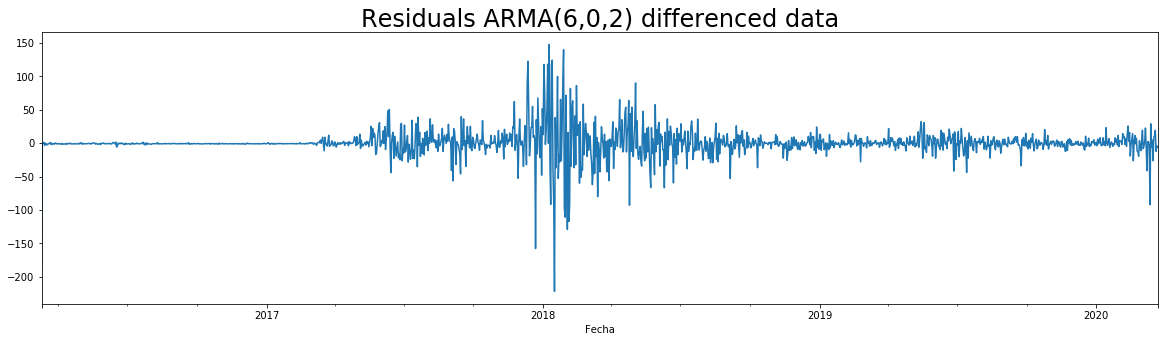

In [152]:
# Plotting residuals
df['res_ar_6_i_0_ma_2'] = results_ar_6_i_0_ma_2.resid
df.res_ar_6_i_0_ma_2.plot(figsize = (20,5))
plt.title("Residuals ARMA(6,0,2) differenced data", size=24)
plt.show()

In [154]:
# Testing stationarity of residuals
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.res_ar_6_i_0_ma_2)

print("Test-statistic \t\t", test_statistic)
print("P-value \t\t", p_value)
print("\n")
for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Test-statistic 		 -6.152446670210696
P-value 		 7.505480177971981e-08


Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


In [162]:
forecast = results_ar_6_i_0_ma_2.forecast(7)[0] 

In [164]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(df_test['Cierre'][0:7].values, forecast))

13.482526542672833

In [579]:
aux_df = pd.DataFrame({"Real_value": df_test['Cierre'][0:7].values, \
                       "Forecast": np.round(forecast,2)} \
                        , index = df_test['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-03-23,136.48,115.76
2020-03-24,138.84,119.29
2020-03-25,136.16,126.02
2020-03-26,138.74,127.28
2020-03-27,130.97,122.53
2020-03-28,131.11,119.04
2020-03-29,124.73,121.59


In [581]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual training with original values',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

## Trainig with differenced data

In [166]:
## ARIMA(1,0,1)

model_ar_1_i_0_ma_1_differenced = ARIMA(differenced, order=(1,0,1))
results_ar_1_i_0_ma_1_differenced = model_ar_1_i_0_ma_1_differenced.fit()
results_ar_1_i_0_ma_1_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(1, 1)   Log Likelihood               -6601.147
Method:                       css-mle   S.D. of innovations             21.380
Date:                Tue, 06 Oct 2020   AIC                          13210.294
Time:                        16:47:45   BIC                          13231.475
Sample:                             0   HQIC                         13218.192
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0740      0.568      0.130      0.896      -1.039       1.187
ar.L1.y       -0.8875      0.050    -17.820      0.000      -0.985      -0.790
ma.L1.y        0.9242      0.041     22.514      0.000       0.844       1.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1267           +0.0000j            1.1267            0.5000
MA.1           -1.0820           +0.0000j            1.0820            0.5000
-----------------------------------------------------------------------------
"""

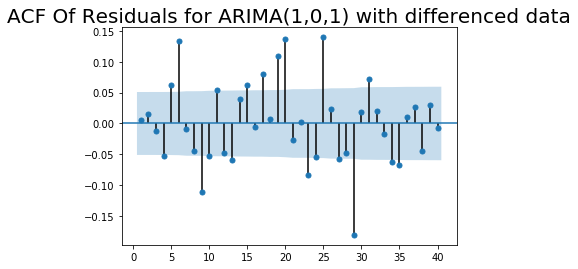

In [167]:
## Residuals of the ARIMA(1,0,1)

df['res_ar_1_i_0_ma_1_differenced'] = np.concatenate((0, results_ar_1_i_0_ma_1_differenced.resid), axis=None)
sgt.plot_acf(df.res_ar_1_i_0_ma_1_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,0,1) with differenced data",size=20)
plt.show()

In [173]:
model_ar_6_i_0_ma_6_differenced = ARIMA(differenced, order=(6,0,6))
results_ar_6_i_0_ma_6_differenced = model_ar_6_i_0_ma_6_differenced.fit()

model_ar_6_i_0_ma_5_differenced = ARIMA(differenced, order=(6,0,5))
results_ar_6_i_0_ma_5_differenced = model_ar_6_i_0_ma_5_differenced.fit()

model_ar_5_i_0_ma_6_differenced = ARIMA(differenced, order=(5,0,6))
results_ar_5_i_0_ma_6_differenced = model_ar_5_i_0_ma_6_differenced.fit()

model_ar_6_i_1_ma_4_differenced = ARIMA(differenced, order=(6,0,4))
results_ar_6_i_1_ma_4_differenced = model_ar_6_i_1_ma_4_differenced.fit()

model_ar_4_i_1_ma_6_differenced = ARIMA(differenced, order=(4,0,6))
results_ar_4_i_1_ma_6_differenced = model_ar_4_i_1_ma_6_differenced.fit()

model_ar_6_i_0_ma_3_differenced = ARIMA(differenced, order=(6,0,3))
results_ar_6_i_0_ma_3_differenced = model_ar_6_i_0_ma_3_differenced.fit()

model_ar_3_i_0_ma_6_differenced = ARIMA(differenced, order=(3,0,6))
results_ar_3_i_0_ma_6_differenced = model_ar_3_i_0_ma_6_differenced.fit()

model_ar_6_i_0_ma_2_differenced = ARIMA(differenced, order=(6,0,2))
results_ar_6_i_0_ma_2_differenced = model_ar_6_i_0_ma_2_differenced.fit()

model_ar_2_i_0_ma_6_differenced = ARIMA(differenced, order=(2,0,6))
results_ar_2_i_0_ma_6_differenced = model_ar_2_i_0_ma_6_differenced.fit()

model_ar_6_i_0_ma_1_differenced = ARIMA(differenced, order=(6,0,1))
results_ar_6_i_0_ma_1_differenced = model_ar_6_i_0_ma_1_differenced.fit()

model_ar_1_i_0_ma_6_differenced = ARIMA(differenced, order=(1,0,6))
results_ar_1_i_0_ma_6_differenced = model_ar_1_i_0_ma_6_differenced.fit()

In [209]:
results_ar_6_i_0_ma_6_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(6, 6)   Log Likelihood               -6552.031
Method:                       css-mle   S.D. of innovations             20.669
Date:                Wed, 02 Sep 2020   AIC                          13132.061
Time:                        22:05:57   BIC                          13206.192
Sample:                             0   HQIC                         13159.703
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0789      0.667      0.118      0.906      -1.228       1.386
ar.L1.y        0.4267      0.051      8.324      0.000       0.326       0.527
ar.L2.y        0.1468      0.047      3.145      0.002       0.055       0.238
ar.L3.y       -0.2876      0.048     -6.011      0.000      -0.381      -0.194
ar.L4.y       -0.0437      0.050     -0.866      0.386      -0.143       0.055
ar.L5.y        0.4314      0.056      7.740      0.000       0.322       0.541
ar.L6.y       -0.7275      0.047    -15.321      0.000      -0.821      -0.634
ma.L1.y       -0.3785      0.040     -9.474      0.000      -0.457      -0.300
ma.L2.y       -0.1143      0.039     -2.913      0.004      -0.191      -0.037
ma.L3.y        0.2902      0.040      7.311      0.000       0.212       0.368
ma.L4.y       -0.0051      0.048     -0.107      0.915      -0.099       0.088
ma.L5.y       -0.3332      0.047     -7.141      0.000      -0.425      -0.242
ma.L6.y        0.8465      0.038     21.987      0.000       0.771       0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8843           -0.5209j            1.0263           -0.4153
AR.2           -0.8843           +0.5209j            1.0263            0.4153
AR.3            0.2381           -1.0587j            1.0852           -0.2148
AR.4            0.2381           +1.0587j            1.0852            0.2148
AR.5            0.9427           -0.4685j            1.0527           -0.0734
AR.6            0.9427           +0.4685j            1.0527            0.0734
MA.1           -0.8869           -0.5056j            1.0209           -0.4175
MA.2           -0.8869           +0.5056j            1.0209            0.4175
MA.3            0.1853           -1.0322j            1.0487           -0.2217
MA.4            0.1853           +1.0322j            1.0487            0.2217
MA.5            0.8984           -0.4727j            1.0152           -0.0771
MA.6            0.8984           +0.4727j            1.0152            0.0771
-----------------------------------------------------------------------------
"""

In [210]:
results_ar_6_i_0_ma_5_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(6, 5)   Log Likelihood               -6545.295
Method:                       css-mle   S.D. of innovations             20.575
Date:                Wed, 02 Sep 2020   AIC                          13116.590
Time:                        22:06:05   BIC                          13185.426
Sample:                             0   HQIC                         13142.258
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0769      0.574      0.134      0.894      -1.049       1.203
ar.L1.y        1.7626      0.206      8.552      0.000       1.359       2.167
ar.L2.y       -1.7165      0.448     -3.833      0.000      -2.594      -0.839
ar.L3.y        1.0429      0.539      1.936      0.053      -0.013       2.098
ar.L4.y       -0.3673      0.412     -0.891      0.373      -1.175       0.441
ar.L5.y        0.0144      0.182      0.079      0.937      -0.341       0.370
ar.L6.y       -0.1476      0.028     -5.293      0.000      -0.202      -0.093
ma.L1.y       -1.7599      0.208     -8.457      0.000      -2.168      -1.352
ma.L2.y        1.7150      0.446      3.842      0.000       0.840       2.590
ma.L3.y       -1.0053      0.543     -1.850      0.064      -2.070       0.060
ma.L4.y        0.2223      0.425      0.523      0.601      -0.611       1.055
ma.L5.y        0.2690      0.193      1.397      0.163      -0.108       0.646
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9346           -0.4467j            1.0359           -0.0710
AR.2            0.9346           +0.4467j            1.0359            0.0710
AR.3            0.3178           -1.0786j            1.1245           -0.2044
AR.4            0.3178           +1.0786j            1.1245            0.2044
AR.5           -1.2037           -1.8826j            2.2345           -0.3405
AR.6           -1.2037           +1.8826j            2.2345            0.3405
MA.1            0.9007           -0.4665j            1.0143           -0.0761
MA.2            0.9007           +0.4665j            1.0143            0.0761
MA.3            0.2020           -1.0729j            1.0917           -0.2204
MA.4            0.2020           +1.0729j            1.0917            0.2204
MA.5           -3.0317           -0.0000j            3.0317           -0.5000
-----------------------------------------------------------------------------
"""

In [211]:
results_ar_5_i_0_ma_6_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(5, 6)   Log Likelihood               -6545.093
Method:                       css-mle   S.D. of innovations             20.572
Date:                Wed, 02 Sep 2020   AIC                          13116.186
Time:                        22:06:11   BIC                          13185.022
Sample:                             0   HQIC                         13141.853
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0763      0.559      0.137      0.891      -1.019       1.171
ar.L1.y        1.8408      0.181     10.181      0.000       1.486       2.195
ar.L2.y       -1.7080      0.392     -4.358      0.000      -2.476      -0.940
ar.L3.y        0.8667      0.471      1.839      0.066      -0.057       1.791
ar.L4.y       -0.0714      0.360     -0.198      0.843      -0.778       0.635
ar.L5.y       -0.2616      0.154     -1.694      0.090      -0.564       0.041
ma.L1.y       -1.8386      0.179    -10.262      0.000      -2.190      -1.487
ma.L2.y        1.7044      0.382      4.456      0.000       0.955       2.454
ma.L3.y       -0.8329      0.466     -1.786      0.074      -1.747       0.081
ma.L4.y       -0.0730      0.369     -0.198      0.843      -0.795       0.650
ma.L5.y        0.5545      0.173      3.197      0.001       0.215       0.894
ma.L6.y       -0.1670      0.031     -5.348      0.000      -0.228      -0.106
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9387           -0.4442j            1.0385           -0.0703
AR.2            0.9387           +0.4442j            1.0385            0.0703
AR.3            0.2991           -1.0955j            1.1356           -0.2076
AR.4            0.2991           +1.0955j            1.1356            0.2076
AR.5           -2.7484           -0.0000j            2.7484           -0.5000
MA.1            0.9028           -0.4682j            1.0170           -0.0761
MA.2            0.9028           +0.4682j            1.0170            0.0761
MA.3            0.1894           -1.0664j            1.0831           -0.2220
MA.4            0.1894           +1.0664j            1.0831            0.2220
MA.5           -1.7251           -0.0000j            1.7251           -0.5000
MA.6            2.8603           -0.0000j            2.8603           -0.0000
-----------------------------------------------------------------------------
"""

In [212]:
results_ar_6_i_1_ma_4_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(6, 4)   Log Likelihood               -6567.514
Method:                       css-mle   S.D. of innovations             20.895
Date:                Wed, 02 Sep 2020   AIC                          13159.028
Time:                        22:06:19   BIC                          13222.569
Sample:                             0   HQIC                         13182.721
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0735      0.620      0.119      0.906      -1.142       1.289
ar.L1.y       -0.0702      0.154     -0.457      0.648      -0.371       0.231
ar.L2.y       -0.1934      0.089     -2.180      0.029      -0.367      -0.020
ar.L3.y       -0.4890      0.094     -5.227      0.000      -0.672      -0.306
ar.L4.y        0.2952      0.121      2.446      0.014       0.059       0.532
ar.L5.y        0.0487      0.032      1.521      0.128      -0.014       0.112
ar.L6.y        0.1110      0.030      3.690      0.000       0.052       0.170
ma.L1.y        0.1044      0.153      0.683      0.494      -0.195       0.404
ma.L2.y        0.2139      0.090      2.375      0.018       0.037       0.390
ma.L3.y        0.5395      0.096      5.624      0.000       0.352       0.728
ma.L4.y       -0.3787      0.124     -3.055      0.002      -0.622      -0.136
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0878           -0.0000j            1.0878           -0.5000
AR.2            0.3288           -1.0641j            1.1137           -0.2023
AR.3            0.3288           +1.0641j            1.1137            0.2023
AR.4            1.5096           -0.0000j            1.5096           -0.0000
AR.5           -0.7591           -1.9608j            2.1026           -0.3088
AR.6           -0.7591           +1.9608j            2.1026            0.3088
MA.1           -1.0627           -0.0000j            1.0627           -0.5000
MA.2            0.2119           -1.0767j            1.0973           -0.2191
MA.3            0.2119           +1.0767j            1.0973            0.2191
MA.4            2.0635           -0.0000j            2.0635           -0.0000
-----------------------------------------------------------------------------
"""

In [213]:
results_ar_4_i_1_ma_6_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(4, 6)   Log Likelihood               -6565.379
Method:                       css-mle   S.D. of innovations             20.864
Date:                Wed, 02 Sep 2020   AIC                          13154.759
Time:                        22:06:30   BIC                          13218.300
Sample:                             0   HQIC                         13178.452
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0739      0.647      0.114      0.909      -1.194       1.342
ar.L1.y        0.0385      0.132      0.291      0.771      -0.221       0.298
ar.L2.y       -0.0892      0.082     -1.085      0.278      -0.250       0.072
ar.L3.y       -0.5566      0.075     -7.470      0.000      -0.703      -0.411
ar.L4.y        0.3173      0.089      3.579      0.000       0.144       0.491
ma.L1.y       -0.0102      0.132     -0.077      0.939      -0.269       0.248
ma.L2.y        0.1050      0.084      1.257      0.209      -0.059       0.269
ma.L3.y        0.6084      0.075      8.081      0.000       0.461       0.756
ma.L4.y       -0.3959      0.085     -4.652      0.000      -0.563      -0.229
ma.L5.y        0.0815      0.034      2.398      0.016       0.015       0.148
ma.L6.y        0.1468      0.037      3.936      0.000       0.074       0.220
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0838           -0.0000j            1.0838           -0.5000
AR.2            0.3353           -1.1087j            1.1583           -0.2033
AR.3            0.3353           +1.1087j            1.1583            0.2033
AR.4            2.1676           -0.0000j            2.1676           -0.0000
MA.1            0.1871           -1.0827j            1.0988           -0.2228
MA.2            0.1871           +1.0827j            1.0988            0.2228
MA.3            1.2278           -0.8838j            1.5128           -0.0993
MA.4            1.2278           +0.8838j            1.5128            0.0993
MA.5           -1.0612           -0.0000j            1.0612           -0.5000
MA.6           -2.3236           -0.0000j            2.3236           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
############################### The next model have only 1 no significant variable

In [174]:
results_ar_6_i_0_ma_3_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(6, 3)   Log Likelihood               -6569.125
Method:                       css-mle   S.D. of innovations             20.918
Date:                Tue, 06 Oct 2020   AIC                          13160.251
Time:                        17:00:41   BIC                          13218.496
Sample:                             0   HQIC                         13181.969
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0744      0.621      0.120      0.905      -1.143       1.292
ar.L1.y        0.8048      0.224      3.591      0.000       0.366       1.244
ar.L2.y       -0.9736      0.107     -9.089      0.000      -1.184      -0.764
ar.L3.y        0.4012      0.184      2.177      0.029       0.040       0.762
ar.L4.y       -0.1089      0.045     -2.439      0.015      -0.196      -0.021
ar.L5.y        0.1326      0.046      2.855      0.004       0.042       0.224
ar.L6.y        0.0049      0.042      0.115      0.908      -0.078       0.088
ma.L1.y       -0.7744      0.223     -3.478      0.001      -1.211      -0.338
ma.L2.y        0.9713      0.095     10.235      0.000       0.785       1.157
ma.L3.y       -0.3544      0.181     -1.958      0.050      -0.709       0.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3350           -1.0671j            1.1184           -0.2016
AR.2            0.3350           +1.0671j            1.1184            0.2016
AR.3            1.5411           -0.0000j            1.5411           -0.0000
AR.4           -0.6515           -1.8336j            1.9459           -0.3043
AR.5           -0.6515           +1.8336j            1.9459            0.3043
AR.6          -28.0801           -0.0000j           28.0801           -0.5000
MA.1            0.2089           -1.0822j            1.1021           -0.2196
MA.2            0.2089           +1.0822j            1.1021            0.2196
MA.3            2.3232           -0.0000j            2.3232           -0.0000
-----------------------------------------------------------------------------
"""

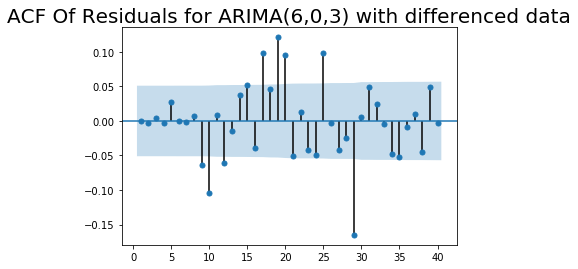

In [175]:
## Residuals of the ARIMA(6,0,3)

df['res_ar_6_i_0_ma_3_differenced'] = np.concatenate((0, results_ar_6_i_0_ma_3_differenced.resid), axis=None)
sgt.plot_acf(df.res_ar_6_i_0_ma_3_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(6,0,3) with differenced data",size=20)
plt.show()

In [215]:
results_ar_3_i_0_ma_6_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(3, 6)   Log Likelihood               -6566.437
Method:                       css-mle   S.D. of innovations             20.880
Date:                Wed, 02 Sep 2020   AIC                          13154.874
Time:                        22:07:04   BIC                          13213.119
Sample:                             0   HQIC                         13176.592
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.650      0.115      0.909      -1.200       1.349
ar.L1.y        0.8349      0.220      3.789      0.000       0.403       1.267
ar.L2.y       -0.8775      0.157     -5.607      0.000      -1.184      -0.571
ar.L3.y        0.2498      0.164      1.520      0.129      -0.072       0.572
ma.L1.y       -0.8073      0.220     -3.668      0.000      -1.239      -0.376
ma.L2.y        0.8710      0.155      5.621      0.000       0.567       1.175
ma.L3.y       -0.1946      0.169     -1.153      0.249      -0.526       0.136
ma.L4.y       -0.1085      0.043     -2.537      0.011      -0.192      -0.025
ma.L5.y        0.1588      0.047      3.374      0.001       0.067       0.251
ma.L6.y        0.0289      0.052      0.555      0.579      -0.073       0.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3405           -1.1391j            1.1889           -0.2038
AR.2            0.3405           +1.1391j            1.1889            0.2038
AR.3            2.8318           -0.0000j            2.8318           -0.0000
MA.1            0.1741           -1.0875j            1.1013           -0.2247
MA.2            0.1741           +1.0875j            1.1013            0.2247
MA.3            1.1520           -0.8630j            1.4394           -0.1023
MA.4            1.1520           +0.8630j            1.4394            0.1023
MA.5           -2.3925           -0.0000j            2.3925           -0.5000
MA.6           -5.7541           -0.0000j            5.7541           -0.5000
-----------------------------------------------------------------------------
"""

In [216]:
results_ar_6_i_0_ma_2_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(6, 2)   Log Likelihood               -6569.965
Method:                       css-mle   S.D. of innovations             20.930
Date:                Wed, 02 Sep 2020   AIC                          13159.930
Time:                        22:07:13   BIC                          13212.881
Sample:                             0   HQIC                         13179.674
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0745      0.596      0.125      0.900      -1.094       1.243
ar.L1.y        0.4061      0.063      6.429      0.000       0.282       0.530
ar.L2.y       -0.8092      0.047    -17.344      0.000      -0.901      -0.718
ar.L3.y        0.0518      0.035      1.480      0.139      -0.017       0.120
ar.L4.y       -0.0952      0.035     -2.723      0.006      -0.164      -0.027
ar.L5.y        0.0937      0.034      2.785      0.005       0.028       0.160
ar.L6.y        0.0313      0.031      1.017      0.309      -0.029       0.092
ma.L1.y       -0.3740      0.058     -6.439      0.000      -0.488      -0.260
ma.L2.y        0.8191      0.038     21.616      0.000       0.745       0.893
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3373           -1.0473j            1.1003           -0.2004
AR.2            0.3373           +1.0473j            1.1003            0.2004
AR.3            1.9381           -0.0000j            1.9381           -0.0000
AR.4           -0.6945           -1.6575j            1.7971           -0.3131
AR.5           -0.6945           +1.6575j            1.7971            0.3131
AR.6           -4.2210           -0.0000j            4.2210           -0.5000
MA.1            0.2283           -1.0811j            1.1049           -0.2169
MA.2            0.2283           +1.0811j            1.1049            0.2169
-----------------------------------------------------------------------------
"""

In [176]:
results_ar_2_i_0_ma_6_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(2, 6)   Log Likelihood               -6567.189
Method:                       css-mle   S.D. of innovations             20.890
Date:                Tue, 06 Oct 2020   AIC                          13154.378
Time:                        17:02:22   BIC                          13207.329
Sample:                             0   HQIC                         13174.122
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.624      0.120      0.905      -1.149       1.299
ar.L1.y        0.5142      0.061      8.374      0.000       0.394       0.634
ar.L2.y       -0.6917      0.078     -8.910      0.000      -0.844      -0.540
ma.L1.y       -0.4885      0.065     -7.501      0.000      -0.616      -0.361
ma.L2.y        0.6913      0.081      8.549      0.000       0.533       0.850
ma.L3.y        0.0545      0.034      1.587      0.113      -0.013       0.122
ma.L4.y       -0.0990      0.034     -2.884      0.004      -0.166      -0.032
ma.L5.y        0.1190      0.033      3.612      0.000       0.054       0.184
ma.L6.y        0.0740      0.037      2.016      0.044       0.002       0.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3717           -1.1435j            1.2024           -0.2000
AR.2            0.3717           +1.1435j            1.2024            0.2000
MA.1            0.1704           -1.0996j            1.1127           -0.2255
MA.2            0.1704           +1.0996j            1.1127            0.2255
MA.3            1.1016           -0.9639j            1.4638           -0.1144
MA.4            1.1016           +0.9639j            1.4638            0.1144
MA.5           -2.0766           -0.8853j            2.2574           -0.4359
MA.6           -2.0766           +0.8853j            2.2574            0.4359
-----------------------------------------------------------------------------
"""

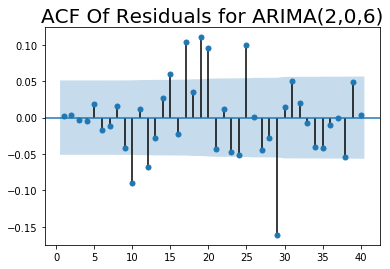

In [177]:
df['res_ar_2_i_0_ma_6_differenced'] = np.concatenate(([0], results_ar_2_i_0_ma_6_differenced.resid))
sgt.plot_acf(df.res_ar_2_i_0_ma_6_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(2,0,6)",size=20)
plt.show()

In [218]:
results_ar_6_i_0_ma_1_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(6, 1)   Log Likelihood               -6584.574
Method:                       css-mle   S.D. of innovations             21.141
Date:                Wed, 02 Sep 2020   AIC                          13187.149
Time:                        22:07:52   BIC                          13234.804
Sample:                             0   HQIC                         13204.918
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0760      0.659      0.115      0.908      -1.215       1.367
ar.L1.y        0.0423      0.155      0.274      0.784      -0.261       0.345
ar.L2.y       -0.0078      0.027     -0.292      0.770      -0.060       0.045
ar.L3.y        0.0157      0.026      0.607      0.544      -0.035       0.066
ar.L4.y       -0.0783      0.026     -3.028      0.002      -0.129      -0.028
ar.L5.y        0.0860      0.029      3.015      0.003       0.030       0.142
ar.L6.y        0.1121      0.029      3.820      0.000       0.055       0.170
ma.L1.y       -0.0066      0.154     -0.043      0.966      -0.309       0.296
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3786           -0.0000j            1.3786           -0.0000
AR.2            0.6591           -1.1765j            1.3486           -0.1687
AR.3            0.6591           +1.1765j            1.3486            0.1687
AR.4           -0.8468           -1.1368j            1.4175           -0.3519
AR.5           -0.8468           +1.1368j            1.4175            0.3519
AR.6           -1.7699           -0.0000j            1.7699           -0.5000
MA.1          150.9201           +0.0000j          150.9201            0.0000
-----------------------------------------------------------------------------
"""

In [219]:
results_ar_1_i_0_ma_6_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(1, 6)   Log Likelihood               -6583.562
Method:                       css-mle   S.D. of innovations             21.126
Date:                Wed, 02 Sep 2020   AIC                          13185.124
Time:                        22:07:58   BIC                          13232.780
Sample:                             0   HQIC                         13202.894
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0786      0.725      0.108      0.914      -1.342       1.500
ar.L1.y        0.1823      0.104      1.749      0.080      -0.022       0.387
ma.L1.y       -0.1517      0.102     -1.484      0.138      -0.352       0.049
ma.L2.y        0.0086      0.026      0.327      0.743      -0.043       0.060
ma.L3.y        0.0608      0.027      2.227      0.026       0.007       0.114
ma.L4.y       -0.0659      0.030     -2.213      0.027      -0.124      -0.008
ma.L5.y        0.0842      0.030      2.804      0.005       0.025       0.143
ma.L6.y        0.1420      0.033      4.319      0.000       0.078       0.206
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.4852           +0.0000j            5.4852            0.0000
MA.1            1.1149           -0.6549j            1.2930           -0.0845
MA.2            1.1149           +0.6549j            1.2930            0.0845
MA.3           -0.0010           -1.3281j            1.3281           -0.2501
MA.4           -0.0010           +1.3281j            1.3281            0.2501
MA.5           -1.4105           -0.6319j            1.5456           -0.4330
MA.6           -1.4105           +0.6319j            1.5456            0.4330
-----------------------------------------------------------------------------
"""

In [179]:
print("ARIMA(6,0,3):  \t LL = ", results_ar_6_i_0_ma_3_differenced.llf, "\t AIC = ", results_ar_6_i_0_ma_3_differenced.aic)
print("ARIMA(2,0,6):  \t LL = ", results_ar_2_i_0_ma_6_differenced.llf, "\t AIC = ", results_ar_2_i_0_ma_6_differenced.aic)

ARIMA(6,0,3):  	 LL =  -6569.125418337839 	 AIC =  13160.250836675677
ARIMA(2,0,6):  	 LL =  -6567.18898767992 	 AIC =  13154.37797535984


Clearly both the ACF & LL and AIC indexes shows that ARIMA(2,0,6) is the best model.

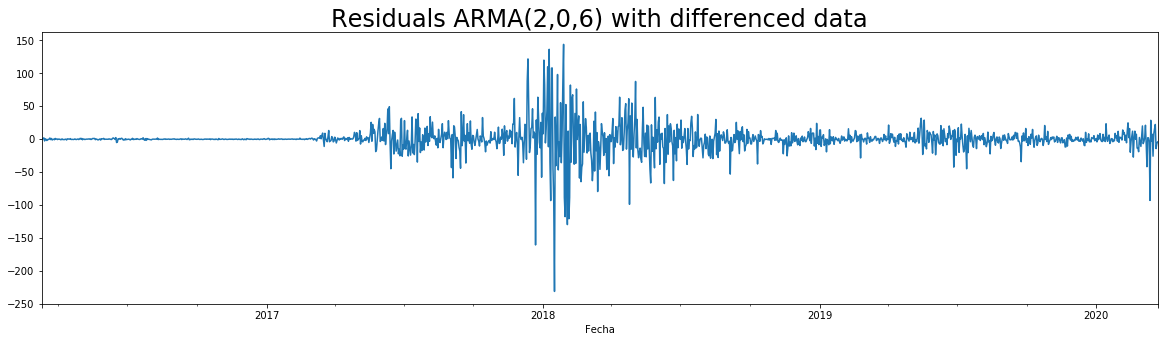

In [181]:
# Plotting residuals
df.res_ar_2_i_0_ma_6_differenced.plot(figsize = (20,5))
plt.title("Residuals ARMA(2,0,6) with differenced data", size=24)
plt.show()

In [182]:
# Testing stationarity of residuals
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.res_ar_2_i_0_ma_6_differenced)

print("Test-statistic \t\t", test_statistic)
print("P-value \t\t", p_value)
print("\n")
for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Test-statistic 		 -6.262171928880945
P-value 		 4.197386769132538e-08


Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


This show us that residuals are white noise.

In [184]:
forecast_differenced = results_ar_2_i_0_ma_6_differenced.forecast(7)[0] 
forecast_differenced

array([-7.94736994,  5.07502814,  8.5710206 , -0.46413012, -7.09242365,
       -3.55521009,  3.16568336])

In [220]:
predicitions_differenced = inverse_difference(df.Cierre, forecast_differenced, interval = 1)

In [221]:
predicitions_differenced

array([114.54263006, 119.6176582 , 128.1886788 , 127.72454868,
       120.63212503, 117.07691494, 120.24259829])

In [224]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(df_test['Cierre'][0:7].values, predicitions_differenced))

13.936409984939473

In [582]:
aux_df = pd.DataFrame({"Real_value": df_test['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_differenced,2)} \
                        , index = df_test['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-03-23,136.48,114.54
2020-03-24,138.84,119.62
2020-03-25,136.16,128.19
2020-03-26,138.74,127.72
2020-03-27,130.97,120.63
2020-03-28,131.11,117.08
2020-03-29,124.73,120.24


In [583]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual training with original values',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [238]:
model_ar_5_i_0_ma_5_differenced = ARIMA(differenced, order=(5,0,5))
results_ar_5_i_0_ma_5_differenced = model_ar_5_i_0_ma_5_differenced.fit()

model_ar_5_i_0_ma_4_differenced = ARIMA(differenced, order=(5,0,4))
results_ar_5_i_0_ma_4_differenced = model_ar_5_i_0_ma_4_differenced.fit()

model_ar_4_i_0_ma_5_differenced = ARIMA(differenced, order=(4,0,5))
results_ar_4_i_0_ma_5_differenced = model_ar_4_i_0_ma_5_differenced.fit()

model_ar_5_i_1_ma_3_differenced = ARIMA(differenced, order=(5,0,3))
results_ar_5_i_0_ma_3_differenced = model_ar_5_i_1_ma_3_differenced.fit()

model_ar_3_i_1_ma_5_differenced = ARIMA(differenced, order=(3,0,5))
results_ar_3_i_0_ma_5_differenced = model_ar_3_i_1_ma_5_differenced.fit()

model_ar_5_i_0_ma_2_differenced = ARIMA(differenced, order=(5,0,2))
results_ar_5_i_0_ma_2_differenced = model_ar_5_i_0_ma_2_differenced.fit()

model_ar_2_i_0_ma_5_differenced = ARIMA(differenced, order=(2,0,5))
results_ar_2_i_0_ma_5_differenced = model_ar_2_i_0_ma_5_differenced.fit()

model_ar_5_i_0_ma_1_differenced = ARIMA(differenced, order=(5,0,1))
results_ar_5_i_0_ma_1_differenced = model_ar_5_i_0_ma_1_differenced.fit()

model_ar_1_i_0_ma_5_differenced = ARIMA(differenced, order=(1,0,5))
results_ar_1_i_0_ma_5_differenced = model_ar_1_i_0_ma_5_differenced.fit()

In [228]:
results_ar_5_i_0_ma_5_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(5, 5)   Log Likelihood               -6554.170
Method:                       css-mle   S.D. of innovations             20.700
Date:                Tue, 06 Oct 2020   AIC                          13132.339
Time:                        20:39:17   BIC                          13195.880
Sample:                             0   HQIC                         13156.032
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0771      0.673      0.115      0.909      -1.241       1.396
ar.L1.y        1.1985      0.058     20.622      0.000       1.085       1.312
ar.L2.y       -0.5503      0.104     -5.301      0.000      -0.754      -0.347
ar.L3.y       -0.3615      0.121     -2.990      0.003      -0.598      -0.125
ar.L4.y        0.8379      0.099      8.452      0.000       0.644       1.032
ar.L5.y       -0.6803      0.055    -12.464      0.000      -0.787      -0.573
ma.L1.y       -1.1460      0.047    -24.334      0.000      -1.238      -1.054
ma.L2.y        0.5367      0.086      6.224      0.000       0.368       0.706
ma.L3.y        0.3706      0.100      3.700      0.000       0.174       0.567
ma.L4.y       -0.8890      0.081    -10.946      0.000      -1.048      -0.730
ma.L5.y        0.8211      0.044     18.546      0.000       0.734       0.908
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1208           -0.0000j            1.1208           -0.5000
AR.2            0.2322           -1.0605j            1.0856           -0.2157
AR.3            0.2322           +1.0605j            1.0856            0.2157
AR.4            0.9441           -0.4707j            1.0549           -0.0736
AR.5            0.9441           +0.4707j            1.0549            0.0736
MA.1           -1.0779           -0.0000j            1.0779           -0.5000
MA.2            0.1818           -1.0306j            1.0465           -0.2222
MA.3            0.1818           +1.0306j            1.0465            0.2222
MA.4            0.8985           -0.4737j            1.0158           -0.0772
MA.5            0.8985           +0.4737j            1.0158            0.0772
-----------------------------------------------------------------------------
"""

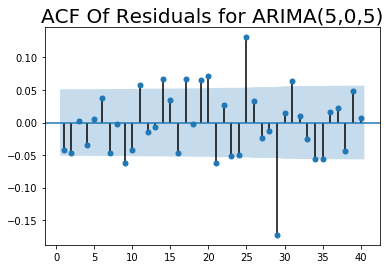

In [733]:
df['res_ar_5_i_0_ma_5_differenced'] = np.concatenate(([0], results_ar_5_i_0_ma_5_differenced.resid))
sgt.plot_acf(df.res_ar_5_i_0_ma_5_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,0,5)",size=20)
plt.show()

In [230]:
results_ar_5_i_0_ma_4_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(5, 4)   Log Likelihood               -6567.809
Method:                       css-mle   S.D. of innovations             20.899
Date:                Tue, 06 Oct 2020   AIC                          13157.618
Time:                        20:46:42   BIC                          13215.864
Sample:                             0   HQIC                         13179.337
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0753      0.647      0.116      0.907      -1.193       1.344
ar.L1.y        1.4026      0.236      5.941      0.000       0.940       1.865
ar.L2.y       -1.6716      0.215     -7.759      0.000      -2.094      -1.249
ar.L3.y        1.1253      0.249      4.527      0.000       0.638       1.613
ar.L4.y       -0.5472      0.156     -3.515      0.000      -0.852      -0.242
ar.L5.y        0.1244      0.040      3.105      0.002       0.046       0.203
ma.L1.y       -1.3813      0.240     -5.763      0.000      -1.851      -0.912
ma.L2.y        1.6730      0.224      7.466      0.000       1.234       2.112
ma.L3.y       -1.1178      0.270     -4.144      0.000      -1.646      -0.589
ma.L4.y        0.4997      0.164      3.049      0.002       0.178       0.821
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.1524           -1.2366j            1.2459           -0.2305
AR.2            0.1524           +1.2366j            1.2459            0.2305
AR.3            0.8544           -1.2002j            1.4732           -0.1515
AR.4            0.8544           +1.2002j            1.4732            0.1515
AR.5            2.3865           -0.0000j            2.3865           -0.0000
MA.1            0.1182           -1.0806j            1.0870           -0.2327
MA.2            0.1182           +1.0806j            1.0870            0.2327
MA.3            1.0003           -0.8325j            1.3013           -0.1105
MA.4            1.0003           +0.8325j            1.3013            0.1105
-----------------------------------------------------------------------------
"""

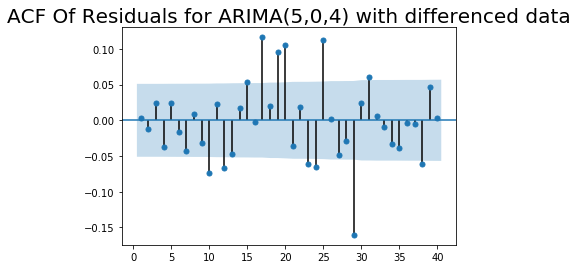

In [232]:
df['res_ar_5_i_0_ma_4_differenced'] = np.concatenate(([0], results_ar_5_i_0_ma_4_differenced.resid))
sgt.plot_acf(df.res_ar_5_i_0_ma_4_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,0,4) with differenced data",size=20)
plt.show()

In [233]:
results_ar_4_i_0_ma_5_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(4, 5)   Log Likelihood               -6563.324
Method:                       css-mle   S.D. of innovations             20.833
Date:                Tue, 06 Oct 2020   AIC                          13148.648
Time:                        20:48:46   BIC                          13206.894
Sample:                             0   HQIC                         13170.367
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0781      0.690      0.113      0.910      -1.275       1.431
ar.L1.y        1.6900      0.082     20.553      0.000       1.529       1.851
ar.L2.y       -1.8087      0.103    -17.498      0.000      -2.011      -1.606
ar.L3.y        1.3752      0.103     13.302      0.000       1.173       1.578
ar.L4.y       -0.6626      0.061    -10.931      0.000      -0.781      -0.544
ma.L1.y       -1.6679      0.088    -18.933      0.000      -1.841      -1.495
ma.L2.y        1.8260      0.128     14.312      0.000       1.576       2.076
ma.L3.y       -1.3894      0.140     -9.908      0.000      -1.664      -1.115
ma.L4.y        0.6374      0.098      6.511      0.000       0.446       0.829
ma.L5.y        0.1108      0.043      2.569      0.010       0.026       0.195
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9672           -0.5408j            1.1082           -0.0811
AR.2            0.9672           +0.5408j            1.1082            0.0811
AR.3            0.0705           -1.1064j            1.1086           -0.2399
AR.4            0.0705           +1.1064j            1.1086            0.2399
MA.1            0.9025           -0.5157j            1.0395           -0.0826
MA.2            0.9025           +0.5157j            1.0395            0.0826
MA.3            0.0691           -1.0395j            1.0418           -0.2394
MA.4            0.0691           +1.0395j            1.0418            0.2394
MA.5           -7.6948           -0.0000j            7.6948           -0.5000
-----------------------------------------------------------------------------
"""

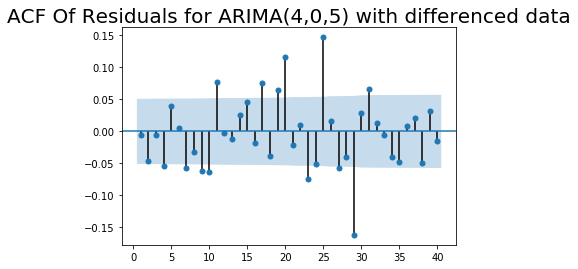

In [234]:
df['res_ar_4_i_0_ma_5_differenced'] = np.concatenate(([0], results_ar_4_i_0_ma_5_differenced.resid))
sgt.plot_acf(df.res_ar_4_i_0_ma_5_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(4,0,5) with differenced data",size=20)
plt.show()

In [239]:
results_ar_5_i_0_ma_3_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(5, 3)   Log Likelihood               -6569.132
Method:                       css-mle   S.D. of innovations             20.918
Date:                Tue, 06 Oct 2020   AIC                          13158.264
Time:                        20:53:20   BIC                          13211.214
Sample:                             0   HQIC                         13178.008
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0744      0.621      0.120      0.905      -1.142       1.291
ar.L1.y        0.8237      0.150      5.504      0.000       0.530       1.117
ar.L2.y       -0.9820      0.078    -12.626      0.000      -1.134      -0.830
ar.L3.y        0.4149      0.138      3.014      0.003       0.145       0.685
ar.L4.y       -0.1119      0.036     -3.103      0.002      -0.183      -0.041
ar.L5.y        0.1368      0.028      4.899      0.000       0.082       0.192
ma.L1.y       -0.7931      0.150     -5.298      0.000      -1.086      -0.500
ma.L2.y        0.9788      0.068     14.337      0.000       0.845       1.113
ma.L3.y       -0.3673      0.139     -2.651      0.008      -0.639      -0.096
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3342           -1.0652j            1.1164           -0.2016
AR.2            0.3342           +1.0652j            1.1164            0.2016
AR.3            1.5364           -0.0000j            1.5364           -0.0000
AR.4           -0.6934           -1.8263j            1.9535           -0.3077
AR.5           -0.6934           +1.8263j            1.9535            0.3077
MA.1            0.2107           -1.0813j            1.1016           -0.2194
MA.2            0.2107           +1.0813j            1.1016            0.2194
MA.3            2.2431           -0.0000j            2.2431           -0.0000
-----------------------------------------------------------------------------
"""

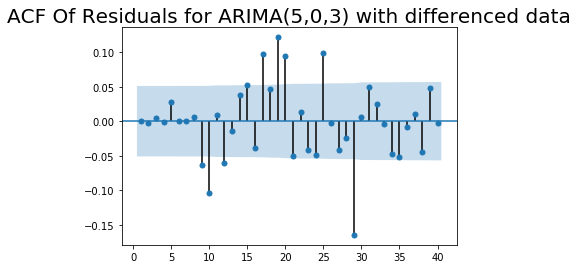

In [240]:
df['res_ar_5_i_0_ma_3_differenced'] = np.concatenate(([0], results_ar_5_i_0_ma_3_differenced.resid))
sgt.plot_acf(df.res_ar_5_i_0_ma_3_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(5,0,3) with differenced data",size=20)
plt.show()

In [241]:
results_ar_3_i_1_ma_5_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(3, 5)   Log Likelihood               -6566.588
Method:                       css-mle   S.D. of innovations             20.882
Date:                Tue, 06 Oct 2020   AIC                          13153.175
Time:                        20:53:36   BIC                          13206.126
Sample:                             0   HQIC                         13172.919
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0746      0.648      0.115      0.908      -1.195       1.344
ar.L1.y        0.9308      0.115      8.086      0.000       0.705       1.156
ar.L2.y       -0.9468      0.083    -11.399      0.000      -1.110      -0.784
ar.L3.y        0.3173      0.096      3.309      0.001       0.129       0.505
ma.L1.y       -0.9037      0.114     -7.902      0.000      -1.128      -0.680
ma.L2.y        0.9386      0.085     10.996      0.000       0.771       1.106
ma.L3.y       -0.2608      0.106     -2.449      0.014      -0.470      -0.052
ma.L4.y       -0.1207      0.039     -3.097      0.002      -0.197      -0.044
ma.L5.y        0.1785      0.032      5.494      0.000       0.115       0.242
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3398           -1.1190j            1.1695           -0.2031
AR.2            0.3398           +1.1190j            1.1695            0.2031
AR.3            2.3044           -0.0000j            2.3044           -0.0000
MA.1            0.1822           -1.0859j            1.1011           -0.2235
MA.2            0.1822           +1.0859j            1.1011            0.2235
MA.3           -2.0860           -0.0000j            2.0860           -0.5000
MA.4            1.1989           -0.8818j            1.4882           -0.1009
MA.5            1.1989           +0.8818j            1.4882            0.1009
-----------------------------------------------------------------------------
"""

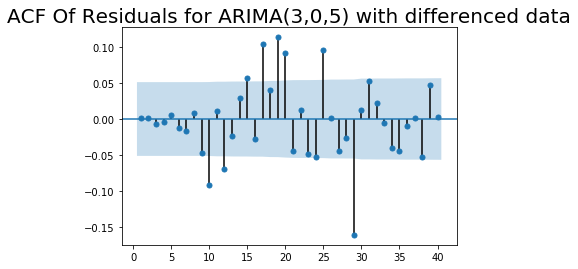

In [242]:
df['res_ar_3_i_0_ma_5_differenced'] = np.concatenate(([0], results_ar_3_i_0_ma_5_differenced.resid))
sgt.plot_acf(df.res_ar_3_i_0_ma_5_differenced[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(3,0,5) with differenced data",size=20)
plt.show()

In [243]:
results_ar_5_i_0_ma_2_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(5, 2)   Log Likelihood               -6570.454
Method:                       css-mle   S.D. of innovations             20.937
Date:                Tue, 06 Oct 2020   AIC                          13158.909
Time:                        20:54:29   BIC                          13206.564
Sample:                             0   HQIC                         13176.678
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0745      0.583      0.128      0.898      -1.069       1.218
ar.L1.y        0.4422      0.064      6.871      0.000       0.316       0.568
ar.L2.y       -0.8258      0.042    -19.858      0.000      -0.907      -0.744
ar.L3.y        0.0541      0.035      1.528      0.126      -0.015       0.124
ar.L4.y       -0.1131      0.031     -3.676      0.000      -0.173      -0.053
ar.L5.y        0.1114      0.030      3.716      0.000       0.053       0.170
ma.L1.y       -0.4079      0.061     -6.722      0.000      -0.527      -0.289
ma.L2.y        0.8315      0.032     25.923      0.000       0.769       0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3323           -1.0337j            1.0858           -0.2005
AR.2            0.3323           +1.0337j            1.0858            0.2005
AR.3           -0.9529           -1.5707j            1.8372           -0.3368
AR.4           -0.9529           +1.5707j            1.8372            0.3368
AR.5            2.2570           -0.0000j            2.2570           -0.0000
MA.1            0.2453           -1.0689j            1.0967           -0.2141
MA.2            0.2453           +1.0689j            1.0967            0.2141
-----------------------------------------------------------------------------
"""

In [244]:
results_ar_2_i_0_ma_5_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(2, 5)   Log Likelihood               -6569.064
Method:                       css-mle   S.D. of innovations             20.917
Date:                Tue, 06 Oct 2020   AIC                          13156.128
Time:                        20:54:36   BIC                          13203.784
Sample:                             0   HQIC                         13173.898
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0743      0.585      0.127      0.899      -1.071       1.220
ar.L1.y        0.5425      0.052     10.478      0.000       0.441       0.644
ar.L2.y       -0.7918      0.044    -17.890      0.000      -0.879      -0.705
ma.L1.y       -0.5163      0.058     -8.880      0.000      -0.630      -0.402
ma.L2.y        0.7941      0.050     15.924      0.000       0.696       0.892
ma.L3.y        0.0513      0.035      1.478      0.139      -0.017       0.119
ma.L4.y       -0.1254      0.032     -3.885      0.000      -0.189      -0.062
ma.L5.y        0.1366      0.032      4.290      0.000       0.074       0.199
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3426           -1.0703j            1.1238           -0.2007
AR.2            0.3426           +1.0703j            1.1238            0.2007
MA.1            0.2078           -1.0859j            1.1056           -0.2199
MA.2            0.2078           +1.0859j            1.1056            0.2199
MA.3           -1.8401           -0.0000j            1.8401           -0.5000
MA.4            1.1713           -1.3722j            1.8041           -0.1375
MA.5            1.1713           +1.3722j            1.8041            0.1375
-----------------------------------------------------------------------------
"""

In [245]:
results_ar_5_i_0_ma_1_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(5, 1)   Log Likelihood               -6589.758
Method:                       css-mle   S.D. of innovations             21.215
Date:                Tue, 06 Oct 2020   AIC                          13195.516
Time:                        20:54:42   BIC                          13237.877
Sample:                             0   HQIC                         13211.311
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0753      0.642      0.117      0.907      -1.182       1.333
ar.L1.y        0.4297      0.104      4.145      0.000       0.227       0.633
ar.L2.y       -0.0318      0.028     -1.125      0.261      -0.087       0.024
ar.L3.y        0.0236      0.028      0.843      0.399      -0.031       0.079
ar.L4.y       -0.0870      0.028     -3.101      0.002      -0.142      -0.032
ar.L5.y        0.1382      0.026      5.333      0.000       0.087       0.189
ma.L1.y       -0.3877      0.102     -3.793      0.000      -0.588      -0.187
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3939           -0.0000j            1.3939           -0.0000
AR.2            0.7400           -1.2903j            1.4875           -0.1671
AR.3            0.7400           +1.2903j            1.4875            0.1671
AR.4           -1.1223           -1.0425j            1.5318           -0.3809
AR.5           -1.1223           +1.0425j            1.5318            0.3809
MA.1            2.5795           +0.0000j            2.5795            0.0000
-----------------------------------------------------------------------------
"""

In [246]:
results_ar_1_i_0_ma_5_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(1, 5)   Log Likelihood               -6590.864
Method:                       css-mle   S.D. of innovations             21.231
Date:                Tue, 06 Oct 2020   AIC                          13197.728
Time:                        20:54:46   BIC                          13240.089
Sample:                             0   HQIC                         13213.524
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0760      0.670      0.113      0.910      -1.237       1.389
ar.L1.y        0.4372      0.094      4.627      0.000       0.252       0.622
ma.L1.y       -0.4098      0.094     -4.363      0.000      -0.594      -0.226
ma.L2.y       -0.0085      0.028     -0.298      0.765      -0.064       0.047
ma.L3.y        0.0382      0.027      1.429      0.153      -0.014       0.091
ma.L4.y       -0.0744      0.032     -2.332      0.020      -0.137      -0.012
ma.L5.y        0.1362      0.027      5.008      0.000       0.083       0.190
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2873           +0.0000j            2.2873            0.0000
MA.1            1.2379           -0.6785j            1.4117           -0.0798
MA.2            1.2379           +0.6785j            1.4117            0.0798
MA.3           -1.5126           -0.0000j            1.5126           -0.5000
MA.4           -0.2087           -1.5464j            1.5604           -0.2713
MA.5           -0.2087           +1.5464j            1.5604            0.2713
-----------------------------------------------------------------------------
"""

In [247]:
print("ARIMA(5,0,5):  \t LL = ", results_ar_5_i_0_ma_5_differenced.llf, "\t AIC = ", results_ar_5_i_0_ma_5_differenced.aic)
print("ARIMA(5,0,4):  \t LL = ", results_ar_5_i_0_ma_4_differenced.llf, "\t AIC = ", results_ar_4_i_0_ma_5_differenced.aic)
print("ARIMA(4,0,5):  \t LL = ", results_ar_4_i_0_ma_5_differenced.llf, "\t AIC = ", results_ar_4_i_0_ma_5_differenced.aic)
print("ARIMA(5,0,3):  \t LL = ", results_ar_5_i_0_ma_3_differenced.llf, "\t AIC = ", results_ar_5_i_0_ma_3_differenced.aic)
print("ARIMA(3,0,5):  \t LL = ", results_ar_3_i_0_ma_5_differenced.llf, "\t AIC = ", results_ar_3_i_0_ma_5_differenced.aic)

ARIMA(5,0,5):  	 LL =  -6554.169568649548 	 AIC =  13132.339137299095
ARIMA(5,0,4):  	 LL =  -6567.809124634587 	 AIC =  13148.648453075628
ARIMA(4,0,5):  	 LL =  -6563.324226537814 	 AIC =  13148.648453075628
ARIMA(5,0,3):  	 LL =  -6569.131889429305 	 AIC =  13158.26377885861
ARIMA(3,0,5):  	 LL =  -6566.587721193564 	 AIC =  13153.175442387128


In [249]:
model1 = results_ar_5_i_0_ma_4_differenced
model2 = results_ar_5_i_0_ma_5_differenced
DF = 1
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(5,0,5)", model1="ARIMA(5,0,4)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(5,0,5)", model1="ARIMA(5,0,4)"))

LLR test p-value = 0.0
There is enough evidence that ARIMA(5,0,5) is statiscally significant than ARIMA(5,0,4)


In [258]:
model1 = results_ar_2_i_0_ma_6_differenced
model2 = results_ar_5_i_0_ma_5_differenced
DF = 2
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(5,0,5)", model1="ARIMA(2,0,6)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="ARIMA(5,0,5)", model1="ARIMA(2,0,6)"))

LLR test p-value = 0.0
There is enough evidence that ARIMA(5,0,5) is statiscally significant than ARIMA(2,0,6)


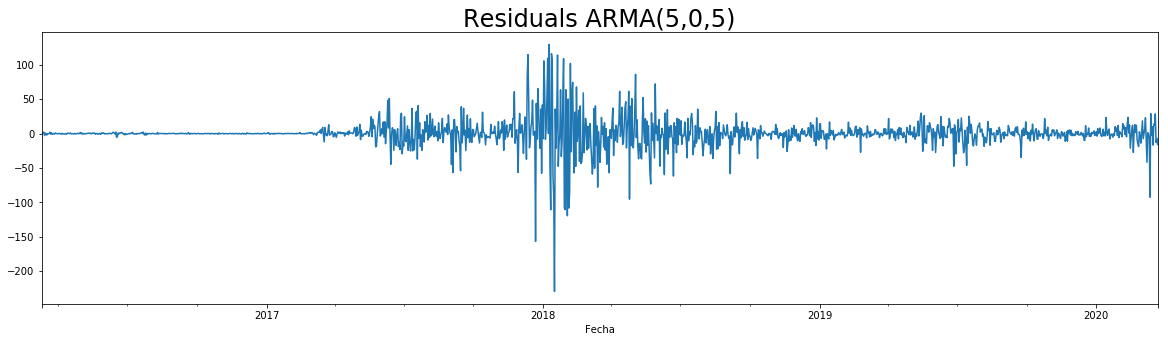

In [732]:
# Plotting residuals
df.res_ar_5_i_0_ma_5_differenced.plot(figsize = (20,5))
plt.title("Residuals ARMA(5,0,5)", size=24)
plt.show()

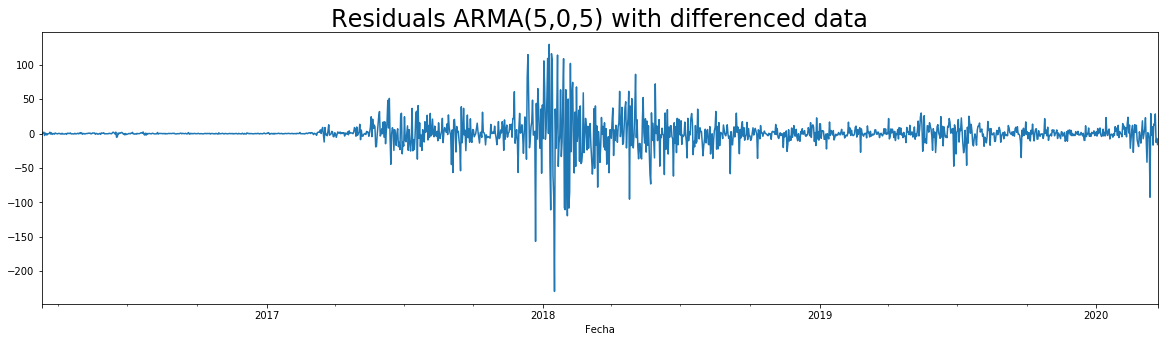

In [250]:
# Plotting residuals
df.res_ar_5_i_0_ma_5_differenced.plot(figsize = (20,5))
plt.title("Residuals ARMA(5,0,5) with differenced data", size=24)
plt.show()

In [251]:
# Testing stationarity of residuals
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.res_ar_5_i_0_ma_5_differenced)

print("Test-statistic \t\t", test_statistic)
print("P-value \t\t", p_value)
print("\n")
for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Test-statistic 		 -6.1985758456824005
P-value 		 5.882720606268809e-08


Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


This show us that residuals are white noise.

In [252]:
forecast_differenced_5_0_5 = results_ar_5_i_0_ma_5_differenced.forecast(7)[0] 
forecast_differenced_5_0_5

array([-3.04946737, 11.19333041, 10.44480331,  7.46509624, -9.35637333,
       -7.6007801 , -5.47862871])

In [253]:
predicitions_differenced_5_0_5 = inverse_difference(df.Cierre, forecast_differenced_5_0_5, interval = 1)

In [254]:
predicitions_differenced_5_0_5

array([119.44053263, 130.63386305, 141.07866635, 148.5437626 ,
       139.18738927, 131.58660917, 126.10798047])

In [256]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(df_test['Cierre'][0:7].values, predicitions_differenced_5_0_5))

8.845036093098926

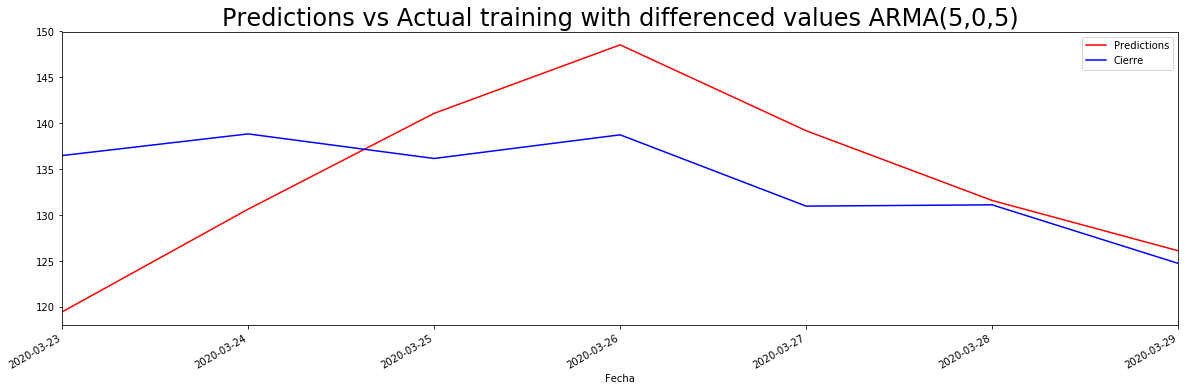

In [257]:
plt.figure(figsize=(20,6))
plt.plot(df_test['Cierre'][0:7].index, predicitions_differenced_5_0_5, color = "red", label="Predictions")
df_test['Cierre'][0:7].plot(color = "blue")
plt.title("Predictions vs Actual training with differenced values ARMA(5,0,5)", size = 24)
plt.legend()
plt.show()

In [735]:
aux_df = pd.DataFrame({"Real_value": df_test['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_differenced_5_0_5,2)} \
                        , index = df_test['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-03-23,136.48,119.44
2020-03-24,138.84,130.63
2020-03-25,136.16,141.08
2020-03-26,138.74,148.54
2020-03-27,130.97,139.19
2020-03-28,131.11,131.59
2020-03-29,124.73,126.11


In [736]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Real values ARIMA(5,0,5)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [259]:
model_ar_4_i_0_ma_4_differenced = ARIMA(differenced, order=(4,0,4))
results_ar_4_i_0_ma_4_differenced = model_ar_4_i_0_ma_4_differenced.fit()

model_ar_4_i_0_ma_3_differenced = ARIMA(differenced, order=(4,0,3))
results_ar_4_i_0_ma_3_differenced = model_ar_4_i_0_ma_3_differenced.fit()

model_ar_3_i_0_ma_4_differenced = ARIMA(differenced, order=(3,0,4))
results_ar_3_i_0_ma_4_differenced = model_ar_3_i_0_ma_4_differenced.fit()

model_ar_4_i_0_ma_2_differenced = ARIMA(differenced, order=(4,0,2))
results_ar_4_i_0_ma_2_differenced = model_ar_4_i_0_ma_2_differenced.fit()

model_ar_2_i_0_ma_4_differenced = ARIMA(differenced, order=(2,0,4))
results_ar_2_i_0_ma_4_differenced = model_ar_2_i_0_ma_4_differenced.fit()

model_ar_4_i_0_ma_1_differenced = ARIMA(differenced, order=(4,0,1))
results_ar_4_i_0_ma_1_differenced = model_ar_4_i_0_ma_1_differenced.fit()

model_ar_1_i_0_ma_4_differenced = ARIMA(differenced, order=(1,0,4))
results_ar_1_i_0_ma_4_differenced = model_ar_1_i_0_ma_4_differenced.fit()

In [260]:
results_ar_4_i_0_ma_4_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(4, 4)   Log Likelihood               -6572.457
Method:                       css-mle   S.D. of innovations             20.966
Date:                Tue, 06 Oct 2020   AIC                          13164.915
Time:                        21:46:16   BIC                          13217.865
Sample:                             0   HQIC                         13184.659
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0744      0.547      0.136      0.892      -0.997       1.146
ar.L1.y       -0.3275      0.420     -0.779      0.436      -1.151       0.496
ar.L2.y       -0.8419      0.244     -3.456      0.001      -1.319      -0.364
ar.L3.y       -0.4804      0.215     -2.236      0.025      -0.901      -0.059
ar.L4.y       -0.3566      0.441     -0.808      0.419      -1.222       0.508
ma.L1.y        0.3629      0.432      0.841      0.400      -0.483       1.209
ma.L2.y        0.8675      0.268      3.241      0.001       0.343       1.392
ma.L3.y        0.5281      0.244      2.162      0.031       0.049       1.007
ma.L4.y        0.2512      0.471      0.534      0.594      -0.671       1.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.3022           -1.0513j            1.0938           -0.2055
AR.2            0.3022           +1.0513j            1.0938            0.2055
AR.3           -0.9757           -1.1797j            1.5309           -0.3600
AR.4           -0.9757           +1.1797j            1.5309            0.3600
MA.1            0.2220           -1.0557j            1.0788           -0.2170
MA.2            0.2220           +1.0557j            1.0788            0.2170
MA.3           -1.2732           -1.3415j            1.8495           -0.3708
MA.4           -1.2732           +1.3415j            1.8495            0.3708
-----------------------------------------------------------------------------
"""

In [261]:
results_ar_4_i_0_ma_3_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(4, 3)   Log Likelihood               -6573.077
Method:                       css-mle   S.D. of innovations             20.974
Date:                Tue, 06 Oct 2020   AIC                          13164.153
Time:                        21:46:25   BIC                          13211.809
Sample:                             0   HQIC                         13181.923
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0741      0.538      0.138      0.891      -0.980       1.128
ar.L1.y       -0.1595      0.162     -0.986      0.324      -0.476       0.157
ar.L2.y       -0.6723      0.081     -8.299      0.000      -0.831      -0.514
ar.L3.y       -0.4299      0.145     -2.971      0.003      -0.714      -0.146
ar.L4.y       -0.1182      0.028     -4.229      0.000      -0.173      -0.063
ma.L1.y        0.1935      0.162      1.195      0.232      -0.124       0.511
ma.L2.y        0.6883      0.070      9.849      0.000       0.551       0.825
ma.L3.y        0.4607      0.150      3.069      0.002       0.167       0.755
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2828           -1.0768j            1.1133           -0.2091
AR.2            0.2828           +1.0768j            1.1133            0.2091
AR.3           -2.1015           -1.5524j            2.6127           -0.3987
AR.4           -2.1015           +1.5524j            2.6127            0.3987
MA.1            0.1945           -1.0559j            1.0736           -0.2210
MA.2            0.1945           +1.0559j            1.0736            0.2210
MA.3           -1.8829           -0.0000j            1.8829           -0.5000
-----------------------------------------------------------------------------
"""

In [262]:
results_ar_3_i_0_ma_4_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(3, 4)   Log Likelihood               -6573.826
Method:                       css-mle   S.D. of innovations             20.985
Date:                Tue, 06 Oct 2020   AIC                          13165.653
Time:                        21:46:29   BIC                          13213.308
Sample:                             0   HQIC                         13183.422
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0736      0.541      0.136      0.892      -0.988       1.135
ar.L1.y       -0.1831      0.270     -0.678      0.498      -0.713       0.346
ar.L2.y       -0.5415      0.126     -4.311      0.000      -0.788      -0.295
ar.L3.y       -0.5042      0.244     -2.063      0.039      -0.983      -0.025
ma.L1.y        0.2210      0.266      0.830      0.407      -0.301       0.743
ma.L2.y        0.5661      0.108      5.254      0.000       0.355       0.777
ma.L3.y        0.5310      0.248      2.142      0.032       0.045       1.017
ma.L4.y       -0.1113      0.028     -3.923      0.000      -0.167      -0.056
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2690           -1.0761j            1.1093           -0.2110
AR.2            0.2690           +1.0761j            1.1093            0.2110
AR.3           -1.6119           -0.0000j            1.6119           -0.5000
MA.1            0.1905           -1.0495j            1.0667           -0.2214
MA.2            0.1905           +1.0495j            1.0667            0.2214
MA.3           -1.3708           -0.0000j            1.3708           -0.5000
MA.4            5.7613           -0.0000j            5.7613           -0.0000
-----------------------------------------------------------------------------
"""

In [263]:
results_ar_4_i_0_ma_2_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(4, 2)   Log Likelihood               -6576.319
Method:                       css-mle   S.D. of innovations             21.021
Date:                Tue, 06 Oct 2020   AIC                          13168.638
Time:                        21:46:33   BIC                          13210.999
Sample:                             0   HQIC                         13184.433
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0740      0.527      0.140      0.888      -0.958       1.107
ar.L1.y        0.3375      0.050      6.695      0.000       0.239       0.436
ar.L2.y       -0.8630      0.043    -20.143      0.000      -0.947      -0.779
ar.L3.y       -0.0084      0.029     -0.284      0.776      -0.066       0.049
ar.L4.y       -0.0916      0.030     -3.086      0.002      -0.150      -0.033
ma.L1.y       -0.3086      0.044     -6.974      0.000      -0.395      -0.222
ma.L2.y        0.8718      0.034     25.937      0.000       0.806       0.938
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2652           -1.1046j            1.1359           -0.2125
AR.2            0.2652           +1.1046j            1.1359            0.2125
AR.3           -0.3109           -2.8921j            2.9088           -0.2670
AR.4           -0.3109           +2.8921j            2.9088            0.2670
MA.1            0.1770           -1.0563j            1.0710           -0.2236
MA.2            0.1770           +1.0563j            1.0710            0.2236
-----------------------------------------------------------------------------
"""

In [264]:
results_ar_2_i_0_ma_4_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(2, 4)   Log Likelihood               -6577.516
Method:                       css-mle   S.D. of innovations             21.038
Date:                Tue, 06 Oct 2020   AIC                          13171.032
Time:                        21:46:37   BIC                          13213.392
Sample:                             0   HQIC                         13186.827
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0735      0.536      0.137      0.891      -0.977       1.125
ar.L1.y        0.3912      0.049      8.054      0.000       0.296       0.486
ar.L2.y       -0.8004      0.049    -16.385      0.000      -0.896      -0.705
ma.L1.y       -0.3494      0.056     -6.238      0.000      -0.459      -0.240
ma.L2.y        0.8106      0.055     14.737      0.000       0.703       0.918
ma.L3.y       -0.0025      0.034     -0.073      0.942      -0.068       0.063
ma.L4.y       -0.0804      0.030     -2.644      0.008      -0.140      -0.021
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2444           -1.0907j            1.1178           -0.2149
AR.2            0.2444           +1.0907j            1.1178            0.2149
MA.1            0.1768           -1.0451j            1.0600           -0.2233
MA.2            0.1768           +1.0451j            1.0600            0.2233
MA.3            3.1398           -0.0000j            3.1398           -0.0000
MA.4           -3.5238           -0.0000j            3.5238           -0.5000
-----------------------------------------------------------------------------
"""

In [265]:
results_ar_4_i_0_ma_1_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(4, 1)   Log Likelihood               -6598.503
Method:                       css-mle   S.D. of innovations             21.342
Date:                Tue, 06 Oct 2020   AIC                          13211.006
Time:                        21:46:42   BIC                          13248.072
Sample:                             0   HQIC                         13224.827
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.543      0.138      0.891      -0.989       1.138
ar.L1.y       -0.2501      0.160     -1.565      0.118      -0.563       0.063
ar.L2.y       -0.0042      0.027     -0.153      0.878      -0.058       0.050
ar.L3.y        0.0125      0.027      0.467      0.641      -0.040       0.065
ar.L4.y       -0.0819      0.027     -3.065      0.002      -0.134      -0.030
ma.L1.y        0.2917      0.159      1.836      0.066      -0.020       0.603
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2915           -1.1022j            1.6979           -0.3876
AR.2           -1.2915           +1.1022j            1.6979            0.3876
AR.3            1.3680           -1.5376j            2.0581           -0.1343
AR.4            1.3680           +1.5376j            2.0581            0.1343
MA.1           -3.4287           +0.0000j            3.4287            0.5000
-----------------------------------------------------------------------------
"""

In [266]:
results_ar_1_i_0_ma_4_differenced.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1473
Model:                     ARMA(1, 4)   Log Likelihood               -6597.915
Method:                       css-mle   S.D. of innovations             21.334
Date:                Tue, 06 Oct 2020   AIC                          13209.830
Time:                        21:46:46   BIC                          13246.896
Sample:                             0   HQIC                         13223.651
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0745      0.550      0.135      0.892      -1.004       1.153
ar.L1.y       -0.2026      0.173     -1.170      0.242      -0.542       0.137
ma.L1.y        0.2485      0.171      1.455      0.146      -0.086       0.583
ma.L2.y        0.0143      0.028      0.518      0.604      -0.040       0.068
ma.L3.y        0.0190      0.024      0.785      0.432      -0.028       0.067
ma.L4.y       -0.0918      0.028     -3.242      0.001      -0.147      -0.036
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.9352           +0.0000j            4.9352            0.5000
MA.1           -1.5778           -0.0000j            1.5778           -0.5000
MA.2           -0.1532           -1.8106j            1.8170           -0.2634
MA.3           -0.1532           +1.8106j            1.8170            0.2634
MA.4            2.0917           -0.0000j            2.0917           -0.0000
-----------------------------------------------------------------------------
"""

## SARIMA model

In [272]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarimax = SARIMAX(differenced, order=(1,0,1), seasonal_order = (1,0,1,7))
results_sar_1_i_0_ma_1 = model_sarimax.fit()
results_sar_1_i_0_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1473
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -6597.402
Date:                           Tue, 06 Oct 2020   AIC                          13204.804
Time:                                   22:01:24   BIC                          13231.279
Sample:                                        0   HQIC                         13214.676
                                          - 1473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9109      0.020    -46.139      0.000      -0.950      -0.872
ma.L1          0.9486      0.016     58.361      0.000       0.917       0.980
ar.S.L7       -0.9162      0.051    -18.038      0.000      -1.016      -0.817
ma.S.L7        0.8861      0.055     16.050      0.000       0.778       0.994
sigma2       454.7595      5.170     87.958      0.000     444.626     464.893
===================================================================================
Ljung-Box (Q):                      257.54   Jarque-Bera (JB):             37084.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

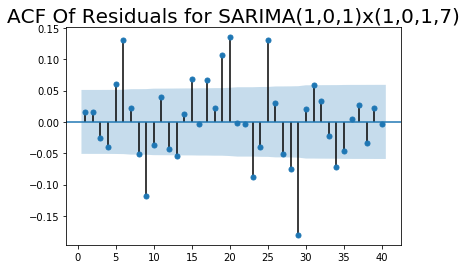

In [276]:
# Residuals of SARIMAX (1,0,1)X(1,0,1.48)
df['res_sar_1_i_0_ma_1'] = np.concatenate([0, results_sar_1_i_0_ma_1.resid], axis=None)
sgt.plot_acf(df.res_sar_1_i_0_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(1,0,1)x(1,0,1,7)",size=20)
plt.show()

In [278]:
model_sar_6_i_0_ma_6 = SARIMAX(differenced, order=(6,0,6), seasonal_order = (1,0,1,7))
results_sar_6_i_0_ma_6 = model_sar_6_i_0_ma_6.fit()

model_sar_6_i_0_ma_5 = SARIMAX(differenced, order=(6,0,5), seasonal_order = (1,0,1,7))
results_sar_6_i_0_ma_5 = model_sar_6_i_0_ma_5.fit()

model_sar_5_i_0_ma_6 = SARIMAX(differenced, order=(5,0,6), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_6 = model_sar_5_i_0_ma_6.fit()

model_sar_6_i_0_ma_4 = SARIMAX(differenced, order=(6,0,4), seasonal_order = (1,0,1,7))
results_sar_6_i_0_ma_4 = model_sar_6_i_0_ma_4.fit()

model_sar_4_i_0_ma_6 = SARIMAX(differenced, order=(4,0,6), seasonal_order = (1,0,1,7))
results_sar_4_i_0_ma_6 = model_sar_4_i_0_ma_6.fit()

model_sar_6_i_0_ma_3 = SARIMAX(differenced, order=(6,0,3), seasonal_order = (1,0,1,7))
results_sar_6_i_0_ma_3 = model_sar_6_i_0_ma_3.fit()

model_sar_3_i_0_ma_6 = SARIMAX(differenced, order=(3,0,6), seasonal_order = (1,0,1,7))
results_sar_3_i_0_ma_6 = model_sar_3_i_0_ma_6.fit()

model_sar_6_i_0_ma_2 = SARIMAX(differenced, order=(6,0,2), seasonal_order = (1,0,1,7))
results_sar_6_i_0_ma_2 = model_sar_6_i_0_ma_2.fit()

model_sar_2_i_0_ma_6 = SARIMAX(differenced, order=(2,0,6), seasonal_order = (1,0,1,7))
results_sar_2_i_0_ma_6 = model_sar_2_i_0_ma_6.fit()

model_sar_6_i_0_ma_1 = SARIMAX(differenced, order=(6,0,1), seasonal_order = (1,0,1,7))
results_sar_6_i_0_ma_1 = model_sar_6_i_0_ma_1.fit()

model_sar_1_i_0_ma_6 = SARIMAX(differenced, order=(1,0,6), seasonal_order = (1,0,1,7))
results_sar_1_i_0_ma_6 = model_sar_1_i_0_ma_6.fit()

In [279]:
results_sar_6_i_0_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(6, 0, 6)x(1, 0, [1], 7)   Log Likelihood               -6541.749
Date:                             Tue, 06 Oct 2020   AIC                          13113.498
Time:                                     22:11:02   BIC                          13192.924
Sample:                                          0   HQIC                         13143.114
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8329      0.119      6.983      0.000       0.599       1.067
ar.L2         -0.2133      0.166     -1.283      0.200      -0.539       0.113
ar.L3         -0.2930      0.126     -2.330      0.020      -0.539      -0.047
ar.L4          0.1119      0.101      1.113      0.266      -0.085       0.309
ar.L5          0.3508      0.120      2.917      0.004       0.115       0.587
ar.L6         -0.5905      0.081     -7.327      0.000      -0.748      -0.433
ma.L1         -0.8065      0.120     -6.737      0.000      -1.041      -0.572
ma.L2          0.2241      0.164      1.363      0.173      -0.098       0.547
ma.L3          0.2879      0.125      2.306      0.021       0.043       0.533
ma.L4         -0.1624      0.105     -1.553      0.120      -0.367       0.043
ma.L5         -0.1866      0.129     -1.445      0.148      -0.440       0.067
ma.L6          0.6336      0.100      6.352      0.000       0.438       0.829
ar.S.L7       -0.8777      0.037    -23.749      0.000      -0.950      -0.805
ma.S.L7        0.7970      0.047     17.013      0.000       0.705       0.889
sigma2       427.3257      6.066     70.447      0.000     415.437     439.215
===================================================================================
Ljung-Box (Q):                      122.98   Jarque-Bera (JB):             25718.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [280]:
results_sar_6_i_0_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(6, 0, 5)x(1, 0, [1], 7)   Log Likelihood               -6544.643
Date:                             Tue, 06 Oct 2020   AIC                          13117.286
Time:                                     22:11:10   BIC                          13191.417
Sample:                                          0   HQIC                         13144.927
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2114      0.019     64.366      0.000       1.175       1.248
ar.L2         -0.4883      0.027    -17.829      0.000      -0.542      -0.435
ar.L3         -0.6049      0.028    -21.314      0.000      -0.661      -0.549
ar.L4          1.0830      0.028     39.181      0.000       1.029       1.137
ar.L5         -0.6498      0.025    -26.288      0.000      -0.698      -0.601
ar.L6         -0.0342      0.016     -2.150      0.032      -0.065      -0.003
ma.L1         -1.1706      0.018    -65.593      0.000      -1.206      -1.136
ma.L2          0.5065      0.017     30.200      0.000       0.474       0.539
ma.L3          0.5873      0.015     38.197      0.000       0.557       0.617
ma.L4         -1.1330      0.021    -55.206      0.000      -1.173      -1.093
ma.L5          0.8504      0.018     46.480      0.000       0.815       0.886
ar.S.L7       -0.8950      0.024    -37.347      0.000      -0.942      -0.848
ma.S.L7        0.7536      0.035     21.675      0.000       0.685       0.822
sigma2       427.3855      6.332     67.492      0.000     414.974     439.797
===================================================================================
Ljung-Box (Q):                      123.53   Jarque-Bera (JB):             22411.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            -0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

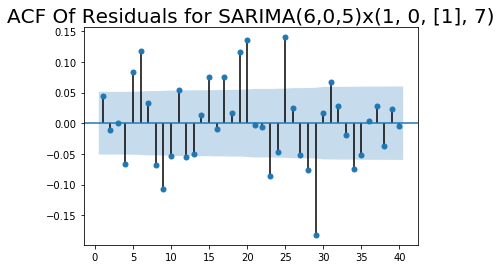

In [281]:
df['results_sar_6_i_0_ma_5'] = np.concatenate(([0], model_auto.resid()))
sgt.plot_acf(df.results_sar_6_i_0_ma_5[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(6,0,5)x(1, 0, [1], 7)",size=20)
plt.show()

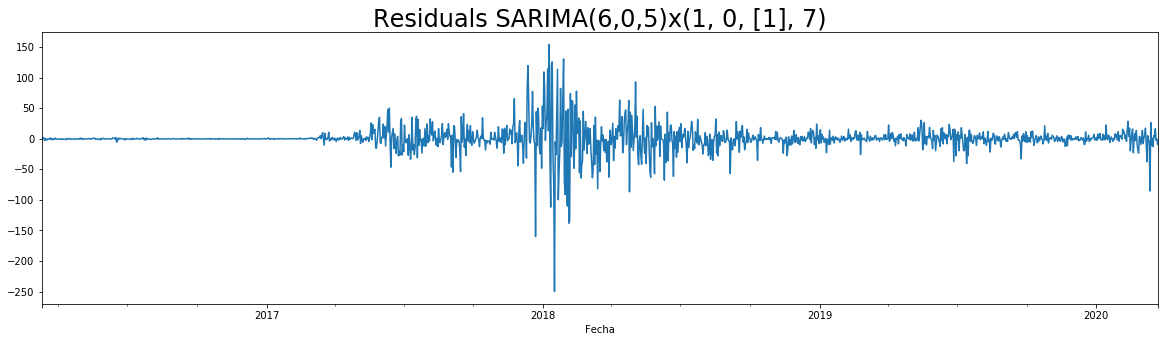

In [282]:
# Plotting residuals
df.results_sar_6_i_0_ma_5.plot(figsize = (20,5))
plt.title("Residuals SARIMA(6,0,5)x(1, 0, [1], 7)", size=24)
plt.show()

In [283]:
# Testing stationarity of residuals
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.results_sar_6_i_0_ma_5)

print("Test-statistic \t\t", test_statistic)
print("P-value \t\t", p_value)
print("\n")
for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Test-statistic 		 -6.1352846778465375
P-value 		 8.215306395446538e-08


Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


In [284]:
forecast_sarima_6_0_5 = results_sar_6_i_0_ma_5.forecast(7)

In [285]:
forecast_sarima_6_0_5

array([-5.53951032,  8.27266853,  5.82036865, -2.76792259, -9.06499584,
       -8.83001521, -4.53705862])

In [289]:
predicitions_sarima_6_0_5 = inverse_difference(df.Cierre, forecast_sarima_6_0_5, interval = 1)

In [586]:
aux_df = pd.DataFrame({"Real_value": df_test['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_6_0_5,2)} \
                        , index = df_test['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-03-23,136.48,116.95
2020-03-24,138.84,125.22
2020-03-25,136.16,131.04
2020-03-26,138.74,128.28
2020-03-27,130.97,119.21
2020-03-28,131.11,110.38
2020-03-29,124.73,105.84


In [588]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(6,0,5)x(1,0,1,7)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [292]:
sqrt(mean_squared_error(predicitions_sarima_6_0_5, df_test['Cierre'][0:7]))

15.246508745477211

In [293]:
model_sar_5_i_0_ma_5 = SARIMAX(differenced, order=(5,0,5), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_5 = model_sar_5_i_0_ma_5.fit()

model_sar_5_i_0_ma_4 = SARIMAX(differenced, order=(5,0,4), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_4 = model_sar_5_i_0_ma_4.fit()

model_sar_4_i_0_ma_5 = SARIMAX(differenced, order=(4,0,5), seasonal_order = (1,0,1,7))
results_sar_4_i_0_ma_5 = model_sar_4_i_0_ma_5.fit()

model_sar_5_i_0_ma_3 = SARIMAX(differenced, order=(5,0,3), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_3 = model_sar_5_i_0_ma_3.fit()

model_sar_3_i_0_ma_5 = SARIMAX(differenced, order=(3,0,5), seasonal_order = (1,0,1,7))
results_sar_3_i_0_ma_5 = model_sar_3_i_0_ma_5.fit()

model_sar_5_i_0_ma_2 = SARIMAX(differenced, order=(5,0,2), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_2 = model_sar_5_i_0_ma_2.fit()

model_sar_2_i_0_ma_5 = SARIMAX(differenced, order=(2,0,5), seasonal_order = (1,0,1,7))
results_sar_2_i_0_ma_5 = model_sar_2_i_0_ma_5.fit()

model_sar_5_i_0_ma_1 = SARIMAX(differenced, order=(5,0,1), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_1 = model_sar_5_i_0_ma_1.fit()

model_sar_1_i_0_ma_5 = SARIMAX(differenced, order=(1,0,5), seasonal_order = (1,0,1,7))
results_sar_1_i_0_ma_5 = model_sar_1_i_0_ma_5.fit()

In [295]:
results_sar_5_i_0_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 5)x(1, 0, [1], 7)   Log Likelihood               -6537.437
Date:                             Wed, 07 Oct 2020   AIC                          13100.875
Time:                                     09:21:42   BIC                          13169.711
Sample:                                          0   HQIC                         13126.542
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3645      0.018     74.489      0.000       1.329       1.400
ar.L2         -0.7144      0.033    -21.598      0.000      -0.779      -0.650
ar.L3         -0.5307      0.040    -13.234      0.000      -0.609      -0.452
ar.L4          1.1763      0.034     34.356      0.000       1.109       1.243
ar.L5         -0.7936      0.021    -37.909      0.000      -0.835      -0.753
ma.L1         -1.3277      0.013    -99.483      0.000      -1.354      -1.302
ma.L2          0.6551      0.025     26.633      0.000       0.607       0.703
ma.L3          0.5966      0.028     21.035      0.000       0.541       0.652
ma.L4         -1.2244      0.025    -48.970      0.000      -1.273      -1.175
ma.L5          0.9164      0.014     66.107      0.000       0.889       0.944
ar.S.L7       -0.8855      0.032    -27.661      0.000      -0.948      -0.823
ma.S.L7        0.7865      0.041     19.002      0.000       0.705       0.868
sigma2       422.3831      5.827     72.491      0.000     410.963     433.803
===================================================================================
Ljung-Box (Q):                      126.67   Jarque-Bera (JB):             26883.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

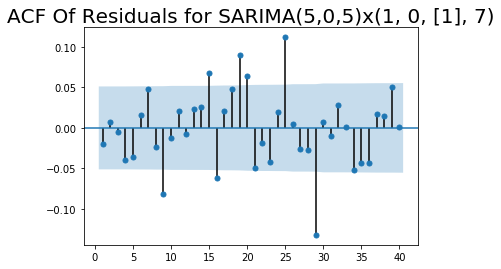

In [305]:
df['res_sar_5_i_0_ma_5'] = np.concatenate(([0], results_sar_5_i_0_ma_5.resid))
sgt.plot_acf(df.res_sar_5_i_0_ma_5[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,5)x(1, 0, [1], 7)",size=20)
plt.show()

In [306]:
results_sar_5_i_0_ma_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 4)x(1, 0, [1], 7)   Log Likelihood               -6591.156
Date:                             Wed, 07 Oct 2020   AIC                          13206.312
Time:                                     15:19:45   BIC                          13269.853
Sample:                                          0   HQIC                         13230.005
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6942      0.081      8.604      0.000       0.536       0.852
ar.L2         -0.1042      0.081     -1.293      0.196      -0.262       0.054
ar.L3          0.1251      0.101      1.233      0.217      -0.074       0.324
ar.L4         -0.7284      0.090     -8.104      0.000      -0.905      -0.552
ar.L5          0.1093      0.012      9.160      0.000       0.086       0.133
ma.L1         -0.6489      0.078     -8.372      0.000      -0.801      -0.497
ma.L2          0.0836      0.083      1.006      0.314      -0.079       0.246
ma.L3         -0.0824      0.102     -0.808      0.419      -0.282       0.118
ma.L4          0.6439      0.091      7.049      0.000       0.465       0.823
ar.S.L7       -0.8289      0.484     -1.713      0.087      -1.777       0.119
ma.S.L7        0.8353      0.477      1.752      0.080      -0.099       1.770
sigma2       452.4564      5.962     75.889      0.000     440.771     464.142
===================================================================================
Ljung-Box (Q):                      239.64   Jarque-Bera (JB):             31595.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [307]:
results_sar_4_i_0_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(4, 0, 5)x(1, 0, [1], 7)   Log Likelihood               -6550.958
Date:                             Wed, 07 Oct 2020   AIC                          13125.915
Time:                                     15:19:56   BIC                          13189.456
Sample:                                          0   HQIC                         13149.608
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1625      0.024     89.086      0.000       2.115       2.210
ar.L2         -2.6038      0.041    -64.020      0.000      -2.684      -2.524
ar.L3          1.9242      0.040     48.397      0.000       1.846       2.002
ar.L4         -0.7494      0.021    -35.249      0.000      -0.791      -0.708
ma.L1         -2.1342      0.028    -76.649      0.000      -2.189      -2.080
ma.L2          2.5833      0.050     51.164      0.000       2.484       2.682
ma.L3         -1.9549      0.057    -34.596      0.000      -2.066      -1.844
ma.L4          0.8143      0.040     20.401      0.000       0.736       0.893
ma.L5          0.0297      0.016      1.848      0.065      -0.002       0.061
ar.S.L7       -0.9036      0.025    -36.608      0.000      -0.952      -0.855
ma.S.L7        0.8119      0.032     25.148      0.000       0.749       0.875
sigma2       407.5975      5.504     74.049      0.000     396.809     418.386
===================================================================================
Ljung-Box (Q):                      128.72   Jarque-Bera (JB):             26721.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

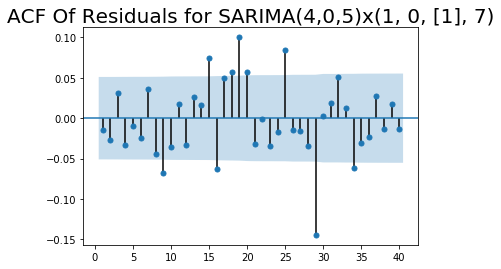

In [308]:
df['res_sar_4_i_0_ma_5'] = np.concatenate(([0], results_sar_4_i_0_ma_5.resid))
sgt.plot_acf(df.res_sar_4_i_0_ma_5[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(4,0,5)x(1, 0, [1], 7)",size=20)
plt.show()

In [309]:
results_sar_5_i_0_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -6593.744
Date:                             Wed, 07 Oct 2020   AIC                          13209.487
Time:                                     15:20:49   BIC                          13267.733
Sample:                                          0   HQIC                         13231.206
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1765      0.113      1.565      0.118      -0.045       0.398
ar.L2         -0.3365      0.108     -3.127      0.002      -0.547      -0.126
ar.L3         -0.6682      0.122     -5.496      0.000      -0.906      -0.430
ar.L4         -0.0015      0.017     -0.090      0.928      -0.035       0.032
ar.L5          0.0132      0.014      0.957      0.339      -0.014       0.040
ma.L1         -0.1310      0.113     -1.155      0.248      -0.353       0.091
ma.L2          0.3167      0.102      3.095      0.002       0.116       0.517
ma.L3          0.7449      0.111      6.728      0.000       0.528       0.962
ar.S.L7       -0.8368      0.111     -7.519      0.000      -1.055      -0.619
ma.S.L7        0.8068      0.118      6.816      0.000       0.575       1.039
sigma2       452.6747      5.654     80.057      0.000     441.592     463.757
===================================================================================
Ljung-Box (Q):                      257.11   Jarque-Bera (JB):             39680.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [310]:
results_sar_3_i_0_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(3, 0, 5)x(1, 0, [1], 7)   Log Likelihood               -6561.925
Date:                             Wed, 07 Oct 2020   AIC                          13145.849
Time:                                     15:20:53   BIC                          13204.095
Sample:                                          0   HQIC                         13167.568
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0653      0.069     15.512      0.000       0.931       1.200
ar.L2         -1.0653      0.046    -22.981      0.000      -1.156      -0.974
ar.L3          0.4110      0.058      7.056      0.000       0.297       0.525
ma.L1         -1.0324      0.069    -14.982      0.000      -1.167      -0.897
ma.L2          1.0530      0.047     22.185      0.000       0.960       1.146
ma.L3         -0.3634      0.063     -5.762      0.000      -0.487      -0.240
ma.L4         -0.1055      0.017     -6.087      0.000      -0.139      -0.072
ma.L5          0.1647      0.013     12.477      0.000       0.139       0.191
ar.S.L7       -0.8727      0.060    -14.650      0.000      -0.989      -0.756
ma.S.L7        0.8265      0.069     12.012      0.000       0.692       0.961
sigma2       432.3648      5.507     78.518      0.000     421.572     443.158
===================================================================================
Ljung-Box (Q):                      154.64   Jarque-Bera (JB):             29079.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

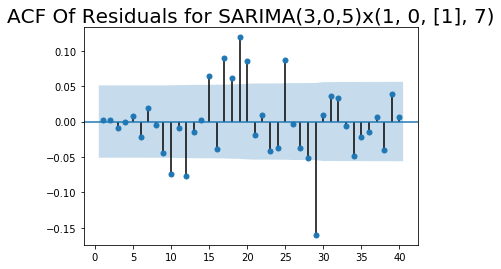

In [311]:
df['res_sar_3_i_0_ma_5'] = np.concatenate(([0], results_sar_3_i_0_ma_5.resid))
sgt.plot_acf(df.res_sar_3_i_0_ma_5[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(3,0,5)x(1, 0, [1], 7)",size=20)
plt.show()

In [312]:
results_sar_5_i_0_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -6566.254
Date:                             Wed, 07 Oct 2020   AIC                          13152.508
Time:                                     15:21:25   BIC                          13205.458
Sample:                                          0   HQIC                         13172.252
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4977      0.016     30.201      0.000       0.465       0.530
ar.L2         -0.8647      0.018    -48.280      0.000      -0.900      -0.830
ar.L3          0.0465      0.016      2.955      0.003       0.016       0.077
ar.L4         -0.0941      0.013     -7.197      0.000      -0.120      -0.068
ar.L5          0.0942      0.012      8.057      0.000       0.071       0.117
ma.L1         -0.4565      0.014    -31.708      0.000      -0.485      -0.428
ma.L2          0.8722      0.018     49.772      0.000       0.838       0.907
ar.S.L7       -0.8941      0.050    -17.748      0.000      -0.993      -0.795
ma.S.L7        0.8538      0.057     15.076      0.000       0.743       0.965
sigma2       435.4785      5.504     79.124      0.000     424.691     446.266
===================================================================================
Ljung-Box (Q):                      168.19   Jarque-Bera (JB):             28849.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

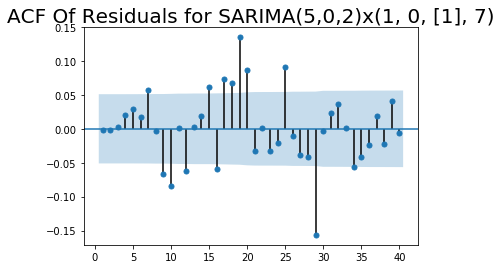

In [313]:
df['res_sar_5_i_0_ma_2'] = np.concatenate(([0], results_sar_5_i_0_ma_2.resid))
sgt.plot_acf(df.res_sar_5_i_0_ma_2[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,2)x(1, 0, [1], 7)",size=20)
plt.show()

In [314]:
results_sar_2_i_0_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(2, 0, 5)x(1, 0, [1], 7)   Log Likelihood               -6565.251
Date:                             Wed, 07 Oct 2020   AIC                          13150.502
Time:                                     15:22:09   BIC                          13203.452
Sample:                                          0   HQIC                         13170.246
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5726      0.015     37.128      0.000       0.542       0.603
ar.L2         -0.8383      0.017    -48.602      0.000      -0.872      -0.804
ma.L1         -0.5371      0.020    -26.938      0.000      -0.576      -0.498
ma.L2          0.8404      0.022     38.715      0.000       0.798       0.883
ma.L3          0.0464      0.016      2.900      0.004       0.015       0.078
ma.L4         -0.1097      0.013     -8.280      0.000      -0.136      -0.084
ma.L5          0.1152      0.012      9.965      0.000       0.093       0.138
ar.S.L7       -0.8904      0.053    -16.789      0.000      -0.994      -0.786
ma.S.L7        0.8511      0.059     14.417      0.000       0.735       0.967
sigma2       433.4292      5.462     79.355      0.000     422.724     444.134
===================================================================================
Ljung-Box (Q):                      163.37   Jarque-Bera (JB):             28617.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

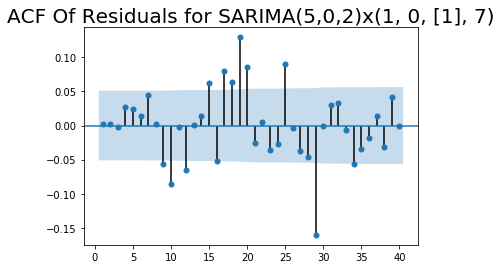

In [315]:
df['res_sar_2_i_0_ma_5'] = np.concatenate(([0], results_sar_2_i_0_ma_5.resid))
sgt.plot_acf(df.res_sar_2_i_0_ma_5[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,2)x(1, 0, [1], 7)",size=20)
plt.show()

In [316]:
results_sar_5_i_0_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -6587.844
Date:                           Wed, 07 Oct 2020   AIC                          13193.688
Time:                                   15:22:43   BIC                          13241.344
Sample:                                        0   HQIC                         13211.458
                                          - 1473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4496      0.074      6.087      0.000       0.305       0.594
ar.L2         -0.0323      0.011     -2.832      0.005      -0.055      -0.010
ar.L3          0.0130      0.011      1.146      0.252      -0.009       0.035
ar.L4         -0.0743      0.011     -6.855      0.000      -0.096      -0.053
ar.L5          0.1358      0.010     13.166      0.000       0.116       0.156
ma.L1         -0.4032      0.073     -5.500      0.000      -0.547      -0.260
ar.S.L7       -0.9286      0.064    -14.572      0.000      -1.053      -0.804
ma.S.L7        0.9091      0.069     13.262      0.000       0.775       1.043
sigma2       448.8803      5.753     78.023      0.000     437.604     460.156
===================================================================================
Ljung-Box (Q):                      212.21   Jarque-Bera (JB):             30538.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [317]:
results_sar_1_i_0_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(1, 0, 5)x(1, 0, [1], 7)   Log Likelihood               -6588.818
Date:                             Wed, 07 Oct 2020   AIC                          13195.636
Time:                                     15:22:47   BIC                          13243.292
Sample:                                          0   HQIC                         13213.406
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4563      0.070      6.501      0.000       0.319       0.594
ma.L1         -0.4242      0.069     -6.180      0.000      -0.559      -0.290
ma.L2         -0.0147      0.011     -1.331      0.183      -0.036       0.007
ma.L3          0.0342      0.010      3.265      0.001       0.014       0.055
ma.L4         -0.0624      0.011     -5.910      0.000      -0.083      -0.042
ma.L5          0.1353      0.011     12.780      0.000       0.115       0.156
ar.S.L7       -0.9279      0.063    -14.750      0.000      -1.051      -0.805
ma.S.L7        0.9079      0.068     13.406      0.000       0.775       1.041
sigma2       449.4818      5.698     78.877      0.000     438.313     460.651
===================================================================================
Ljung-Box (Q):                      221.38   Jarque-Bera (JB):             32868.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [321]:
print("SARIMA(5,0,5)x(1,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5.llf, "\t AIC = ", results_sar_5_i_0_ma_5.aic)
print("SARIMA(4,0,5)x(1,0,1,7):  \t LL = ", results_sar_4_i_0_ma_5.llf, "\t AIC = ", results_sar_4_i_0_ma_5.aic)
print("SARIMA(3,0,5)x(1,0,1,7):  \t LL = ", results_sar_3_i_0_ma_5.llf, "\t AIC = ", results_sar_3_i_0_ma_5.aic)
print("SARIMA(5,0,2)x(1,0,1,7):  \t LL = ", results_sar_5_i_0_ma_2.llf, "\t AIC = ", results_sar_5_i_0_ma_2.aic)
print("SARIMA(2,0,5)x(1,0,1,7):  \t LL = ", results_sar_2_i_0_ma_5.llf, "\t AIC = ", results_sar_2_i_0_ma_5.aic)

SARIMA(5,0,5)x(1,0,1,7):  	 LL =  -6537.437412341728 	 AIC =  13100.874824683457
SARIMA(4,0,5)x(1,0,1,7):  	 LL =  -6550.957529153642 	 AIC =  13125.915058307284
SARIMA(3,0,5)x(1,0,1,7):  	 LL =  -6561.924613135593 	 AIC =  13145.849226271186
SARIMA(5,0,2)x(1,0,1,7):  	 LL =  -6566.253863914184 	 AIC =  13152.507727828368
SARIMA(2,0,5)x(1,0,1,7):  	 LL =  -6565.250964169303 	 AIC =  13150.501928338606


In [322]:
model1 = results_sar_4_i_0_ma_5
model2 = results_sar_5_i_0_ma_5
DF = 1
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,1,7)", model1="SARIMA(4,0,5)x(1,0,1,7)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,1,7)", model1="SARIMA(4,0,5)x(1,0,1,7)"))

LLR test p-value = 0.0
There is enough evidence that SARIMA(5,0,5)x(1,0,1,7) is statiscally significant than SARIMA(4,0,5)x(1,0,1,7)


In [328]:
print("ARIMA(5,0,5):  \t\t\t LL = ", results_ar_5_i_0_ma_5_differenced.llf, "\t AIC = ", results_ar_5_i_0_ma_5_differenced.aic)
print("SARIMA(5,0,5)x(1,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5.llf, "\t AIC = ", results_sar_5_i_0_ma_5.aic)

ARIMA(5,0,5):  			 LL =  -6554.169568649548 	 AIC =  13132.339137299095
SARIMA(5,0,5)x(1,0,1,7):  	 LL =  -6537.437412341728 	 AIC =  13100.874824683457


In [324]:
model1 = results_ar_5_i_0_ma_5_differenced
model2 = results_sar_5_i_0_ma_5
DF = 1
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,1,7)", model1="ARIMA(5,0,5)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,1,7)", model1="ARIMA(5,0,5)"))

LLR test p-value = 0.0
There is enough evidence that SARIMA(5,0,5)x(1,0,1,7) is statiscally significant than ARIMA(5,0,5)


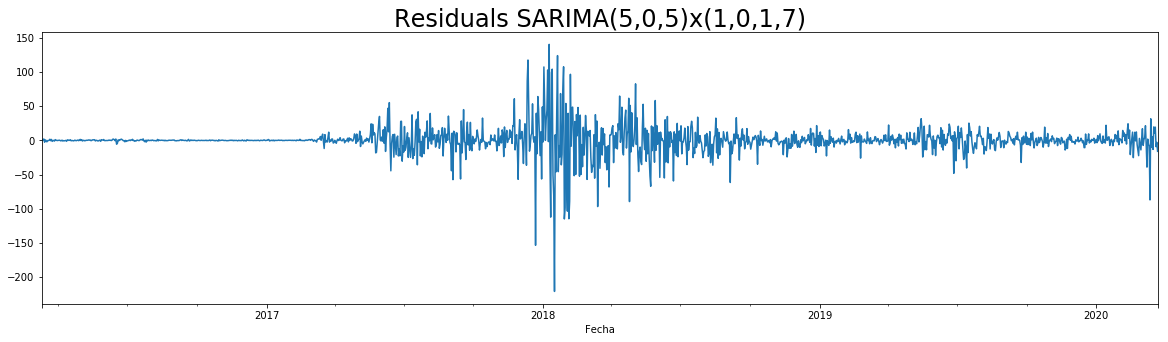

In [737]:
# Plotting residuals
df.res_sar_5_i_0_ma_5.plot(figsize = (20,5))
plt.title("Residuals SARIMA(5,0,5)x(1,0,1,7)", size=24)
plt.show()

In [330]:
# Testing stationarity of residuals
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.res_sar_5_i_0_ma_5)

print("Test-statistic \t\t", test_statistic)
print("P-value \t\t", p_value)
print("\n")
for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Test-statistic 		 -5.870894430093817
P-value 		 3.242231295842592e-07


Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


This show us that residuals are white noise.

In [ ]:
# Here there's a little change forecasting. Here forecast function only returns predicitions.

In [332]:
forecast_sarima_5_0_5 = results_sar_5_i_0_ma_5.forecast(7) 
forecast_sarima_5_0_5

array([-0.48715595, 13.40372635,  8.31185137,  1.77692443, -6.52562139,
       -6.73201234, -6.24781468])

In [333]:
predicitions_sarima_5_0_5 = inverse_difference(df.Cierre, forecast_differenced_5_0_5, interval = 1)
predicitions_sarima_5_0_5

array([119.44053263, 130.63386305, 141.07866635, 148.5437626 ,
       139.18738927, 131.58660917, 126.10798047])

In [334]:
sqrt(mean_squared_error(df_test['Cierre'][0:7].values, predicitions_sarima_5_0_5))

8.845036093098926

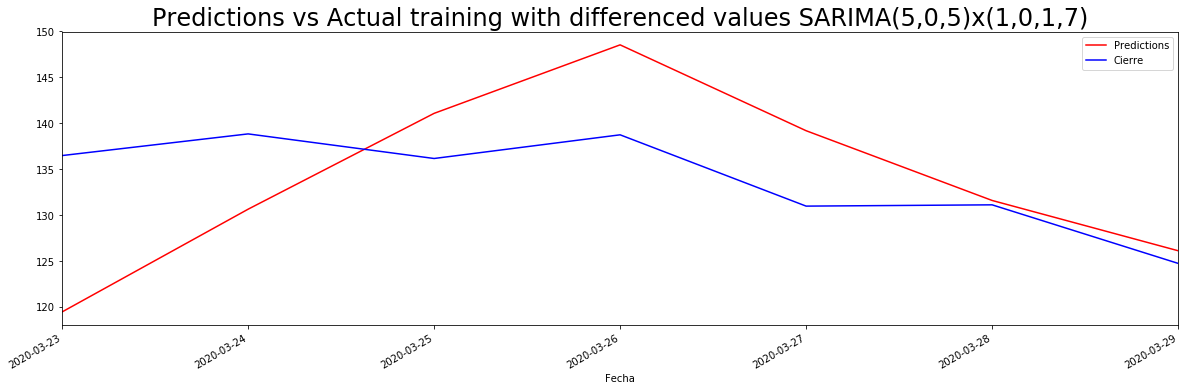

In [335]:
plt.figure(figsize=(20,6))
plt.plot(df_test['Cierre'][0:7].index, predicitions_sarima_5_0_5, color = "red", label="Predictions")
df_test['Cierre'][0:7].plot(color = "blue")
plt.title("Predictions vs Actual training with differenced values SARIMA(5,0,5)x(1,0,1,7)", size = 24)
plt.legend()
plt.show()

In [589]:
aux_df = pd.DataFrame({"Real_value": df_test['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5,2)} \
                        , index = df_test['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-03-23,136.48,119.44
2020-03-24,138.84,130.63
2020-03-25,136.16,141.08
2020-03-26,138.74,148.54
2020-03-27,130.97,139.19
2020-03-28,131.11,131.59
2020-03-29,124.73,126.11


In [591]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

## SARIMA considering 2 ar parameters in the seasonal part

In [336]:
model_sar_5_i_0_ma_5_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,5), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7 = model_sar_5_i_0_ma_5_ar2_i0_ma1_m7.fit()

model_sar_5_i_0_ma_4_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,4), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_4_ar2_i0_ma1_m7 = model_sar_5_i_0_ma_4_ar2_i0_ma1_m7.fit()

model_sar_4_i_0_ma_5_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(4,0,5), seasonal_order = (2,0,1,7))
results_sar_4_i_0_ma_5_ar2_i0_ma1_m7 = model_sar_4_i_0_ma_5_ar2_i0_ma1_m7.fit()

model_sar_5_i_0_ma_3_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,3), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_3_ar2_i0_ma1_m7 = model_sar_5_i_0_ma_3_ar2_i0_ma1_m7.fit()

model_sar_3_i_0_ma_5_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(3,0,5), seasonal_order = (2,0,1,7))
results_sar_3_i_0_ma_5_ar2_i0_ma1_m7 = model_sar_3_i_0_ma_5_ar2_i0_ma1_m7.fit()

model_sar_5_i_0_ma_2_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,2), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_2_ar2_i0_ma1_m7 = model_sar_5_i_0_ma_2_ar2_i0_ma1_m7.fit()

model_sar_2_i_0_ma_5_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(2,0,5), seasonal_order = (2,0,1,7))
results_sar_2_i_0_ma_5_ar2_i0_ma1_m7 = model_sar_2_i_0_ma_5_ar2_i0_ma1_m7.fit()

model_sar_5_i_0_ma_1_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,1), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_1_ar2_i0_ma1_m7 = model_sar_5_i_0_ma_1_ar2_i0_ma1_m7.fit()

model_sar_1_i_0_ma_5_ar2_i0_ma1_m7 = SARIMAX(differenced, order=(1,0,5), seasonal_order = (2,0,1,7))
results_sar_1_i_0_ma_5_ar2_i0_ma1_m7 = model_sar_1_i_0_ma_5_ar2_i0_ma1_m7.fit()

In [338]:
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -6535.937
Date:                             Wed, 07 Oct 2020   AIC                          13099.874
Time:                                     15:56:55   BIC                          13174.005
Sample:                                          0   HQIC                         13127.516
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3788      0.019     72.557      0.000       1.342       1.416
ar.L2         -0.7218      0.039    -18.453      0.000      -0.798      -0.645
ar.L3         -0.5574      0.051    -10.930      0.000      -0.657      -0.457
ar.L4          1.2396      0.043     28.527      0.000       1.154       1.325
ar.L5         -0.8304      0.025    -33.058      0.000      -0.880      -0.781
ma.L1         -1.3446      0.015    -89.816      0.000      -1.374      -1.315
ma.L2          0.6723      0.031     21.880      0.000       0.612       0.733
ma.L3          0.6141      0.037     16.440      0.000       0.541       0.687
ma.L4         -1.2585      0.032    -39.863      0.000      -1.320      -1.197
ma.L5          0.9158      0.017     52.947      0.000       0.882       0.950
ar.S.L7       -0.8011      0.038    -21.215      0.000      -0.875      -0.727
ar.S.L14       0.0824      0.014      6.083      0.000       0.056       0.109
ma.S.L7        0.7901      0.042     18.674      0.000       0.707       0.873
sigma2       424.3260      5.850     72.535      0.000     412.860     435.792
===================================================================================
Ljung-Box (Q):                      126.53   Jarque-Bera (JB):             31591.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

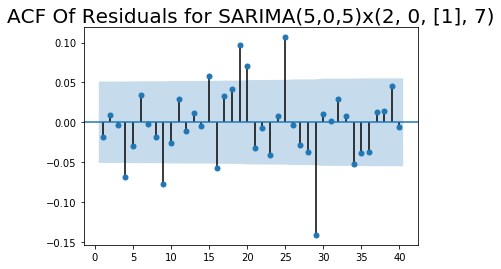

In [345]:
df['res_sar_5_i_0_ma_5_ar2_i0_ma1_m7'] = np.concatenate(([0], results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.resid))
sgt.plot_acf(df.res_sar_5_i_0_ma_5_ar2_i0_ma1_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,5)x(2, 0, [1], 7)",size=20)
plt.show()

In [340]:
results_sar_5_i_0_ma_4_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 4)x(2, 0, [1], 7)   Log Likelihood               -6594.701
Date:                             Wed, 07 Oct 2020   AIC                          13215.402
Time:                                     15:58:12   BIC                          13284.238
Sample:                                          0   HQIC                         13241.069
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2126      0.155      1.376      0.169      -0.090       0.516
ar.L2          0.0549      0.117      0.469      0.639      -0.174       0.284
ar.L3         -0.3091      0.077     -4.018      0.000      -0.460      -0.158
ar.L4         -0.6359      0.115     -5.528      0.000      -0.861      -0.410
ar.L5          0.0514      0.014      3.801      0.000       0.025       0.078
ma.L1         -0.1665      0.152     -1.093      0.274      -0.465       0.132
ma.L2         -0.0813      0.113     -0.722      0.471      -0.302       0.140
ma.L3          0.3593      0.076      4.748      0.000       0.211       0.508
ma.L4          0.6179      0.124      4.980      0.000       0.375       0.861
ar.S.L7       -0.8042      0.095     -8.495      0.000      -0.990      -0.619
ar.S.L14       0.0562      0.012      4.652      0.000       0.033       0.080
ma.S.L7        0.8323      0.096      8.640      0.000       0.643       1.021
sigma2       453.0465      5.858     77.335      0.000     441.565     464.528
===================================================================================
Ljung-Box (Q):                      264.21   Jarque-Bera (JB):             39823.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [341]:
results_sar_4_i_0_ma_5_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(4, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -6556.903
Date:                             Wed, 07 Oct 2020   AIC                          13139.807
Time:                                     15:58:16   BIC                          13208.642
Sample:                                          0   HQIC                         13165.474
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8614      0.048     38.592      0.000       1.767       1.956
ar.L2         -2.1176      0.077    -27.534      0.000      -2.268      -1.967
ar.L3          1.4616      0.072     20.391      0.000       1.321       1.602
ar.L4         -0.5547      0.038    -14.691      0.000      -0.629      -0.481
ma.L1         -1.8316      0.049    -37.200      0.000      -1.928      -1.735
ma.L2          2.1006      0.082     25.600      0.000       1.940       2.261
ma.L3         -1.4725      0.086    -17.138      0.000      -1.641      -1.304
ma.L4          0.5574      0.058      9.605      0.000       0.444       0.671
ma.L5          0.0958      0.021      4.654      0.000       0.055       0.136
ar.S.L7       -0.8341      0.068    -12.180      0.000      -0.968      -0.700
ar.S.L14      -0.0089      0.017     -0.519      0.603      -0.042       0.025
ma.S.L7        0.7408      0.073     10.147      0.000       0.598       0.884
sigma2       403.7529      5.610     71.965      0.000     392.757     414.749
===================================================================================
Ljung-Box (Q):                      137.07   Jarque-Bera (JB):             24172.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [342]:
results_sar_5_i_0_ma_3_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 3)x(2, 0, [1], 7)   Log Likelihood               -6585.764
Date:                             Wed, 07 Oct 2020   AIC                          13195.529
Time:                                     15:58:21   BIC                          13259.070
Sample:                                          0   HQIC                         13219.222
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5486      0.103      5.343      0.000       0.347       0.750
ar.L2         -0.0614      0.133     -0.460      0.645      -0.323       0.200
ar.L3         -0.6863      0.111     -6.168      0.000      -0.904      -0.468
ar.L4          0.0067      0.016      0.408      0.683      -0.026       0.039
ar.L5          0.0475      0.011      4.154      0.000       0.025       0.070
ma.L1         -0.5115      0.102     -5.008      0.000      -0.712      -0.311
ma.L2          0.0324      0.129      0.250      0.802      -0.221       0.286
ma.L3          0.7402      0.101      7.336      0.000       0.542       0.938
ar.S.L7       -0.8358      0.071    -11.809      0.000      -0.975      -0.697
ar.S.L14       0.0455      0.012      3.812      0.000       0.022       0.069
ma.S.L7        0.8492      0.072     11.739      0.000       0.707       0.991
sigma2       441.7545      5.501     80.298      0.000     430.972     452.537
===================================================================================
Ljung-Box (Q):                      224.13   Jarque-Bera (JB):             34404.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [343]:
results_sar_3_i_0_ma_5_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(3, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -6561.140
Date:                             Wed, 07 Oct 2020   AIC                          13146.281
Time:                                     15:58:25   BIC                          13209.822
Sample:                                          0   HQIC                         13169.974
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0315      0.098     10.492      0.000       0.839       1.224
ar.L2         -1.0967      0.059    -18.720      0.000      -1.212      -0.982
ar.L3          0.3885      0.089      4.351      0.000       0.214       0.564
ma.L1         -0.9941      0.099    -10.083      0.000      -1.187      -0.801
ma.L2          1.0865      0.056     19.343      0.000       0.976       1.197
ma.L3         -0.3486      0.090     -3.874      0.000      -0.525      -0.172
ma.L4         -0.0780      0.019     -4.027      0.000      -0.116      -0.040
ma.L5          0.1375      0.014      9.731      0.000       0.110       0.165
ar.S.L7       -0.8001      0.060    -13.410      0.000      -0.917      -0.683
ar.S.L14       0.0526      0.016      3.363      0.001       0.022       0.083
ma.S.L7        0.7913      0.062     12.693      0.000       0.669       0.913
sigma2       432.1242      5.560     77.715      0.000     421.226     443.022
===================================================================================
Ljung-Box (Q):                      157.53   Jarque-Bera (JB):             30780.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

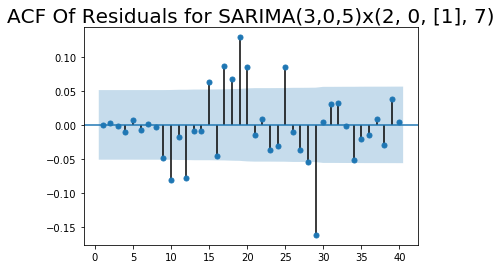

In [344]:
df['res_sar_3_i_0_ma_5_ar2_i0_ma1_m7'] = np.concatenate(([0], results_sar_3_i_0_ma_5_ar2_i0_ma1_m7.resid))
sgt.plot_acf(df.res_sar_3_i_0_ma_5_ar2_i0_ma1_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(3,0,5)x(2, 0, [1], 7)",size=20)
plt.show()

In [346]:
results_sar_5_i_0_ma_2_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 2)x(2, 0, [1], 7)   Log Likelihood               -6561.257
Date:                             Wed, 07 Oct 2020   AIC                          13144.514
Time:                                     15:59:45   BIC                          13202.760
Sample:                                          0   HQIC                         13166.232
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5436      0.015     35.490      0.000       0.514       0.574
ar.L2         -0.8708      0.016    -54.861      0.000      -0.902      -0.840
ar.L3          0.0501      0.017      3.032      0.002       0.018       0.082
ar.L4         -0.0681      0.014     -4.903      0.000      -0.095      -0.041
ar.L5          0.1146      0.012      9.606      0.000       0.091       0.138
ma.L1         -0.5022      0.013    -39.400      0.000      -0.527      -0.477
ma.L2          0.8875      0.014     61.369      0.000       0.859       0.916
ar.S.L7       -0.7519      0.054    -13.845      0.000      -0.858      -0.645
ar.S.L14       0.0961      0.011      8.541      0.000       0.074       0.118
ma.S.L7        0.7867      0.058     13.657      0.000       0.674       0.900
sigma2       429.8627      5.307     80.992      0.000     419.460     440.265
===================================================================================
Ljung-Box (Q):                      171.74   Jarque-Bera (JB):             33913.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

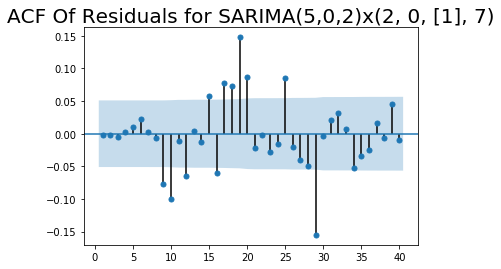

In [347]:
df['res_sar_5_i_0_ma_2_ar2_i0_ma1_m7'] = np.concatenate(([0], results_sar_5_i_0_ma_2_ar2_i0_ma1_m7.resid))
sgt.plot_acf(df.res_sar_5_i_0_ma_2_ar2_i0_ma1_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,2)x(2, 0, [1], 7)",size=20)
plt.show()

In [348]:
results_sar_2_i_0_ma_5_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(2, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -6561.773
Date:                             Wed, 07 Oct 2020   AIC                          13145.546
Time:                                     16:00:40   BIC                          13203.792
Sample:                                          0   HQIC                         13167.264
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6081      0.012     51.389      0.000       0.585       0.631
ar.L2         -0.9095      0.012    -76.581      0.000      -0.933      -0.886
ma.L1         -0.5684      0.017    -33.338      0.000      -0.602      -0.535
ma.L2          0.9199      0.019     49.261      0.000       0.883       0.956
ma.L3          0.0389      0.017      2.221      0.026       0.005       0.073
ma.L4         -0.0617      0.014     -4.296      0.000      -0.090      -0.034
ma.L5          0.1031      0.012      8.651      0.000       0.080       0.126
ar.S.L7       -0.7511      0.055    -13.705      0.000      -0.858      -0.644
ar.S.L14       0.0914      0.012      7.782      0.000       0.068       0.114
ma.S.L7        0.7753      0.058     13.416      0.000       0.662       0.889
sigma2       431.7496      5.387     80.148      0.000     421.191     442.308
===================================================================================
Ljung-Box (Q):                      170.05   Jarque-Bera (JB):             33332.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

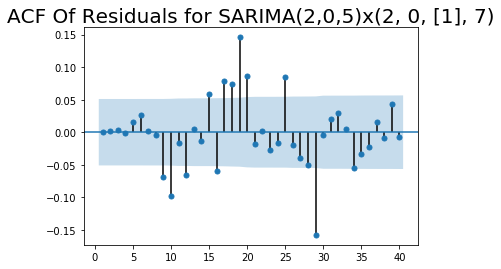

In [349]:
df['res_sar_2_i_0_ma_5_ar2_i0_ma1_m7'] = np.concatenate(([0], results_sar_2_i_0_ma_5_ar2_i0_ma1_m7.resid))
sgt.plot_acf(df.res_sar_2_i_0_ma_5_ar2_i0_ma1_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(2,0,5)x(2, 0, [1], 7)",size=20)
plt.show()

In [350]:
results_sar_5_i_0_ma_1_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -6587.270
Date:                           Wed, 07 Oct 2020   AIC                          13194.540
Time:                                   16:01:28   BIC                          13247.490
Sample:                                        0   HQIC                         13214.283
                                          - 1473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4134      0.107      3.873      0.000       0.204       0.623
ar.L2         -0.0295      0.013     -2.340      0.019      -0.054      -0.005
ar.L3          0.0125      0.012      1.068      0.285      -0.010       0.035
ar.L4         -0.0738      0.011     -6.800      0.000      -0.095      -0.053
ar.L5          0.1330      0.011     12.558      0.000       0.112       0.154
ma.L1         -0.3660      0.107     -3.428      0.001      -0.575      -0.157
ar.S.L7       -0.8755      0.071    -12.309      0.000      -1.015      -0.736
ar.S.L14       0.0313      0.014      2.265      0.024       0.004       0.058
ma.S.L7        0.8821      0.072     12.314      0.000       0.742       1.022
sigma2       448.6016      5.742     78.131      0.000     437.348     459.855
===================================================================================
Ljung-Box (Q):                      216.78   Jarque-Bera (JB):             31832.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [351]:
results_sar_1_i_0_ma_5_ar2_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1473
Model:             SARIMAX(1, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -6588.244
Date:                             Wed, 07 Oct 2020   AIC                          13196.487
Time:                                     16:01:32   BIC                          13249.438
Sample:                                          0   HQIC                         13216.231
                                            - 1473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4300      0.094      4.587      0.000       0.246       0.614
ma.L1         -0.3963      0.092     -4.288      0.000      -0.577      -0.215
ma.L2         -0.0086      0.013     -0.684      0.494      -0.033       0.016
ma.L3          0.0295      0.011      2.613      0.009       0.007       0.052
ma.L4         -0.0607      0.011     -5.375      0.000      -0.083      -0.039
ma.L5          0.1331      0.011     12.470      0.000       0.112       0.154
ar.S.L7       -0.8736      0.070    -12.412      0.000      -1.012      -0.736
ar.S.L14       0.0318      0.014      2.284      0.022       0.005       0.059
ma.S.L7        0.8799      0.071     12.384      0.000       0.741       1.019
sigma2       449.2407      5.713     78.638      0.000     438.044     460.438
===================================================================================
Ljung-Box (Q):                      225.02   Jarque-Bera (JB):             34072.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [353]:
print("SARIMA(5,0,5)x(2,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.aic)
print("SARIMA(3,0,5)x(2,0,1,7):  \t LL = ", results_sar_3_i_0_ma_5_ar2_i0_ma1_m7.llf, "\t AIC = ", results_sar_3_i_0_ma_5_ar2_i0_ma1_m7.aic)
print("SARIMA(2,0,5)x(2,0,1,7):  \t LL = ", results_sar_2_i_0_ma_5_ar2_i0_ma1_m7.llf, "\t AIC = ", results_sar_2_i_0_ma_5_ar2_i0_ma1_m7.aic)
print("SARIMA(5,0,2)x(2,0,1,7):  \t LL = ", results_sar_5_i_0_ma_2_ar2_i0_ma1_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_2_ar2_i0_ma1_m7.aic)

SARIMA(5,0,5)x(2,0,1,7):  	 LL =  -6535.937100626887 	 AIC =  13099.874201253773
SARIMA(3,0,5)x(2,0,1,7):  	 LL =  -6561.1404167943165 	 AIC =  13146.280833588633
SARIMA(2,0,5)x(2,0,1,7):  	 LL =  -6561.773068315428 	 AIC =  13145.546136630855
SARIMA(5,0,2)x(2,0,1,7):  	 LL =  -6561.257072416474 	 AIC =  13144.514144832949


In [354]:
model1 = results_sar_3_i_0_ma_5_ar2_i0_ma1_m7
model2 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7
DF = 2
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,1,7)", model1="SARIMA(3,0,5)x(2,0,1,7)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,1,7)", model1="SARIMA(3,0,5)x(2,0,1,7)"))

LLR test p-value = 0.0
There is enough evidence that SARIMA(5,0,5)x(2,0,1,7) is statiscally significant than SARIMA(3,0,5)x(2,0,1,7)


In [355]:
print("SARIMA(5,0,5)x(1,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5.llf, "\t AIC = ", results_sar_5_i_0_ma_5.aic)
print("SARIMA(5,0,5)x(2,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.aic)

SARIMA(5,0,5)x(1,0,1,7):  	 LL =  -6537.437412341728 	 AIC =  13100.874824683457
SARIMA(5,0,5)x(2,0,1,7):  	 LL =  -6535.937100626887 	 AIC =  13099.874201253773


In [356]:
model1 = results_sar_5_i_0_ma_5
model2 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7
DF = 1
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,1,7)", model1="SARIMA(5,0,5)x(1,0,1,7)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,1,7)", model1="SARIMA(5,0,5)x(1,0,1,7)"))

LLR test p-value = 0.083
There isn't enough evidence that SARIMA(5,0,5)x(2,0,1,7) is statiscally significant than SARIMA(5,0,5)x(1,0,1,7)


There isn´t enough evidence to reject null hypothesis. Nonetheless, since p-value is between a significance level of $\alpha = .05$ and $\alpha = .10$ We are in a twilight zone where we can't make a blunt decision. For this reason lest's take a look of the results that we could obtain prediciting 1 week.

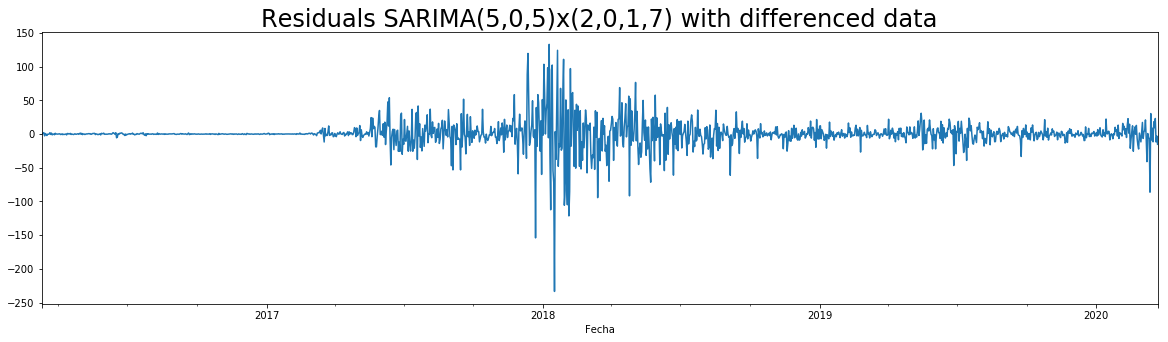

In [358]:
# Plotting residuals
df.res_sar_5_i_0_ma_5_ar2_i0_ma1_m7.plot(figsize = (20,5))
plt.title("Residuals SARIMA(5,0,5)x(2,0,1,7) with differenced data", size=24)
plt.show()

In [359]:
# Testing stationarity of residuals
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df.res_sar_5_i_0_ma_5_ar2_i0_ma1_m7)

print("Test-statistic \t\t", test_statistic)
print("P-value \t\t", p_value)
print("\n")
for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Test-statistic 		 -5.986495392099246
P-value 		 1.7870360528588128e-07


Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


This show us that residuals are white noise.

In [ ]:
# Here there's a little change forecasting. Here forecast function only returns predicitions.

In [360]:
forecast_sarima_5_0_5_ar2_i0_ma1_m7 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.forecast(7) 
forecast_sarima_5_0_5_ar2_i0_ma1_m7

array([-0.30292188, 12.55030867,  7.23785359, -1.01491806, -7.03861133,
       -6.7827531 , -5.42877744])

In [361]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7 = inverse_difference(df.Cierre, forecast_sarima_5_0_5_ar2_i0_ma1_m7, interval = 1)
predicitions_sarima_5_0_5_ar2_i0_ma1_m7

array([122.18707812, 134.73738679, 141.97524039, 140.96032232,
       133.921711  , 127.13895789, 121.71018046])

In [362]:
sqrt(mean_squared_error(df_test['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar2_i0_ma1_m7))

6.474863332499402

In [592]:
aux_df = pd.DataFrame({"Real_value": df_test['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7,2)} \
                        , index = df_test['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-03-23,136.48,122.19
2020-03-24,138.84,134.74
2020-03-25,136.16,141.98
2020-03-26,138.74,140.96
2020-03-27,130.97,133.92
2020-03-28,131.11,127.14
2020-03-29,124.73,121.71


In [593]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(2,0,1,7)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

## SARIMA considering 2 ma parameters in the seasonal part

In [365]:
model_sar_5_i_0_ma_5_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,5), seasonal_order = (1,0,2,7))
results_sar_5_i_0_ma_5_ar1_i0_ma2_m7 = model_sar_5_i_0_ma_5_ar1_i0_ma2_m7.fit()

model_sar_5_i_0_ma_4_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,4), seasonal_order = (1,0,2,7))
results_sar_5_i_0_ma_4_ar1_i0_ma2_m7 = model_sar_5_i_0_ma_4_ar1_i0_ma2_m7.fit()

model_sar_4_i_0_ma_5_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(4,0,5), seasonal_order = (1,0,2,7))
results_sar_4_i_0_ma_5_ar1_i0_ma2_m7 = model_sar_4_i_0_ma_5_ar1_i0_ma2_m7.fit()

model_sar_5_i_0_ma_3_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,3), seasonal_order = (1,0,2,7))
results_sar_5_i_0_ma_3_ar1_i0_ma2_m7 = model_sar_5_i_0_ma_3_ar1_i0_ma2_m7.fit()

model_sar_3_i_0_ma_5_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(3,0,5), seasonal_order = (1,0,2,7))
results_sar_3_i_0_ma_5_ar1_i0_ma2_m7 = model_sar_3_i_0_ma_5_ar1_i0_ma2_m7.fit()

model_sar_5_i_0_ma_2_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,2), seasonal_order = (1,0,2,7))
results_sar_5_i_0_ma_2_ar1_i0_ma2_m7 = model_sar_5_i_0_ma_2_ar1_i0_ma2_m7.fit()

model_sar_2_i_0_ma_5_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(2,0,5), seasonal_order = (1,0,2,7))
results_sar_2_i_0_ma_5_ar1_i0_ma2_m7 = model_sar_2_i_0_ma_5_ar1_i0_ma2_m7.fit()

model_sar_5_i_0_ma_1_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,1), seasonal_order = (1,0,2,7))
results_sar_5_i_0_ma_1_ar1_i0_ma2_m7 = model_sar_5_i_0_ma_1_ar1_i0_ma2_m7.fit()

model_sar_1_i_0_ma_5_ar1_i0_ma2_m7 = SARIMAX(differenced, order=(1,0,5), seasonal_order = (1,0,2,7))
results_sar_1_i_0_ma_5_ar1_i0_ma2_m7 = model_sar_1_i_0_ma_5_ar1_i0_ma2_m7.fit()

In [366]:
results_sar_5_i_0_ma_5_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 5)x(1, 0, [1, 2], 7)   Log Likelihood               -6540.511
Date:                                Wed, 07 Oct 2020   AIC                          13109.023
Time:                                        16:51:47   BIC                          13183.153
Sample:                                             0   HQIC                         13136.664
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2532      0.022     58.272      0.000       1.211       1.295
ar.L2         -0.5727      0.040    -14.450      0.000      -0.650      -0.495
ar.L3         -0.4815      0.053     -9.061      0.000      -0.586      -0.377
ar.L4          0.9515      0.055     17.172      0.000       0.843       1.060
ar.L5         -0.6426      0.035    -18.374      0.000      -0.711      -0.574
ma.L1         -1.2077      0.018    -68.972      0.000      -1.242      -1.173
ma.L2          0.5470      0.032     16.893      0.000       0.484       0.610
ma.L3          0.5048      0.042     12.103      0.000       0.423       0.587
ma.L4         -1.0262      0.045    -22.580      0.000      -1.115      -0.937
ma.L5          0.8336      0.026     32.096      0.000       0.783       0.884
ar.S.L7       -0.6331      0.068     -9.320      0.000      -0.766      -0.500
ma.S.L7        0.5249      0.073      7.157      0.000       0.381       0.669
ma.S.L14       0.0657      0.015      4.319      0.000       0.036       0.095
sigma2       427.8546      6.103     70.105      0.000     415.893     439.816
===================================================================================
Ljung-Box (Q):                      112.47   Jarque-Bera (JB):             27444.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

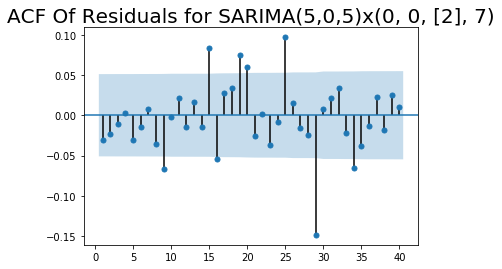

In [367]:
df['res_sar_5_i_0_ma_5_ar1_i0_ma2_m7'] = np.concatenate(([0], results_sar_5_i_0_ma_5_ar1_i0_ma2_m7.resid))
sgt.plot_acf(df.res_sar_5_i_0_ma_5_ar1_i0_ma2_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,5)x(0, 0, [2], 7)",size=20)
plt.show()

In [368]:
results_sar_5_i_0_ma_4_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 4)x(1, 0, [1, 2], 7)   Log Likelihood               -6596.693
Date:                                Wed, 07 Oct 2020   AIC                          13219.386
Time:                                        16:52:49   BIC                          13288.222
Sample:                                             0   HQIC                         13245.053
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1966      0.124      1.588      0.112      -0.046       0.439
ar.L2          0.0389      0.096      0.405      0.685      -0.149       0.227
ar.L3         -0.2816      0.064     -4.384      0.000      -0.407      -0.156
ar.L4         -0.6631      0.087     -7.627      0.000      -0.834      -0.493
ar.L5          0.0451      0.014      3.136      0.002       0.017       0.073
ma.L1         -0.1648      0.122     -1.355      0.175      -0.403       0.074
ma.L2         -0.0689      0.094     -0.730      0.465      -0.254       0.116
ma.L3          0.3420      0.064      5.380      0.000       0.217       0.467
ma.L4          0.6317      0.096      6.563      0.000       0.443       0.820
ar.S.L7       -0.3118      0.383     -0.813      0.416      -1.063       0.440
ma.S.L7        0.3408      0.384      0.887      0.375      -0.412       1.094
ma.S.L14       0.0342      0.015      2.280      0.023       0.005       0.064
sigma2       452.8415      5.961     75.963      0.000     441.157     464.526
===================================================================================
Ljung-Box (Q):                      265.16   Jarque-Bera (JB):             41755.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [369]:
results_sar_4_i_0_ma_5_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(4, 0, 5)x(1, 0, [1, 2], 7)   Log Likelihood               -6547.071
Date:                                Wed, 07 Oct 2020   AIC                          13120.142
Time:                                        16:52:54   BIC                          13188.978
Sample:                                             0   HQIC                         13145.809
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2159      0.023     96.329      0.000       2.171       2.261
ar.L2         -2.6911      0.039    -69.259      0.000      -2.767      -2.615
ar.L3          2.0190      0.038     53.729      0.000       1.945       2.093
ar.L4         -0.8068      0.020    -40.890      0.000      -0.845      -0.768
ma.L1         -2.1848      0.026    -82.890      0.000      -2.236      -2.133
ma.L2          2.6827      0.048     55.592      0.000       2.588       2.777
ma.L3         -2.0762      0.055    -37.971      0.000      -2.183      -1.969
ma.L4          0.9027      0.039     23.010      0.000       0.826       0.980
ma.L5          0.0046      0.016      0.285      0.776      -0.027       0.036
ar.S.L7       -0.8720      0.029    -30.074      0.000      -0.929      -0.815
ma.S.L7        0.8447      0.035     24.312      0.000       0.777       0.913
ma.S.L14       0.0865      0.012      7.323      0.000       0.063       0.110
sigma2       395.8926      5.044     78.483      0.000     386.006     405.779
===================================================================================
Ljung-Box (Q):                      119.06   Jarque-Bera (JB):             28819.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [370]:
results_sar_5_i_0_ma_3_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 3)x(1, 0, [1, 2], 7)   Log Likelihood               -6588.225
Date:                                Wed, 07 Oct 2020   AIC                          13200.450
Time:                                        16:52:59   BIC                          13263.991
Sample:                                             0   HQIC                         13224.143
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5474      0.097      5.669      0.000       0.358       0.737
ar.L2         -0.0669      0.125     -0.534      0.593      -0.312       0.178
ar.L3         -0.6757      0.105     -6.463      0.000      -0.881      -0.471
ar.L4         -0.0040      0.016     -0.241      0.810      -0.036       0.028
ar.L5          0.0507      0.012      4.359      0.000       0.028       0.074
ma.L1         -0.5168      0.096     -5.375      0.000      -0.705      -0.328
ma.L2          0.0393      0.122      0.322      0.747      -0.200       0.279
ma.L3          0.7347      0.095      7.721      0.000       0.548       0.921
ar.S.L7       -0.3278      0.240     -1.367      0.172      -0.798       0.142
ma.S.L7        0.3363      0.241      1.396      0.163      -0.136       0.808
ma.S.L14       0.0400      0.011      3.567      0.000       0.018       0.062
sigma2       444.9237      5.682     78.309      0.000     433.788     456.059
===================================================================================
Ljung-Box (Q):                      226.56   Jarque-Bera (JB):             36120.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [371]:
results_sar_3_i_0_ma_5_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(3, 0, 5)x(1, 0, [1, 2], 7)   Log Likelihood               -6561.315
Date:                                Wed, 07 Oct 2020   AIC                          13146.631
Time:                                        16:53:03   BIC                          13210.171
Sample:                                             0   HQIC                         13170.324
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0862      0.093     11.690      0.000       0.904       1.268
ar.L2         -1.1360      0.056    -20.149      0.000      -1.247      -1.026
ar.L3          0.4378      0.085      5.164      0.000       0.272       0.604
ma.L1         -1.0472      0.093    -11.242      0.000      -1.230      -0.865
ma.L2          1.1233      0.054     20.768      0.000       1.017       1.229
ma.L3         -0.4028      0.086     -4.706      0.000      -0.571      -0.235
ma.L4         -0.0668      0.020     -3.346      0.001      -0.106      -0.028
ma.L5          0.1302      0.014      8.989      0.000       0.102       0.159
ar.S.L7       -0.8370      0.057    -14.664      0.000      -0.949      -0.725
ma.S.L7        0.8333      0.063     13.230      0.000       0.710       0.957
ma.S.L14       0.0564      0.015      3.675      0.000       0.026       0.086
sigma2       428.0486      5.418     79.008      0.000     417.430     438.667
===================================================================================
Ljung-Box (Q):                      158.99   Jarque-Bera (JB):             31122.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

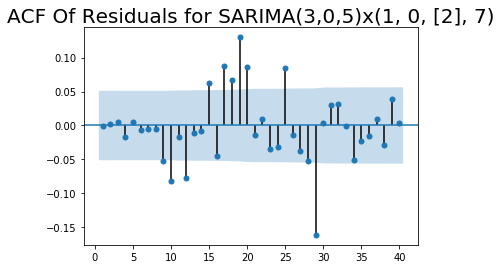

In [372]:
df['res_sar_3_i_0_ma_5_ar1_i0_ma2_m7'] = np.concatenate(([0], results_sar_3_i_0_ma_5_ar1_i0_ma2_m7.resid))
sgt.plot_acf(df.res_sar_3_i_0_ma_5_ar1_i0_ma2_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(3,0,5)x(1, 0, [2], 7)",size=20)
plt.show()

In [373]:
results_sar_5_i_0_ma_2_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 2)x(1, 0, 2, 7)   Log Likelihood               -6562.308
Date:                           Wed, 07 Oct 2020   AIC                          13146.615
Time:                                   16:54:15   BIC                          13204.861
Sample:                                        0   HQIC                         13168.334
                                          - 1473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5091      0.016     32.491      0.000       0.478       0.540
ar.L2         -0.8588      0.016    -54.818      0.000      -0.890      -0.828
ar.L3          0.0249      0.017      1.481      0.139      -0.008       0.058
ar.L4         -0.0648      0.014     -4.526      0.000      -0.093      -0.037
ar.L5          0.1029      0.012      8.455      0.000       0.079       0.127
ma.L1         -0.4885      0.012    -39.991      0.000      -0.512      -0.465
ma.L2          0.8976      0.014     63.289      0.000       0.870       0.925
ar.S.L7       -0.7948      0.058    -13.691      0.000      -0.909      -0.681
ma.S.L7        0.8168      0.063     13.068      0.000       0.694       0.939
ma.S.L14       0.0967      0.011      8.418      0.000       0.074       0.119
sigma2       434.8139      5.583     77.884      0.000     423.872     445.756
===================================================================================
Ljung-Box (Q):                      173.27   Jarque-Bera (JB):             35045.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [374]:
results_sar_2_i_0_ma_5_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(2, 0, 5)x(1, 0, [1, 2], 7)   Log Likelihood               -6561.650
Date:                                Wed, 07 Oct 2020   AIC                          13145.301
Time:                                        16:54:19   BIC                          13203.546
Sample:                                             0   HQIC                         13167.019
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6139      0.011     56.336      0.000       0.593       0.635
ar.L2         -0.9205      0.011    -84.819      0.000      -0.942      -0.899
ma.L1         -0.5725      0.016    -35.071      0.000      -0.604      -0.540
ma.L2          0.9298      0.018     51.744      0.000       0.895       0.965
ma.L3          0.0408      0.017      2.361      0.018       0.007       0.075
ma.L4         -0.0549      0.014     -3.822      0.000      -0.083      -0.027
ma.L5          0.1023      0.012      8.738      0.000       0.079       0.125
ar.S.L7       -0.8397      0.049    -17.103      0.000      -0.936      -0.743
ma.S.L7        0.8734      0.053     16.424      0.000       0.769       0.978
ma.S.L14       0.0972      0.011      8.475      0.000       0.075       0.120
sigma2       426.1247      5.244     81.258      0.000     415.846     436.403
===================================================================================
Ljung-Box (Q):                      172.97   Jarque-Bera (JB):             33699.80
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

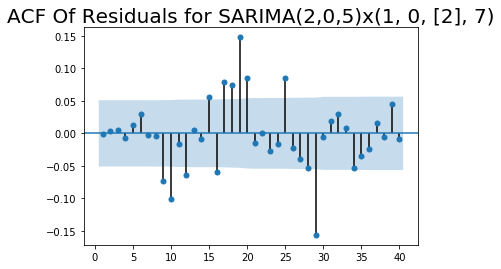

In [376]:
df['res_sar_2_i_0_ma_5_ar1_i0_ma2_m7'] = np.concatenate(([0], results_sar_2_i_0_ma_5_ar1_i0_ma2_m7.resid))
sgt.plot_acf(df.res_sar_2_i_0_ma_5_ar1_i0_ma2_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(2,0,5)x(1, 0, [2], 7)",size=20)
plt.show()

In [377]:
results_sar_5_i_0_ma_1_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -6589.338
Date:                                Wed, 07 Oct 2020   AIC                          13198.676
Time:                                        16:55:28   BIC                          13251.627
Sample:                                             0   HQIC                         13218.420
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4203      0.104      4.028      0.000       0.216       0.625
ar.L2         -0.0294      0.012     -2.358      0.018      -0.054      -0.005
ar.L3          0.0186      0.012      1.567      0.117      -0.005       0.042
ar.L4         -0.0820      0.011     -7.506      0.000      -0.103      -0.061
ar.L5          0.1357      0.011     12.545      0.000       0.115       0.157
ma.L1         -0.3775      0.104     -3.616      0.000      -0.582      -0.173
ar.S.L7       -0.3762      0.387     -0.971      0.331      -1.135       0.383
ma.S.L7        0.3798      0.389      0.977      0.329      -0.382       1.142
ma.S.L14       0.0237      0.011      2.084      0.037       0.001       0.046
sigma2       449.7750      5.813     77.380      0.000     438.383     461.167
===================================================================================
Ljung-Box (Q):                      217.80   Jarque-Bera (JB):             32736.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [378]:
results_sar_1_i_0_ma_5_ar1_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(1, 0, 5)x(1, 0, [1, 2], 7)   Log Likelihood               -6590.311
Date:                                Wed, 07 Oct 2020   AIC                          13200.622
Time:                                        16:55:34   BIC                          13253.573
Sample:                                             0   HQIC                         13220.366
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4340      0.094      4.615      0.000       0.250       0.618
ma.L1         -0.4053      0.093     -4.376      0.000      -0.587      -0.224
ma.L2         -0.0066      0.013     -0.524      0.601      -0.031       0.018
ma.L3          0.0332      0.012      2.874      0.004       0.011       0.056
ma.L4         -0.0695      0.011     -6.063      0.000      -0.092      -0.047
ma.L5          0.1351      0.011     12.696      0.000       0.114       0.156
ar.S.L7       -0.3725      0.343     -1.087      0.277      -1.044       0.299
ma.S.L7        0.3753      0.345      1.087      0.277      -0.301       1.052
ma.S.L14       0.0267      0.011      2.378      0.017       0.005       0.049
sigma2       450.4152      5.781     77.909      0.000     439.084     461.746
===================================================================================
Ljung-Box (Q):                      225.93   Jarque-Bera (JB):             35317.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [380]:
print("SARIMA(5,0,5)x(1,0,2,7):  \t LL = ", results_sar_5_i_0_ma_5_ar1_i0_ma2_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_5_ar1_i0_ma2_m7.aic)
print("SARIMA(3,0,5)x(1,0,2,7):  \t LL = ", results_sar_3_i_0_ma_5_ar1_i0_ma2_m7.llf, "\t AIC = ", results_sar_3_i_0_ma_5_ar1_i0_ma2_m7.aic)
print("SARIMA(2,0,5)x(1,0,2,7):  \t LL = ", results_sar_2_i_0_ma_5_ar1_i0_ma2_m7.llf, "\t AIC = ", results_sar_2_i_0_ma_5_ar1_i0_ma2_m7.aic)

SARIMA(5,0,5)x(1,0,2,7):  	 LL =  -6540.511334180772 	 AIC =  13109.022668361544
SARIMA(3,0,5)x(1,0,2,7):  	 LL =  -6561.315392325453 	 AIC =  13146.630784650906
SARIMA(2,0,5)x(1,0,2,7):  	 LL =  -6561.650412668356 	 AIC =  13145.300825336712


In [615]:
model1 = results_sar_3_i_0_ma_5_ar1_i0_ma2_m7
model2 = results_sar_5_i_0_ma_5_ar1_i0_ma2_m7
DF = 2
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,2,7)", model1="SARIMA(3,0,5)x(2,0,1,7)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,2,7)", model1="SARIMA(3,0,5)x(2,0,1,7)"))


LLR test p-value = 0.0
There is enough evidence that SARIMA(5,0,5)x(1,0,2,7) is statiscally significant than SARIMA(3,0,5)x(2,0,1,7)


In [382]:
print("SARIMA(5,0,5)x(1,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5.llf, "\t AIC = ", results_sar_5_i_0_ma_5.aic)
print("SARIMA(5,0,5)x(1,0,2,7):  \t LL = ", results_sar_5_i_0_ma_5_ar1_i0_ma2_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_5_ar1_i0_ma2_m7.aic)

SARIMA(5,0,5)x(1,0,1,7):  	 LL =  -6537.437412341728 	 AIC =  13100.874824683457
SARIMA(5,0,5)x(1,0,2,7):  	 LL =  -6540.511334180772 	 AIC =  13109.022668361544


In [383]:
model1 = results_sar_5_i_0_ma_5
model2 = results_sar_5_i_0_ma_5_ar1_i0_ma2_m7
DF = 1
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,2,7)", model1="SARIMA(5,0,5)x(1,0,1,7)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(1,0,2,7)", model1="SARIMA(5,0,5)x(1,0,1,7)"))


LLR test p-value = 1.0
There isn't enough evidence that SARIMA(5,0,5)x(1,0,2,7) is statiscally significant than SARIMA(5,0,5)x(1,0,1,7)


## SARIMA considering 2 ar & 2 ma parameters in the seasonal component

In [384]:
model_sar_5_i_0_ma_5_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,5), seasonal_order = (2,0,2,7))
results_sar_5_i_0_ma_5_ar2_i0_ma2_m7 = model_sar_5_i_0_ma_5_ar2_i0_ma2_m7.fit()

model_sar_5_i_0_ma_4_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,4), seasonal_order = (2,0,2,7))
results_sar_5_i_0_ma_4_ar2_i0_ma2_m7 = model_sar_5_i_0_ma_4_ar2_i0_ma2_m7.fit()

model_sar_4_i_0_ma_5_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(4,0,5), seasonal_order = (2,0,2,7))
results_sar_4_i_0_ma_5_ar2_i0_ma2_m7 = model_sar_4_i_0_ma_5_ar2_i0_ma2_m7.fit()

model_sar_5_i_0_ma_3_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,3), seasonal_order = (2,0,2,7))
results_sar_5_i_0_ma_3_ar2_i0_ma2_m7 = model_sar_5_i_0_ma_3_ar2_i0_ma2_m7.fit()

model_sar_3_i_0_ma_5_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(3,0,5), seasonal_order = (2,0,2,7))
results_sar_3_i_0_ma_5_ar2_i0_ma2_m7 = model_sar_3_i_0_ma_5_ar2_i0_ma2_m7.fit()

model_sar_5_i_0_ma_2_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,2), seasonal_order = (2,0,2,7))
results_sar_5_i_0_ma_2_ar2_i0_ma2_m7 = model_sar_5_i_0_ma_2_ar2_i0_ma2_m7.fit()

model_sar_2_i_0_ma_5_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(2,0,5), seasonal_order = (2,0,2,7))
results_sar_2_i_0_ma_5_ar2_i0_ma2_m7 = model_sar_2_i_0_ma_5_ar2_i0_ma2_m7.fit()

model_sar_5_i_0_ma_1_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(5,0,1), seasonal_order = (2,0,2,7))
results_sar_5_i_0_ma_1_ar2_i0_ma2_m7 = model_sar_5_i_0_ma_1_ar2_i0_ma2_m7.fit()

model_sar_1_i_0_ma_5_ar2_i0_ma2_m7 = SARIMAX(differenced, order=(1,0,5), seasonal_order = (2,0,2,7))
results_sar_1_i_0_ma_5_ar2_i0_ma2_m7 = model_sar_1_i_0_ma_5_ar2_i0_ma2_m7.fit()

In [385]:
results_sar_5_i_0_ma_5_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 5)x(2, 0, [1, 2], 7)   Log Likelihood               -6535.377
Date:                                Wed, 07 Oct 2020   AIC                          13100.754
Time:                                        17:09:29   BIC                          13180.180
Sample:                                             0   HQIC                         13130.370
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3860      0.021     65.427      0.000       1.344       1.428
ar.L2         -0.7355      0.043    -17.260      0.000      -0.819      -0.652
ar.L3         -0.5317      0.053     -9.972      0.000      -0.636      -0.427
ar.L4          1.1854      0.044     26.688      0.000       1.098       1.272
ar.L5         -0.8053      0.024    -32.909      0.000      -0.853      -0.757
ma.L1         -1.3394      0.017    -81.103      0.000      -1.372      -1.307
ma.L2          0.6668      0.033     19.971      0.000       0.601       0.732
ma.L3          0.5879      0.039     15.006      0.000       0.511       0.665
ma.L4         -1.2106      0.033    -36.734      0.000      -1.275      -1.146
ma.L5          0.9074      0.017     53.086      0.000       0.874       0.941
ar.S.L7       -0.3972      0.176     -2.259      0.024      -0.742      -0.053
ar.S.L14       0.3647      0.155      2.349      0.019       0.060       0.669
ma.S.L7        0.3476      0.185      1.883      0.060      -0.014       0.709
ma.S.L14      -0.2607      0.146     -1.781      0.075      -0.548       0.026
sigma2       424.6178      5.941     71.470      0.000     412.973     436.262
===================================================================================
Ljung-Box (Q):                      124.48   Jarque-Bera (JB):             30276.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

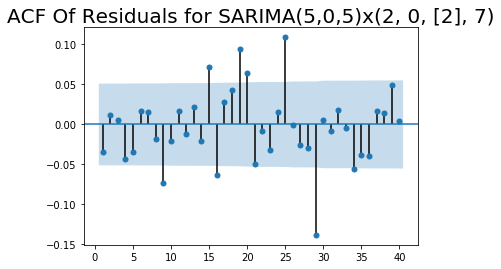

In [386]:
df['res_sar_5_i_0_ma_5_ar2_i0_ma2_m7'] = np.concatenate(([0], results_sar_5_i_0_ma_5_ar2_i0_ma2_m7.resid))
sgt.plot_acf(df.res_sar_5_i_0_ma_5_ar2_i0_ma2_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,5)x(2, 0, [2], 7)",size=20)
plt.show()

In [387]:
results_sar_5_i_0_ma_4_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 4)x(2, 0, [1, 2], 7)   Log Likelihood               -6579.060
Date:                                Wed, 07 Oct 2020   AIC                          13186.119
Time:                                        17:10:38   BIC                          13260.250
Sample:                                             0   HQIC                         13213.761
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7034      0.027     26.104      0.000       0.651       0.756
ar.L2          0.0567      0.025      2.226      0.026       0.007       0.107
ar.L3          0.4035      0.024     17.046      0.000       0.357       0.450
ar.L4         -0.9779      0.018    -53.352      0.000      -1.014      -0.942
ar.L5          0.1445      0.014     10.499      0.000       0.118       0.172
ma.L1         -0.6259      0.026    -23.772      0.000      -0.678      -0.574
ma.L2         -0.0923      0.028     -3.272      0.001      -0.148      -0.037
ma.L3         -0.3447      0.031    -11.132      0.000      -0.405      -0.284
ma.L4          0.8357      0.027     30.474      0.000       0.782       0.889
ar.S.L7       -0.4055     34.711     -0.012      0.991     -68.438      67.627
ar.S.L14       0.0076     14.887      0.001      1.000     -29.171      29.186
ma.S.L7        0.5239     34.710      0.015      0.988     -67.507      68.555
ma.S.L14      -0.0106     19.002     -0.001      1.000     -37.254      37.233
sigma2       443.6037      7.175     61.831      0.000     429.542     457.665
===================================================================================
Ljung-Box (Q):                      219.62   Jarque-Bera (JB):             30992.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [388]:
results_sar_4_i_0_ma_5_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(4, 0, 5)x(2, 0, [1, 2], 7)   Log Likelihood               -6556.269
Date:                                Wed, 07 Oct 2020   AIC                          13140.537
Time:                                        17:10:44   BIC                          13214.668
Sample:                                             0   HQIC                         13168.179
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9792      0.036     54.282      0.000       1.908       2.051
ar.L2         -2.2806      0.060    -38.246      0.000      -2.398      -2.164
ar.L3          1.6546      0.054     30.568      0.000       1.549       1.761
ar.L4         -0.6796      0.028    -24.148      0.000      -0.735      -0.624
ma.L1         -1.9579      0.038    -51.209      0.000      -2.033      -1.883
ma.L2          2.2995      0.064     35.666      0.000       2.173       2.426
ma.L3         -1.7242      0.065    -26.340      0.000      -1.852      -1.596
ma.L4          0.7551      0.043     17.468      0.000       0.670       0.840
ma.L5          0.0374      0.017      2.201      0.028       0.004       0.071
ar.S.L7       -0.1585      0.094     -1.682      0.093      -0.343       0.026
ar.S.L14       0.8107      0.085      9.544      0.000       0.644       0.977
ma.S.L7        0.1193      0.093      1.287      0.198      -0.062       0.301
ma.S.L14      -0.8305      0.081    -10.237      0.000      -0.989      -0.671
sigma2       417.0705      5.989     69.642      0.000     405.333     428.808
===================================================================================
Ljung-Box (Q):                      155.67   Jarque-Bera (JB):             25056.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.27   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

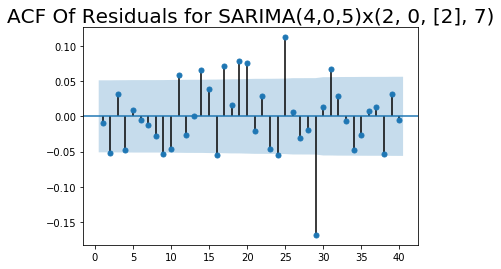

In [389]:
df['res_sar_4_i_0_ma_5_ar2_i0_ma2_m7'] = np.concatenate(([0], results_sar_4_i_0_ma_5_ar2_i0_ma2_m7.resid))
sgt.plot_acf(df.res_sar_4_i_0_ma_5_ar2_i0_ma2_m7[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(4,0,5)x(2, 0, [2], 7)",size=20)
plt.show()

In [390]:
results_sar_5_i_0_ma_3_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -6591.601
Date:                                Wed, 07 Oct 2020   AIC                          13209.202
Time:                                        17:11:15   BIC                          13278.038
Sample:                                             0   HQIC                         13234.869
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0576      0.037      1.564      0.118      -0.015       0.130
ar.L2         -0.2050      0.032     -6.322      0.000      -0.269      -0.141
ar.L3         -0.8229      0.039    -21.221      0.000      -0.899      -0.747
ar.L4          0.0347      0.012      2.864      0.004       0.011       0.058
ar.L5          0.0191      0.012      1.578      0.115      -0.005       0.043
ma.L1          0.0153      0.034      0.453      0.651      -0.051       0.082
ma.L2          0.1947      0.031      6.352      0.000       0.135       0.255
ma.L3          0.9004      0.033     27.274      0.000       0.836       0.965
ar.S.L7       -0.4348    280.662     -0.002      0.999    -550.521     549.652
ar.S.L14       0.1600    188.548      0.001      0.999    -369.387     369.707
ma.S.L7        0.4005    280.660      0.001      0.999    -549.682     550.483
ma.S.L14      -0.1519    178.931     -0.001      0.999    -350.850     350.546
sigma2       453.7377      6.441     70.445      0.000     441.114     466.362
===================================================================================
Ljung-Box (Q):                      250.51   Jarque-Bera (JB):             36832.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                            -0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [391]:
results_sar_3_i_0_ma_5_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(3, 0, 5)x(2, 0, [1, 2], 7)   Log Likelihood               -6561.884
Date:                                Wed, 07 Oct 2020   AIC                          13149.769
Time:                                        17:11:20   BIC                          13218.604
Sample:                                             0   HQIC                         13175.436
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0619      0.078     13.689      0.000       0.910       1.214
ar.L2         -1.0674      0.048    -22.062      0.000      -1.162      -0.973
ar.L3          0.4087      0.067      6.099      0.000       0.277       0.540
ma.L1         -1.0287      0.078    -13.189      0.000      -1.182      -0.876
ma.L2          1.0552      0.049     21.666      0.000       0.960       1.151
ma.L3         -0.3628      0.069     -5.243      0.000      -0.498      -0.227
ma.L4         -0.1016      0.020     -5.140      0.000      -0.140      -0.063
ma.L5          0.1613      0.015     10.794      0.000       0.132       0.191
ar.S.L7       -0.3843      0.986     -0.390      0.697      -2.318       1.549
ar.S.L14       0.4191      0.869      0.482      0.630      -1.284       2.122
ma.S.L7        0.3464      0.995      0.348      0.728      -1.603       2.296
ma.S.L14      -0.3873      0.829     -0.467      0.641      -2.013       1.238
sigma2       433.3240      5.685     76.223      0.000     422.182     444.466
===================================================================================
Ljung-Box (Q):                      155.62   Jarque-Bera (JB):             29702.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [392]:
results_sar_5_i_0_ma_2_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -6561.465
Date:                           Wed, 07 Oct 2020   AIC                          13146.929
Time:                                   17:11:24   BIC                          13210.470
Sample:                                        0   HQIC                         13170.622
                                          - 1473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5663      0.014     39.940      0.000       0.538       0.594
ar.L2         -0.9120      0.013    -70.293      0.000      -0.937      -0.887
ar.L3          0.0458      0.017      2.711      0.007       0.013       0.079
ar.L4         -0.0572      0.014     -4.013      0.000      -0.085      -0.029
ar.L5          0.0985      0.011      8.630      0.000       0.076       0.121
ma.L1         -0.5342      0.010    -52.862      0.000      -0.554      -0.514
ma.L2          0.9294      0.009    100.462      0.000       0.911       0.947
ar.S.L7       -0.8537      0.111     -7.662      0.000      -1.072      -0.635
ar.S.L14      -0.0390      0.118     -0.330      0.741      -0.270       0.192
ma.S.L7        0.8876      0.114      7.797      0.000       0.664       1.111
ma.S.L14       0.1407      0.116      1.208      0.227      -0.088       0.369
sigma2       428.5104      5.409     79.218      0.000     417.908     439.112
===================================================================================
Ljung-Box (Q):                      179.67   Jarque-Bera (JB):             36327.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [393]:
results_sar_2_i_0_ma_5_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(2, 0, 5)x(2, 0, [1, 2], 7)   Log Likelihood               -6562.130
Date:                                Wed, 07 Oct 2020   AIC                          13148.260
Time:                                        17:11:29   BIC                          13211.801
Sample:                                             0   HQIC                         13171.953
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5968      0.014     44.047      0.000       0.570       0.623
ar.L2         -0.8899      0.014    -63.515      0.000      -0.917      -0.862
ma.L1         -0.5601      0.019    -30.126      0.000      -0.597      -0.524
ma.L2          0.9028      0.021     43.278      0.000       0.862       0.944
ma.L3          0.0370      0.018      2.104      0.035       0.003       0.071
ma.L4         -0.0727      0.016     -4.690      0.000      -0.103      -0.042
ma.L5          0.1067      0.012      8.694      0.000       0.083       0.131
ar.S.L7       -0.7194      0.165     -4.348      0.000      -1.044      -0.395
ar.S.L14       0.1372      0.160      0.856      0.392      -0.177       0.451
ma.S.L7        0.7350      0.170      4.323      0.000       0.402       1.068
ma.S.L14      -0.0540      0.158     -0.342      0.733      -0.364       0.256
sigma2       435.1114      5.550     78.395      0.000     424.233     445.990
===================================================================================
Ljung-Box (Q):                      166.75   Jarque-Bera (JB):             32501.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [394]:
results_sar_5_i_0_ma_1_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6587.328
Date:                                Wed, 07 Oct 2020   AIC                          13196.656
Time:                                        17:11:37   BIC                          13254.901
Sample:                                             0   HQIC                         13218.374
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4412      0.102      4.312      0.000       0.241       0.642
ar.L2         -0.0298      0.013     -2.355      0.019      -0.055      -0.005
ar.L3          0.0115      0.012      0.975      0.330      -0.012       0.035
ar.L4         -0.0739      0.011     -6.760      0.000      -0.095      -0.052
ar.L5          0.1341      0.011     12.694      0.000       0.113       0.155
ma.L1         -0.3941      0.102     -3.850      0.000      -0.595      -0.193
ar.S.L7       -0.8605      0.436     -1.973      0.049      -1.715      -0.006
ar.S.L14       0.0417      0.412      0.101      0.919      -0.766       0.849
ma.S.L7        0.8629      0.440      1.963      0.050       0.001       1.724
ma.S.L14      -0.0133      0.407     -0.033      0.974      -0.810       0.783
sigma2       445.5025      5.745     77.546      0.000     434.242     456.763
===================================================================================
Ljung-Box (Q):                      217.02   Jarque-Bera (JB):             31755.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [395]:
results_sar_1_i_0_ma_5_ar2_i0_ma2_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(1, 0, 5)x(2, 0, [1, 2], 7)   Log Likelihood               -6587.742
Date:                                Wed, 07 Oct 2020   AIC                          13197.484
Time:                                        17:11:40   BIC                          13255.729
Sample:                                             0   HQIC                         13219.202
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3972      0.091      4.356      0.000       0.218       0.576
ma.L1         -0.3500      0.089     -3.928      0.000      -0.525      -0.175
ma.L2         -0.0104      0.013     -0.816      0.415      -0.035       0.015
ma.L3          0.0226      0.011      2.094      0.036       0.001       0.044
ma.L4         -0.0493      0.011     -4.600      0.000      -0.070      -0.028
ma.L5          0.1376      0.011     12.787      0.000       0.116       0.159
ar.S.L7       -1.5965      0.299     -5.337      0.000      -2.183      -1.010
ar.S.L14      -0.6503      0.275     -2.369      0.018      -1.188      -0.112
ma.S.L7        1.5911      0.296      5.373      0.000       1.011       2.172
ma.S.L14       0.6590      0.264      2.496      0.013       0.142       1.176
sigma2       448.7289      5.883     76.279      0.000     437.199     460.259
===================================================================================
Ljung-Box (Q):                      217.35   Jarque-Bera (JB):             30570.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [396]:
print("SARIMA(5,0,5)x(2,0,2,7):  \t LL = ", results_sar_5_i_0_ma_5_ar2_i0_ma2_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_5_ar2_i0_ma2_m7.aic)
print("SARIMA(4,0,5)x(2,0,2,7):  \t LL = ", results_sar_3_i_0_ma_5_ar2_i0_ma2_m7.llf, "\t AIC = ", results_sar_3_i_0_ma_5_ar2_i0_ma2_m7.aic)

SARIMA(5,0,5)x(2,0,2,7):  	 LL =  -6535.376906047101 	 AIC =  13100.753812094203
SARIMA(4,0,5)x(2,0,2,7):  	 LL =  -6561.884371695054 	 AIC =  13149.768743390108


In [399]:
model1 = results_sar_4_i_0_ma_5_ar2_i0_ma2_m7
model2 = results_sar_5_i_0_ma_5_ar2_i0_ma2_m7
DF = 1
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,2,7)", model1="SARIMA(4,0,5)x(2,0,2,7)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,2,7)", model1="SARIMA(4,0,5)x(2,0,2,7)"))

LLR test p-value = 0.0
There is enough evidence that SARIMA(5,0,5)x(2,0,2,7) is statiscally significant than SARIMA(4,0,5)x(2,0,2,7)


In [401]:
print("SARIMA(5,0,5)x(1,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5.llf, "\t AIC = ", results_sar_5_i_0_ma_5.aic)
print("SARIMA(5,0,5)x(2,0,1,7):  \t LL = ", results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_5_ar2_i0_ma1_m7.aic)
print("SARIMA(5,0,5)x(2,0,2,7):  \t LL = ", results_sar_5_i_0_ma_5_ar2_i0_ma2_m7.llf, "\t AIC = ", results_sar_5_i_0_ma_5_ar2_i0_ma2_m7.aic)

SARIMA(5,0,5)x(1,0,1,7):  	 LL =  -6537.437412341728 	 AIC =  13100.874824683457
SARIMA(5,0,5)x(2,0,1,7):  	 LL =  -6535.937100626887 	 AIC =  13099.874201253773
SARIMA(5,0,5)x(2,0,2,7):  	 LL =  -6535.376906047101 	 AIC =  13100.753812094203


In [400]:
model1 = results_sar_5_i_0_ma_5
model2 = results_sar_5_i_0_ma_5_ar2_i0_ma2_m7
DF = 2
if LLR_test(model1, model2, DF =DF) < .05:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There is enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,2,7)", model1="SARIMA(5,0,5)x(1,0,1,7)"))
else:
    print("LLR test p-value = " + str(LLR_test(model1, model2, DF =DF)))
    print("There isn't enough evidence that {model2} is statiscally significant than {model1}".format(model2="SARIMA(5,0,5)x(2,0,2,7)", model1="SARIMA(5,0,5)x(1,0,1,7)"))


LLR test p-value = 0.127
There isn't enough evidence that SARIMA(5,0,5)x(2,0,2,7) is statiscally significant than SARIMA(5,0,5)x(1,0,1,7)


## SARIMA considering 3 ar & 1 ma parameters in the seasonal part

In [402]:
model_sar_5_i_0_ma_5_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,5), seasonal_order = (3,0,2,7))
results_sar_5_i_0_ma_5_ar3_i0_ma1_m7 = model_sar_5_i_0_ma_5_ar3_i0_ma1_m7.fit()

model_sar_5_i_0_ma_4_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,4), seasonal_order = (3,0,2,7))
results_sar_5_i_0_ma_4_ar3_i0_ma1_m7 = model_sar_5_i_0_ma_4_ar3_i0_ma1_m7.fit()

model_sar_4_i_0_ma_5_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(4,0,5), seasonal_order = (3,0,2,7))
results_sar_4_i_0_ma_5_ar3_i0_ma1_m7 = model_sar_4_i_0_ma_5_ar3_i0_ma1_m7.fit()

model_sar_5_i_0_ma_3_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,3), seasonal_order = (3,0,2,7))
results_sar_5_i_0_ma_3_ar3_i0_ma1_m7 = model_sar_5_i_0_ma_3_ar3_i0_ma1_m7.fit()

model_sar_3_i_0_ma_5_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(3,0,5), seasonal_order = (3,0,2,7))
results_sar_3_i_0_ma_5_ar3_i0_ma1_m7 = model_sar_3_i_0_ma_5_ar3_i0_ma1_m7.fit()

model_sar_5_i_0_ma_2_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,2), seasonal_order = (3,0,2,7))
results_sar_5_i_0_ma_2_ar3_i0_ma1_m7 = model_sar_5_i_0_ma_2_ar3_i0_ma1_m7.fit()

model_sar_2_i_0_ma_5_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(2,0,5), seasonal_order = (3,0,2,7))
results_sar_2_i_0_ma_5_ar3_i0_ma1_m7 = model_sar_2_i_0_ma_5_ar3_i0_ma1_m7.fit()

model_sar_5_i_0_ma_1_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(5,0,1), seasonal_order = (3,0,2,7))
results_sar_5_i_0_ma_1_ar3_i0_ma1_m7 = model_sar_5_i_0_ma_1_ar3_i0_ma1_m7.fit()

model_sar_1_i_0_ma_5_ar3_i0_ma1_m7 = SARIMAX(differenced, order=(1,0,5), seasonal_order = (3,0,2,7))
results_sar_1_i_0_ma_5_ar3_i0_ma1_m7 = model_sar_1_i_0_ma_5_ar3_i0_ma1_m7.fit()

In [403]:
results_sar_5_i_0_ma_5_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 5)x(3, 0, [1, 2], 7)   Log Likelihood               -6538.419
Date:                                Wed, 07 Oct 2020   AIC                          13108.838
Time:                                        17:30:36   BIC                          13193.559
Sample:                                             0   HQIC                         13140.428
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3776      0.017     82.428      0.000       1.345       1.410
ar.L2         -0.7360      0.036    -20.477      0.000      -0.806      -0.666
ar.L3         -0.5279      0.049    -10.832      0.000      -0.623      -0.432
ar.L4          1.2334      0.043     28.516      0.000       1.149       1.318
ar.L5         -0.8260      0.025    -32.454      0.000      -0.876      -0.776
ma.L1         -1.3536      0.013   -106.875      0.000      -1.378      -1.329
ma.L2          0.6991      0.027     25.483      0.000       0.645       0.753
ma.L3          0.6066      0.035     17.393      0.000       0.538       0.675
ma.L4         -1.2801      0.030    -42.084      0.000      -1.340      -1.221
ma.L5          0.9241      0.017     53.871      0.000       0.890       0.958
ar.S.L7       -0.1849      0.171     -1.079      0.281      -0.521       0.151
ar.S.L14       0.5587      0.160      3.502      0.000       0.246       0.871
ar.S.L21      -0.0777      0.018     -4.373      0.000      -0.113      -0.043
ma.S.L7        0.1648      0.175      0.944      0.345      -0.177       0.507
ma.S.L14      -0.5089      0.155     -3.282      0.001      -0.813      -0.205
sigma2       431.5971      6.489     66.512      0.000     418.879     444.315
===================================================================================
Ljung-Box (Q):                      130.81   Jarque-Bera (JB):             28050.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [404]:
results_sar_5_i_0_ma_4_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 4)x(3, 0, [1, 2], 7)   Log Likelihood               -6593.699
Date:                                Wed, 07 Oct 2020   AIC                          13217.398
Time:                                        17:30:44   BIC                          13296.824
Sample:                                             0   HQIC                         13247.014
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2866      0.084      3.432      0.001       0.123       0.450
ar.L2         -0.0564      0.077     -0.730      0.465      -0.208       0.095
ar.L3         -0.1827      0.064     -2.846      0.004      -0.308      -0.057
ar.L4         -0.7070      0.064    -11.038      0.000      -0.833      -0.582
ar.L5          0.0910      0.013      6.960      0.000       0.065       0.117
ma.L1         -0.1976      0.083     -2.383      0.017      -0.360      -0.035
ma.L2          0.0156      0.074      0.212      0.832      -0.129       0.161
ma.L3          0.2541      0.060      4.264      0.000       0.137       0.371
ma.L4          0.6713      0.068      9.870      0.000       0.538       0.805
ar.S.L7       -0.1305      0.155     -0.843      0.399      -0.434       0.173
ar.S.L14       0.6220      0.158      3.944      0.000       0.313       0.931
ar.S.L21      -0.0837      0.016     -5.365      0.000      -0.114      -0.053
ma.S.L7        0.1879      0.155      1.211      0.226      -0.116       0.492
ma.S.L14      -0.6177      0.163     -3.786      0.000      -0.937      -0.298
sigma2       454.1261      6.093     74.532      0.000     442.184     466.068
===================================================================================
Ljung-Box (Q):                      257.09   Jarque-Bera (JB):             35171.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [405]:
results_sar_4_i_0_ma_5_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(4, 0, 5)x(3, 0, [1, 2], 7)   Log Likelihood               -6557.256
Date:                                Wed, 07 Oct 2020   AIC                          13144.513
Time:                                        17:30:48   BIC                          13223.939
Sample:                                             0   HQIC                         13174.129
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5963      0.078     20.519      0.000       1.444       1.749
ar.L2         -1.7873      0.118    -15.091      0.000      -2.019      -1.555
ar.L3          1.0962      0.111      9.859      0.000       0.878       1.314
ar.L4         -0.3344      0.063     -5.272      0.000      -0.459      -0.210
ma.L1         -1.5616      0.079    -19.746      0.000      -1.717      -1.407
ma.L2          1.7686      0.121     14.617      0.000       1.531       2.006
ma.L3         -1.0923      0.120     -9.075      0.000      -1.328      -0.856
ma.L4          0.3254      0.080      4.088      0.000       0.169       0.481
ma.L5          0.0949      0.021      4.500      0.000       0.054       0.136
ar.S.L7        0.0179      0.077      0.233      0.816      -0.133       0.169
ar.S.L14       0.7323      0.082      8.883      0.000       0.571       0.894
ar.S.L21      -0.0547      0.018     -3.089      0.002      -0.089      -0.020
ma.S.L7       -0.0587      0.083     -0.708      0.479      -0.221       0.104
ma.S.L14      -0.7000      0.079     -8.848      0.000      -0.855      -0.545
sigma2       429.5492      6.060     70.880      0.000     417.671     441.427
===================================================================================
Ljung-Box (Q):                      141.95   Jarque-Bera (JB):             25726.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [406]:
results_sar_5_i_0_ma_3_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 3)x(3, 0, [1, 2], 7)   Log Likelihood               -6589.086
Date:                                Wed, 07 Oct 2020   AIC                          13206.171
Time:                                        17:30:52   BIC                          13280.302
Sample:                                             0   HQIC                         13233.813
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1061      0.091      1.168      0.243      -0.072       0.284
ar.L2         -0.2856      0.084     -3.396      0.001      -0.450      -0.121
ar.L3         -0.7628      0.101     -7.567      0.000      -0.960      -0.565
ar.L4          0.0383      0.016      2.428      0.015       0.007       0.069
ar.L5          0.0064      0.013      0.486      0.627      -0.019       0.032
ma.L1         -0.0433      0.090     -0.483      0.629      -0.219       0.133
ma.L2          0.2589      0.079      3.289      0.001       0.105       0.413
ma.L3          0.8285      0.090      9.211      0.000       0.652       1.005
ar.S.L7       -0.0986      0.132     -0.745      0.456      -0.358       0.161
ar.S.L14       0.5916      0.125      4.719      0.000       0.346       0.837
ar.S.L21      -0.0979      0.016     -6.024      0.000      -0.130      -0.066
ma.S.L7        0.1504      0.134      1.120      0.263      -0.113       0.413
ma.S.L14      -0.5784      0.128     -4.531      0.000      -0.829      -0.328
sigma2       452.5118      6.233     72.604      0.000     440.296     464.728
===================================================================================
Ljung-Box (Q):                      260.31   Jarque-Bera (JB):             40303.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [407]:
results_sar_3_i_0_ma_5_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(3, 0, 5)x(3, 0, [1, 2], 7)   Log Likelihood               -6557.628
Date:                                Wed, 07 Oct 2020   AIC                          13143.256
Time:                                        17:30:56   BIC                          13217.387
Sample:                                             0   HQIC                         13170.897
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0114      0.106      9.531      0.000       0.803       1.219
ar.L2         -1.1213      0.064    -17.432      0.000      -1.247      -0.995
ar.L3          0.3721      0.101      3.696      0.000       0.175       0.570
ma.L1         -0.9716      0.106     -9.152      0.000      -1.180      -0.764
ma.L2          1.1140      0.061     18.317      0.000       0.995       1.233
ma.L3         -0.3340      0.102     -3.279      0.001      -0.534      -0.134
ma.L4         -0.0580      0.019     -3.134      0.002      -0.094      -0.022
ma.L5          0.1225      0.013      9.233      0.000       0.097       0.149
ar.S.L7        0.0911      0.070      1.304      0.192      -0.046       0.228
ar.S.L14       0.6679      0.079      8.410      0.000       0.512       0.824
ar.S.L21      -0.1046      0.015     -6.775      0.000      -0.135      -0.074
ma.S.L7       -0.0879      0.074     -1.193      0.233      -0.232       0.057
ma.S.L14      -0.6280      0.080     -7.810      0.000      -0.786      -0.470
sigma2       421.9064      5.414     77.927      0.000     411.295     432.518
===================================================================================
Ljung-Box (Q):                      152.71   Jarque-Bera (JB):             28865.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [408]:
results_sar_5_i_0_ma_2_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 2)x(3, 0, 2, 7)   Log Likelihood               -6556.863
Date:                           Wed, 07 Oct 2020   AIC                          13139.726
Time:                                   17:31:01   BIC                          13208.561
Sample:                                        0   HQIC                         13165.393
                                          - 1473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5631      0.014     39.243      0.000       0.535       0.591
ar.L2         -0.8923      0.014    -64.708      0.000      -0.919      -0.865
ar.L3          0.0525      0.017      3.128      0.002       0.020       0.085
ar.L4         -0.0552      0.014     -3.900      0.000      -0.083      -0.027
ar.L5          0.1135      0.012      9.537      0.000       0.090       0.137
ma.L1         -0.5238      0.011    -48.292      0.000      -0.545      -0.503
ma.L2          0.9149      0.011     84.476      0.000       0.894       0.936
ar.S.L7        0.1141      0.067      1.713      0.087      -0.016       0.245
ar.S.L14       0.6130      0.079      7.728      0.000       0.458       0.768
ar.S.L21      -0.1390      0.013    -10.908      0.000      -0.164      -0.114
ma.S.L7       -0.0804      0.070     -1.144      0.253      -0.218       0.057
ma.S.L14      -0.5685      0.082     -6.945      0.000      -0.729      -0.408
sigma2       424.8579      5.400     78.678      0.000     414.274     435.442
===================================================================================
Ljung-Box (Q):                      163.67   Jarque-Bera (JB):             31785.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.07   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [409]:
results_sar_2_i_0_ma_5_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(2, 0, 5)x(3, 0, [1, 2], 7)   Log Likelihood               -6557.393
Date:                                Wed, 07 Oct 2020   AIC                          13140.786
Time:                                        17:31:06   BIC                          13209.621
Sample:                                             0   HQIC                         13166.453
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6219      0.010     63.846      0.000       0.603       0.641
ar.L2         -0.9400      0.009   -102.684      0.000      -0.958      -0.922
ma.L1         -0.5793      0.016    -36.245      0.000      -0.611      -0.548
ma.L2          0.9554      0.017     55.710      0.000       0.922       0.989
ma.L3          0.0425      0.018      2.385      0.017       0.008       0.077
ma.L4         -0.0413      0.015     -2.843      0.004      -0.070      -0.013
ma.L5          0.1000      0.012      8.328      0.000       0.076       0.124
ar.S.L7        0.1404      0.066      2.128      0.033       0.011       0.270
ar.S.L14       0.6568      0.077      8.574      0.000       0.507       0.807
ar.S.L21      -0.1349      0.013    -10.045      0.000      -0.161      -0.109
ma.S.L7       -0.1109      0.070     -1.587      0.112      -0.248       0.026
ma.S.L14      -0.6077      0.079     -7.736      0.000      -0.762      -0.454
sigma2       431.8839      5.543     77.921      0.000     421.021     442.747
===================================================================================
Ljung-Box (Q):                      163.81   Jarque-Bera (JB):             31211.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.06   Skew:                            -0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [410]:
results_sar_5_i_0_ma_1_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(5, 0, 1)x(3, 0, [1, 2], 7)   Log Likelihood               -6584.724
Date:                                Wed, 07 Oct 2020   AIC                          13193.448
Time:                                        17:31:13   BIC                          13256.988
Sample:                                             0   HQIC                         13217.140
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4092      0.113      3.633      0.000       0.188       0.630
ar.L2         -0.0295      0.013     -2.313      0.021      -0.055      -0.005
ar.L3          0.0155      0.012      1.315      0.189      -0.008       0.039
ar.L4         -0.0716      0.011     -6.563      0.000      -0.093      -0.050
ar.L5          0.1308      0.011     11.993      0.000       0.109       0.152
ma.L1         -0.3609      0.113     -3.195      0.001      -0.582      -0.139
ar.S.L7        0.0162      0.088      0.183      0.855      -0.157       0.190
ar.S.L14       0.7564      0.092      8.218      0.000       0.576       0.937
ar.S.L21      -0.0578      0.015     -3.924      0.000      -0.087      -0.029
ma.S.L7       -0.0118      0.091     -0.129      0.898      -0.191       0.168
ma.S.L14      -0.7562      0.092     -8.240      0.000      -0.936      -0.576
sigma2       446.8322      5.767     77.481      0.000     435.529     458.135
===================================================================================
Ljung-Box (Q):                      216.19   Jarque-Bera (JB):             29614.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [411]:
results_sar_1_i_0_ma_5_ar3_i0_ma1_m7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1473
Model:             SARIMAX(1, 0, 5)x(3, 0, [1, 2], 7)   Log Likelihood               -6585.511
Date:                                Wed, 07 Oct 2020   AIC                          13195.023
Time:                                        17:31:25   BIC                          13258.564
Sample:                                             0   HQIC                         13218.716
                                               - 1473                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4283      0.099      4.340      0.000       0.235       0.622
ma.L1         -0.3937      0.098     -4.034      0.000      -0.585      -0.202
ma.L2         -0.0089      0.013     -0.694      0.488      -0.034       0.016
ma.L3          0.0327      0.011      2.876      0.004       0.010       0.055
ma.L4         -0.0570      0.012     -4.906      0.000      -0.080      -0.034
ma.L5          0.1314      0.011     11.890      0.000       0.110       0.153
ar.S.L7        0.0132      0.088      0.151      0.880      -0.159       0.186
ar.S.L14       0.7464      0.092      8.104      0.000       0.566       0.927
ar.S.L21      -0.0600      0.015     -3.978      0.000      -0.090      -0.030
ma.S.L7       -0.0091      0.091     -0.100      0.921      -0.188       0.170
ma.S.L14      -0.7469      0.092     -8.134      0.000      -0.927      -0.567
sigma2       447.3485      5.781     77.389      0.000     436.019     458.678
===================================================================================
Ljung-Box (Q):                      222.41   Jarque-Bera (JB):             31349.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Variance analysis

In [412]:
from arch import arch_model
model_garch_1_1 = arch_model(differenced, mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_1_1 = model_garch_1_1.fit(update_freq = 5)
results_garch_1_1.summary()

Iteration:      5,   Func. Count:     34,   Neg. LLF: 5170.081485225119
Iteration:     10,   Func. Count:     72,   Neg. LLF: 4922.5837104428
Iteration:     15,   Func. Count:    105,   Neg. LLF: 4860.647861163039
Iteration:     20,   Func. Count:    149,   Neg. LLF: 4860.636971287495
Iteration:     25,   Func. Count:    204,   Neg. LLF: 4860.636931398849
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4860.636958846475
            Iterations: 31
            Function evaluations: 231
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -4860.64
Distribution:                  Normal   AIC:                           9729.27
Method:            Maximum Likelihood   BIC:                           9750.45
                                        No. Observations:                 1473
Date:                Wed, Oct 07 2020   Df Residuals:                     1469
Time:                        17:33:41   Df Model:                            4
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.4597e-03  2.561e-02      0.291      0.771 [-4.274e-02,5.766e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.5138e-03  3.564e-03      1.547      0.122 [-1.472e-03,1.250e-02]
alpha[1]       0.0939  1.607e-02      5.842  5.158e-09    [6.240e-02,  0.125]
beta[1]        0.9061  1.924e-02     47.092      0.000      [  0.868,  0.944]
=============================================================================

Covariance estimator: robust
"""

In [413]:
model_garch_1_2 = arch_model(differenced, mean = "Constant",  vol = "GARCH", p = 1, q = 2)
results_garch_1_2 = model_garch_1_2.fit(update_freq = 5)
results_garch_1_2.summary()

Iteration:      5,   Func. Count:     39,   Neg. LLF: 5350.339292698355
Iteration:     10,   Func. Count:     84,   Neg. LLF: 5006.298489074765
Iteration:     15,   Func. Count:    121,   Neg. LLF: 4856.746204490973
Iteration:     20,   Func. Count:    156,   Neg. LLF: 4855.1328544268035
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4855.129417105557
            Iterations: 21
            Function evaluations: 174
            Gradient evaluations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -4855.13
Distribution:                  Normal   AIC:                           9720.26
Method:            Maximum Likelihood   BIC:                           9746.73
                                        No. Observations:                 1473
Date:                Wed, Oct 07 2020   Df Residuals:                     1468
Time:                        17:34:43   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         5.5678e-03  2.502e-02      0.222      0.824 [-4.348e-02,5.461e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.9507e-03  4.753e-03      1.462      0.144 [-2.365e-03,1.627e-02]
alpha[1]       0.1247  2.082e-02      5.991  2.089e-09    [8.390e-02,  0.165]
beta[1]        0.5153      0.130      3.974  7.062e-05      [  0.261,  0.769]
beta[2]        0.3600      0.116      3.101  1.929e-03      [  0.132,  0.587]
=============================================================================

Covariance estimator: robust
"""

In [414]:
model_garch_1_3 = arch_model(differenced, mean = "Constant",  vol = "GARCH", p = 1, q = 3)
results_garch_1_3 = model_garch_1_3.fit(update_freq = 5)
results_garch_1_3.summary()

Iteration:      5,   Func. Count:     43,   Neg. LLF: 5247.982476003854
Iteration:     10,   Func. Count:     97,   Neg. LLF: 4878.084409465024
Iteration:     15,   Func. Count:    140,   Neg. LLF: 4851.137299405415
Iteration:     20,   Func. Count:    181,   Neg. LLF: 4843.773766002054
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4843.699407972879
            Iterations: 24
            Function evaluations: 213
            Gradient evaluations: 24


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -4843.70
Distribution:                  Normal   AIC:                           9699.40
Method:            Maximum Likelihood   BIC:                           9731.17
                                        No. Observations:                 1473
Date:                Wed, Oct 07 2020   Df Residuals:                     1467
Time:                        17:35:00   Df Model:                            6
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.2393e-04  2.375e-02 -5.219e-03      0.996 [-4.666e-02,4.642e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.9875e-03  6.000e-03      1.498      0.134 [-2.773e-03,2.075e-02]
alpha[1]       0.1742  2.451e-02      7.110  1.162e-12      [  0.126,  0.222]
beta[1]        0.3488      0.113      3.099  1.939e-03      [  0.128,  0.569]
beta[2]        0.0000      0.122      0.000      1.000      [ -0.240,  0.240]
beta[3]        0.4770  9.091e-02      5.247  1.549e-07      [  0.299,  0.655]
=============================================================================

Covariance estimator: robust
"""

In [415]:
model_garch_2_1 = arch_model(differenced, mean = "Constant",  vol = "GARCH", p = 2, q = 1)
results_garch_2_1 = model_garch_2_1.fit(update_freq = 5)
results_garch_2_1.summary()

Iteration:      5,   Func. Count:     44,   Neg. LLF: 5261.476953306643
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4914.162291749303
Iteration:     15,   Func. Count:    127,   Neg. LLF: 4860.7026266637295
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4860.640566206436
            Iterations: 17
            Function evaluations: 148
            Gradient evaluations: 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -4860.64
Distribution:                  Normal   AIC:                           9731.28
Method:            Maximum Likelihood   BIC:                           9757.76
                                        No. Observations:                 1473
Date:                Wed, Oct 07 2020   Df Residuals:                     1468
Time:                        17:35:09   Df Model:                            5
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.4277e-03  2.606e-02      0.285      0.776 [-4.364e-02,5.850e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.5145e-03  4.042e-03      1.364      0.173 [-2.408e-03,1.344e-02]
alpha[1]       0.0939  2.942e-02      3.192  1.415e-03    [3.624e-02,  0.152]
alpha[2]   9.6527e-08  4.202e-02  2.297e-06      1.000 [-8.235e-02,8.235e-02]
beta[1]        0.9061  2.589e-02     34.994 2.812e-268      [  0.855,  0.957]
=============================================================================

Covariance estimator: robust
"""

In [416]:
model_garch_3_1 = arch_model(differenced, mean = "Zero",  vol = "GARCH", p = 3, q = 1)
results_garch_3_1 = model_garch_3_1.fit(update_freq = 5)
results_garch_3_1.summary()

Iteration:      5,   Func. Count:     38,   Neg. LLF: 5196.239204073284
Iteration:     10,   Func. Count:     82,   Neg. LLF: 4913.563511577112
Iteration:     15,   Func. Count:    119,   Neg. LLF: 4860.950977736267
Iteration:     20,   Func. Count:    171,   Neg. LLF: 4860.596470613562
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4860.684058249915
            Iterations: 24
            Function evaluations: 207
            Gradient evaluations: 23


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -4860.68
Distribution:                  Normal   AIC:                           9731.37
Method:            Maximum Likelihood   BIC:                           9757.84
                                        No. Observations:                 1473
Date:                Wed, Oct 07 2020   Df Residuals:                     1468
Time:                        17:35:23   Df Model:                            5
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.5096e-03  4.812e-03      1.145      0.252 [-3.922e-03,1.494e-02]
alpha[1]       0.0938  3.152e-02      2.976  2.918e-03    [3.203e-02,  0.156]
alpha[2]   4.1805e-09  3.761e-02  1.112e-07      1.000 [-7.371e-02,7.371e-02]
alpha[3]   6.3672e-09  5.059e-02  1.259e-07      1.000 [-9.915e-02,9.915e-02]
beta[1]        0.9062  3.724e-02     24.336 8.237e-131      [  0.833,  0.979]
=============================================================================

Covariance estimator: robust
"""

#Winner model model_garch_1_2

In [417]:
yhat = results_garch_1_2.forecast(horizon=7)

In [418]:
yhat = yhat.variance.values[-1]

In [419]:
yhat

array([391.58923969, 400.99149519, 397.61409459, 398.83693358,
       398.40384349, 398.56683129, 398.51525142])

In [420]:
result = []
for x in yhat:
    a = sqrt(x)
    result.append(a)

In [421]:
result

[19.78861389000053,
 20.024772038318854,
 19.940263152516803,
 19.970902172456775,
 19.96005619952139,
 19.964138631364854,
 19.962846776446213]

In [541]:
from math import fabs
df['dif'] = df['Máximo'] - df['Mínimo']
df['dif'] = df['dif'].apply(lambda x: fabs(x))

In [653]:
df_test[['Mínimo','Cierre','Máximo']][0:14]

,Mínimo,Cierre,Máximo
Fecha,,,
2020-03-23,119.60,136.48,138.23
2020-03-24,133.09,138.84,143.70
2020-03-25,132.37,136.16,142.73
2020-03-26,133.61,138.74,139.89
2020-03-27,129.71,130.97,141.92
2020-03-28,125.14,131.11,133.26
2020-03-29,124.08,124.73,132.19
2020-03-30,124.52,132.25,135.42
2020-03-31,130.63,133.12,135.45


## Analizando el valor mínimo

In [655]:
# Testing stationarity 
sts.adfuller(df.Mínimo)

(-2.0636697041655956,
 0.25937179417624445,
 24,
 1449,
 {'1%': -3.4348709954268384,
  '5%': -2.863536715724964,
  '10%': -2.567833035595811},
 13219.923775473431)

In [656]:
min_values = df.Mínimo.values
# Regarding 1 ordered differenced time serie
differenced_min = difference(min_values, 1)

In [657]:
sts.adfuller(differenced_min)

(-6.172110051968585,
 6.766045916748047e-08,
 24,
 1448,
 {'1%': -3.434874123222469,
  '5%': -2.8635380960841084,
  '10%': -2.5678337706609993},
 13185.39702020438)

In [155]:
differenced

array([  0.2 ,   0.97,   2.15, ...,  -3.06,  -0.6 , -10.35])

In [122]:
## ARIMA(1,1,1)

model_ar_1_i_0_ma_1 = ARIMA(df.Cierre, order=(1,0,1))
results_ar_1_i_0_ma_1 = model_ar_1_i_0_ma_1.fit()
results_ar_1_i_0_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Cierre   No. Observations:                 1474
Model:                     ARMA(1, 1)   Log Likelihood               -6609.675
Method:                       css-mle   S.D. of innovations             21.405
Date:                Wed, 02 Sep 2020   AIC                          13227.350
Time:                        14:05:53   BIC                          13248.533
Sample:                    03-10-2016   HQIC                         13235.248
                         - 03-22-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          195.3961    109.976      1.777      0.076     -20.153     410.946
ar.L1.Cierre     0.9953      0.002    433.864      0.000       0.991       1.000
ma.L1.Cierre     0.0405      0.026      1.532      0.126      -0.011       0.092
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0047           +0.0000j            1.0047            0.0000
MA.1          -24.6714           +0.0000j           24.6714            0.5000
-----------------------------------------------------------------------------
"""

C:\ProgramData\Anaconda3\envs\R_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


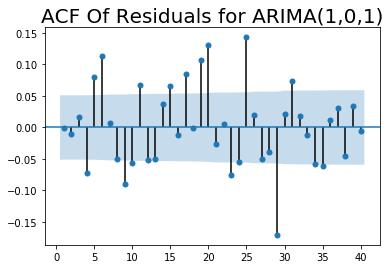

In [123]:
## Residuals of the ARIMA(1,0,1)

df['res_ar_1_i_0_ma_1'] = results_ar_1_i_0_ma_1.resid
sgt.plot_acf(df.res_ar_1_i_0_ma_1, zero = False, lags = 40)
plt.title("ACF Of Residuals for ARIMA(1,0,1)",size=20)
plt.show()

In [127]:
model_ar_6_i_0_ma_6 = ARIMA(df.Cierre, order=(6,0,6))
results_ar_6_i_0_ma_6 = model_ar_6_i_0_ma_6.fit()

model_ar_6_i_0_ma_5 = ARIMA(df.Cierre, order=(6,0,5))
results_ar_6_i_0_ma_5 = model_ar_6_i_0_ma_5.fit()

model_ar_5_i_0_ma_6 = ARIMA(df.Cierre, order=(5,0,6))
results_ar_5_i_0_ma_6 = model_ar_5_i_0_ma_6.fit()

model_ar_6_i_1_ma_4 = ARIMA(df.Cierre, order=(6,1,4))
results_ar_6_i_1_ma_4 = model_ar_6_i_1_ma_4.fit()

model_ar_4_i_1_ma_6 = ARIMA(df.Cierre, order=(4,1,6))
results_ar_4_i_1_ma_6 = model_ar_4_i_1_ma_6.fit()

model_ar_6_i_0_ma_3 = ARIMA(df.Cierre, order=(6,0,3))
results_ar_6_i_0_ma_3 = model_ar_6_i_0_ma_3.fit()

model_ar_3_i_0_ma_6 = ARIMA(df.Cierre, order=(3,0,6))
results_ar_3_i_0_ma_6 = model_ar_3_i_0_ma_6.fit()

model_ar_6_i_0_ma_2 = ARIMA(df.Cierre, order=(6,0,2))
results_ar_6_i_0_ma_2 = model_ar_6_i_0_ma_2.fit()

model_ar_2_i_0_ma_6 = ARIMA(df.Cierre, order=(2,0,6))
results_ar_2_i_0_ma_6 = model_ar_2_i_0_ma_6.fit()

model_ar_6_i_0_ma_1 = ARIMA(df.Cierre, order=(6,0,1))
results_ar_6_i_0_ma_1 = model_ar_6_i_0_ma_1.fit()

model_ar_1_i_0_ma_6 = ARIMA(df.Cierre, order=(1,0,6))
results_ar_1_i_0_ma_6 = model_ar_1_i_0_ma_6.fit()

# Testing in another time window2

In [624]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7
aux_df = pd.DataFrame({"Real_value": df_test['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7,2)} \
                        , index = df_test['Cierre'][0:7].index)
df_predictions = aux_df.copy()
df_predictions

,Real_value,Forecast
Fecha,,
2020-03-23,136.48,122.19
2020-03-24,138.84,134.74
2020-03-25,136.16,141.98
2020-03-26,138.74,140.96
2020-03-27,130.97,133.92
2020-03-28,131.11,127.14
2020-03-29,124.73,121.71


In [431]:
# Splitting data in training and testing
size2 = int(len(df_comp)*0.95)
df2, df_test2 = df_comp.iloc[:size2], df_comp.iloc[size2:]

In [432]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df2.Cierre)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

There isn't enough proves to reject that data isn't stationary with a 0.99% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.95% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.90% of confidence


## Trasnforming non-stationary data into stationary data

In [433]:
x2 = df2.Cierre.values

# Regarding 1 ordered differenced time serie
differenced2 = difference(x2, 1)

In [434]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(differenced2)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


In [435]:
# Let's take a quick look
differenced

array([  0.2 ,   0.97,   2.15, ...,  -3.06,  -0.6 , -10.35])

In [436]:
print(len(df2.Cierre))
print(len(differenced2))

1556
1555


In [438]:
model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2 = SARIMAX(differenced2, order=(5,0,5), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2 = model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2.fit()

In [439]:
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1555
Model:             SARIMAX(5, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -6869.483
Date:                             Wed, 07 Oct 2020   AIC                          13766.967
Time:                                     18:44:34   BIC                          13841.856
Sample:                                          0   HQIC                         13794.815
                                            - 1555                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3736      0.019     73.215      0.000       1.337       1.410
ar.L2         -0.7253      0.041    -17.584      0.000      -0.806      -0.644
ar.L3         -0.5567      0.055    -10.202      0.000      -0.664      -0.450
ar.L4          1.2532      0.046     27.079      0.000       1.163       1.344
ar.L5         -0.8395      0.026    -32.564      0.000      -0.890      -0.789
ma.L1         -1.3495      0.015    -89.325      0.000      -1.379      -1.320
ma.L2          0.6875      0.034     20.487      0.000       0.622       0.753
ma.L3          0.6126      0.042     14.606      0.000       0.530       0.695
ma.L4         -1.2697      0.035    -36.144      0.000      -1.339      -1.201
ma.L5          0.9180      0.019     49.057      0.000       0.881       0.955
ar.S.L7       -0.8013      0.039    -20.404      0.000      -0.878      -0.724
ar.S.L14       0.0791      0.013      6.185      0.000       0.054       0.104
ma.S.L7        0.7977      0.043     18.345      0.000       0.712       0.883
sigma2       408.7654      5.545     73.718      0.000     397.897     419.633
===================================================================================
Ljung-Box (Q):                      139.15   Jarque-Bera (JB):             37694.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

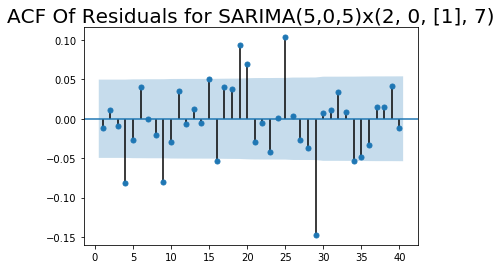

In [442]:
df2['res_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2'] = np.concatenate(([0], results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2.resid))
sgt.plot_acf(df2.res_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,5)x(2, 0, [1], 7)",size=20)
plt.show()

In [443]:
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window2 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window2.forecast(7) 
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window2

array([ 4.35453638, -1.78915924, -1.27444264,  0.96290547,  3.16772682,
        0.05970051, -3.32629102])

In [444]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window2 = inverse_difference(df2.Cierre, forecast_sarima_5_0_5_ar2_i0_ma1_m7_window2, interval = 1)
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window2

array([242.00453638, 240.21537714, 238.9409345 , 239.90383997,
       243.07156679, 243.1312673 , 239.80497628])

In [445]:
sqrt(mean_squared_error(df_test2['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window2))

8.309998956711354

In [625]:
aux_df = pd.DataFrame({"Real_value": df_test2['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window2,2)} \
                        , index = df_test2['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-06-13,238.48,242.00
2020-06-14,231.95,240.22
2020-06-15,231.13,238.94
2020-06-16,235.69,239.90
2020-06-17,234.23,243.07
2020-06-18,231.69,243.13
2020-06-19,229.09,239.80


In [629]:
# Let's append the predictions to to the predicitions data frame
df_predictions = df_predictions.append(aux_df)

In [595]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(2,0,1,7)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [464]:
(predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window2).astype('float')

array([242.00453638, 240.21537714, 238.9409345 , 239.90383997,
       243.07156679, 243.1312673 , 239.80497628])

In [465]:
pd.DataFrame({"Real_value": df_test2['Cierre'][0:7].values, "Forecast": predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window2})

,Real_value,Forecast
0,238.48,242.004536
1,231.95,240.215377
2,231.13,238.940934
3,235.69,239.903840
4,234.23,243.071567
5,231.69,243.131267
6,229.09,239.804976


In [466]:
model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window2 = SARIMAX(differenced2, order=(5,0,5), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window2 = model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window2.fit()

In [467]:
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window2 = results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window2.forecast(7) 
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window2

array([ 3.20340118, -1.56598751, -0.17999602,  0.84617386,  1.13960416,
        0.32536596, -3.19396356])

In [468]:
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window2 = inverse_difference(df2.Cierre, forecast_sarima_5_0_5_ar1_i0_ma1_m7_window2, interval = 1)
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window2

array([240.85340118, 239.28741367, 239.10741765, 239.95359151,
       241.09319568, 241.41856164, 238.22459808])

In [469]:
sqrt(mean_squared_error(df_test2['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window2))

7.235599748673367

In [596]:
aux_df = pd.DataFrame({"Real_value": df_test2['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window2,2)} \
                        , index = df_test2['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-06-13,238.48,240.85
2020-06-14,231.95,239.29
2020-06-15,231.13,239.11
2020-06-16,235.69,239.95
2020-06-17,234.23,241.09
2020-06-18,231.69,241.42
2020-06-19,229.09,238.22


In [598]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7) time window 2',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

# Testing in another time window3

In [471]:
# Splitting data in training and testing
size3 = int(len(df_comp)*0.97)
df3, df_test3 = df_comp.iloc[:size3], df_comp.iloc[size3:]

In [472]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df3.Cierre)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

There isn't enough proves to reject that data isn't stationary with a 0.99% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.95% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.90% of confidence


## Trasnforming non-stationary data into stationary data

In [473]:
x3 = df3.Cierre.values

# Regarding 1 ordered differenced time serie
differenced3 = difference(x3, 1)

In [474]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(differenced3)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


In [475]:
# Let's take a quick look
differenced3

array([ 0.2 ,  0.97,  2.15, ...,  3.61, -3.16,  0.64])

In [476]:
print(len(df3.Cierre))
print(len(differenced3))

1588
1587


In [484]:
model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3 = SARIMAX(differenced3, order=(5,0,5), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3 = model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3.fit()

In [485]:
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1587
Model:             SARIMAX(5, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -6995.307
Date:                             Wed, 07 Oct 2020   AIC                          14018.615
Time:                                     19:45:59   BIC                          14093.789
Sample:                                          0   HQIC                         14046.541
                                            - 1587                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3821      0.015     91.487      0.000       1.352       1.412
ar.L2         -0.7437      0.030    -24.409      0.000      -0.803      -0.684
ar.L3         -0.5327      0.040    -13.202      0.000      -0.612      -0.454
ar.L4          1.2337      0.035     34.858      0.000       1.164       1.303
ar.L5         -0.8355      0.021    -39.099      0.000      -0.877      -0.794
ma.L1         -1.3543      0.011   -119.320      0.000      -1.376      -1.332
ma.L2          0.6908      0.023     30.366      0.000       0.646       0.735
ma.L3          0.6172      0.028     22.221      0.000       0.563       0.672
ma.L4         -1.2793      0.024    -53.141      0.000      -1.326      -1.232
ma.L5          0.9284      0.014     66.265      0.000       0.901       0.956
ar.S.L7       -0.8023      0.036    -22.154      0.000      -0.873      -0.731
ar.S.L14       0.0805      0.013      6.304      0.000       0.055       0.106
ma.S.L7        0.7863      0.040     19.422      0.000       0.707       0.866
sigma2       400.8596      5.348     74.957      0.000     390.378     411.341
===================================================================================
Ljung-Box (Q):                      140.82   Jarque-Bera (JB):             38331.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

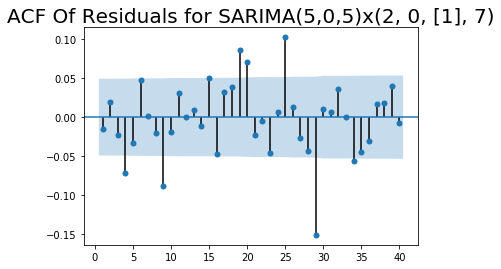

In [486]:
df3['res_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3'] = np.concatenate(([0], results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3.resid))
sgt.plot_acf(df3.res_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,5)x(2, 0, [1], 7)",size=20)
plt.show()

In [487]:
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window3 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window3.forecast(7) 
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window3

array([-3.56512736, -2.87718457,  1.97695756, -2.27339634, -3.12801718,
       -1.61830292,  3.9227098 ])

In [488]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window3 = inverse_difference(df3.Cierre, forecast_sarima_5_0_5_ar2_i0_ma1_m7_window3, interval = 1)
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window3

array([236.99487264, 234.11768808, 236.09464564, 233.8212493 ,
       230.69323212, 229.0749292 , 232.99763901])

In [496]:
sqrt(mean_squared_error(df_test3['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window3))

6.761737161844488

In [738]:
aux_df = pd.DataFrame({"Real_value": df_test3['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window3,2)} \
                        , index = df_test3['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-07-15,238.94,236.99
2020-07-16,233.96,234.12
2020-07-17,233.18,236.09
2020-07-18,236.19,233.82
2020-07-19,239.58,230.69
2020-07-20,236.43,229.07
2020-07-21,246.00,233.00


In [632]:
# Let's append the predictions to to the predicitions data frame
df_predictions = df_predictions.append(aux_df)

In [739]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Predictions",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(2,0,1,7) time window 3',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [492]:
pd.DataFrame({"Real_value": df_test3['Cierre'][0:7].values, "Forecast": predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window3})

,Real_value,Forecast
0,238.94,236.994873
1,233.96,234.117688
2,233.18,236.094646
3,236.19,233.821249
4,239.58,230.693232
5,236.43,229.074929
6,246.00,232.997639


In [493]:
model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window3 = SARIMAX(differenced3, order=(5,0,5), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window3 = model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window3.fit()

In [494]:
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window3 = results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window3.forecast(7) 
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window3

array([-2.90936067, -2.5193481 ,  1.41593831, -2.48471988, -2.4724149 ,
       -1.27103855,  3.26167246])

In [495]:
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window3 = inverse_difference(df3.Cierre, forecast_sarima_5_0_5_ar1_i0_ma1_m7_window3, interval = 1)
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window3

array([237.65063933, 235.13129123, 236.54722954, 234.06250966,
       231.59009476, 230.31905621, 233.58072867])

In [497]:
sqrt(mean_squared_error(df_test3['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window3))

6.2600701063742665

In [740]:
aux_df = pd.DataFrame({"Real_value": df_test3['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window3,2)} \
                        , index = df_test3['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-07-15,238.94,237.65
2020-07-16,233.96,235.13
2020-07-17,233.18,236.55
2020-07-18,236.19,234.06
2020-07-19,239.58,231.59
2020-07-20,236.43,230.32
2020-07-21,246.00,233.58


In [742]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Prediction",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7) time window 3',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

# Testing in another time window4

In [500]:
# Splitting data in training and testing
size4 = int(len(df_comp)*0.99)
df4, df_test4 = df_comp.iloc[:size4], df_comp.iloc[size4:]

In [501]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(df4.Cierre)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

There isn't enough proves to reject that data isn't stationary with a 0.99% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.95% of confidence
There isn't enough proves to reject that data isn't stationary with a 0.90% of confidence


## Transforming non-stationary data into stationary data

In [502]:
x4 = df4.Cierre.values

# Regarding 1 ordered differenced time serie
differenced4 = difference(x4, 1)

In [503]:
# Testing stationarity
test_statistic, p_value, used_lag, n_obs, critical_values, maximized_information_criterion = sts.adfuller(differenced4)

for k,v in critical_values.items():
    if test_statistic < v:
        print("Data is stationary with a %.2f%% of confidence" % (1-(float(k.rstrip('%')))/100))
    else:
        print("There isn't enough proves to reject that data isn't stationary with a %.2f%% of confidence"% (1-(float(k.rstrip('%')))/100))

Data is stationary with a 0.99% of confidence
Data is stationary with a 0.95% of confidence
Data is stationary with a 0.90% of confidence


In [504]:
# Let's take a quick look
differenced4

array([ 0.2 ,  0.97,  2.15, ..., 13.14, -5.35,  1.39])

In [505]:
print(len(df4.Cierre))
print(len(differenced4))

1621
1620


In [506]:
model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4 = SARIMAX(differenced4, order=(5,0,5), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4 = model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4.fit()

In [507]:
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1620
Model:             SARIMAX(5, 0, 5)x(2, 0, [1], 7)   Log Likelihood               -7134.500
Date:                             Wed, 07 Oct 2020   AIC                          14297.000
Time:                                     19:57:25   BIC                          14372.463
Sample:                                          0   HQIC                         14325.004
                                            - 1620                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3768      0.019     73.851      0.000       1.340       1.413
ar.L2         -0.7260      0.040    -17.977      0.000      -0.805      -0.647
ar.L3         -0.5588      0.053    -10.491      0.000      -0.663      -0.454
ar.L4          1.2561      0.046     27.504      0.000       1.167       1.346
ar.L5         -0.8482      0.026    -33.030      0.000      -0.899      -0.798
ma.L1         -1.3474      0.015    -88.923      0.000      -1.377      -1.318
ma.L2          0.6886      0.033     21.154      0.000       0.625       0.752
ma.L3          0.6125      0.041     15.073      0.000       0.533       0.692
ma.L4         -1.2719      0.035    -36.784      0.000      -1.340      -1.204
ma.L5          0.9187      0.019     48.613      0.000       0.882       0.956
ar.S.L7       -0.8059      0.042    -18.988      0.000      -0.889      -0.723
ar.S.L14       0.0724      0.012      5.914      0.000       0.048       0.096
ma.S.L7        0.8085      0.046     17.428      0.000       0.718       0.899
sigma2       400.0960      5.359     74.666      0.000     389.593     410.598
===================================================================================
Ljung-Box (Q):                      146.08   Jarque-Bera (JB):             41411.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.52   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

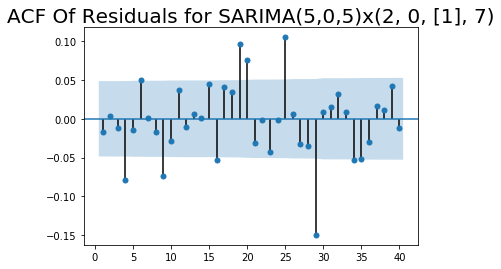

In [508]:
df4['res_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4'] = np.concatenate(([0], results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4.resid))
sgt.plot_acf(df4.res_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for SARIMA(5,0,5)x(2, 0, [1], 7)",size=20)
plt.show()

In [509]:
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window4 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window4.forecast(7) 
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window4

array([ 1.01571134,  1.72200904,  7.64041134,  8.77134326,  3.94743084,
       -1.85329373, -4.32178763])

In [510]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window4 = inverse_difference(df4.Cierre, forecast_sarima_5_0_5_ar2_i0_ma1_m7_window4, interval = 1)
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window4

array([435.33571134, 437.05772038, 444.69813172, 453.46947498,
       457.41690582, 455.5636121 , 451.24182447])

In [511]:
sqrt(mean_squared_error(df_test4['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window4))

46.121583104913576

In [743]:
aux_df = pd.DataFrame({"Real_value": df_test4['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window4,2)} \
                        , index = df_test4['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-08-17,431.39,435.34
2020-08-18,422.20,437.06
2020-08-19,408.67,444.70
2020-08-20,416.79,453.47
2020-08-21,387.83,457.42
2020-08-22,395.85,455.56
2020-08-23,391.22,451.24


In [634]:
# Let's append the predictions to to the predicitions data frame
df_predictions = df_predictions.append(aux_df)

In [744]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Prediction",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(2,0,1,7) time window 4',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [513]:
pd.DataFrame({"Real_value": df_test4['Cierre'][0:7].values, "Forecast": predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window4})

,Real_value,Forecast
0,431.39,435.335711
1,422.20,437.057720
2,408.67,444.698132
3,416.79,453.469475
4,387.83,457.416906
5,395.85,455.563612
6,391.22,451.241824


In [514]:
model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window4 = SARIMAX(differenced4, order=(5,0,5), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window4 = model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window4.fit()

In [515]:
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window4 = results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window4.forecast(7) 
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window4

array([ 0.05303075,  4.42469037,  9.11671012,  6.41453202,  2.81023429,
       -1.41323016, -2.98747602])

In [516]:
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window4 = inverse_difference(df4.Cierre, forecast_sarima_5_0_5_ar1_i0_ma1_m7_window4, interval = 1)
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window4

array([434.37303075, 438.79772112, 447.91443124, 454.32896327,
       457.13919756, 455.7259674 , 452.73849138])

In [517]:
sqrt(mean_squared_error(df_test4['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window4))

46.91497337166248

In [745]:
aux_df = pd.DataFrame({"Real_value": df_test4['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window4,2)} \
                        , index = df_test4['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-08-17,431.39,434.37
2020-08-18,422.20,438.80
2020-08-19,408.67,447.91
2020-08-20,416.79,454.33
2020-08-21,387.83,457.14
2020-08-22,395.85,455.73
2020-08-23,391.22,452.74


In [747]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Prediction",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7) time window 4',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

# Testing in another time window6

In [661]:
# Splitting data in training and testing
size6 = int(len(df_comp)*0.82)
df6, df_test6 = df_comp.iloc[:size6], df_comp.iloc[size6:]

## Transforming non-stationary data into stationary data

In [656]:
x6 = df6.Cierre.values

# Regarding 1 ordered differenced time serie
differenced6 = difference(x6, 1)

In [657]:
model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window6 = SARIMAX(differenced6, order=(5,0,5), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window6 = model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window6.fit()

In [658]:
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window6 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window6.forecast(7) 
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window6

array([-0.17611377, -0.42215046,  0.76136457, -1.19397368, -1.66943826,
       -3.28585834, -1.12185857])

In [659]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window6 = inverse_difference(df6.Cierre, forecast_sarima_5_0_5_ar2_i0_ma1_m7_window6, interval = 1)
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window6

array([187.16388623, 186.74173578, 187.50310035, 186.30912667,
       184.63968842, 181.35383008, 180.23197151])

In [662]:
sqrt(mean_squared_error(df_test6['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window6))

3.604192758845844

In [663]:
aux_df = pd.DataFrame({"Real_value": df_test6['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window6,2)} \
                        , index = df_test6['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2019-11-13,188.69,187.16
2019-11-14,185.00,186.74
2019-11-15,180.27,187.50
2019-11-16,182.97,186.31
2019-11-17,184.53,184.64
2019-11-18,178.55,181.35
2019-11-19,176.46,180.23


In [664]:
# Let's append the predictions to to the predicitions data frame
df_predictions = df_predictions.append(aux_df)

In [666]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(2,0,1,7) time window 6',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [667]:
model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window6 = SARIMAX(differenced6, order=(5,0,5), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window6 = model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window6.fit()

In [668]:
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window6 = results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window6.forecast(7) 
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window6

array([ 0.3757093 , -0.55741729,  1.35948479, -1.58013766, -1.29714649,
       -2.5210187 , -0.87268816])

In [669]:
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window6 = inverse_difference(df6.Cierre, forecast_sarima_5_0_5_ar1_i0_ma1_m7_window6, interval = 1)
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window6

array([187.7157093 , 187.15829201, 188.5177768 , 186.93763914,
       185.64049265, 183.11947395, 182.24678579])

In [670]:
sqrt(mean_squared_error(df_test6['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window6))

4.550912389348318

In [671]:
aux_df = pd.DataFrame({"Real_value": df_test6['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window6,2)} \
                        , index = df_test6['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2019-11-13,188.69,187.72
2019-11-14,185.00,187.16
2019-11-15,180.27,188.52
2019-11-16,182.97,186.94
2019-11-17,184.53,185.64
2019-11-18,178.55,183.12
2019-11-19,176.46,182.25


In [672]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7) time window 6',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

# Testing in another time window7

In [673]:
# Splitting data in training and testing
size7 = int(len(df_comp)*0.84)
df7, df_test7 = df_comp.iloc[:size7], df_comp.iloc[size7:]

## Transforming non-stationary data into stationary data

In [674]:
x7 = df7.Cierre.values

# Regarding 1 ordered differenced time serie
differenced7 = difference(x7, 1)

In [675]:
model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window7 = SARIMAX(differenced7, order=(5,0,5), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window7 = model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window7.fit()

In [676]:
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window7 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window7.forecast(7) 
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window7

array([ 1.28681843,  0.17240205, -0.39445246,  1.05471033,  0.67016502,
        0.47410365, -0.3089407 ])

In [677]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window7 = inverse_difference(df7.Cierre, forecast_sarima_5_0_5_ar2_i0_ma1_m7_window7, interval = 1)
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window7

array([143.84681843, 144.01922048, 143.62476803, 144.67947835,
       145.34964337, 145.82374703, 145.51480633])

In [678]:
sqrt(mean_squared_error(df_test7['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window7))

14.936280980138848

In [679]:
aux_df = pd.DataFrame({"Real_value": df_test7['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window7,2)} \
                        , index = df_test7['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2019-12-15,143.11,143.85
2019-12-16,133.34,144.02
2019-12-17,122.81,143.62
2019-12-18,133.50,144.68
2019-12-19,128.68,145.35
2019-12-20,128.90,145.82
2019-12-21,127.50,145.51


In [680]:
# Let's append the predictions to to the predicitions data frame
df_predictions = df_predictions.append(aux_df)

In [681]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(2,0,1,7) time window 7',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [682]:
model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window7 = SARIMAX(differenced7, order=(5,0,5), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window7 = model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window7.fit()

In [683]:
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window7 = results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window7.forecast(7) 
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window7

array([ 0.27773531,  0.14489102,  0.14644905,  1.61225657,  0.19099891,
       -0.31184357, -0.43369261])

In [684]:
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window7 = inverse_difference(df7.Cierre, forecast_sarima_5_0_5_ar1_i0_ma1_m7_window7, interval = 1)
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window7

array([142.83773531, 142.98262633, 143.12907538, 144.74133195,
       144.93233086, 144.62048729, 144.18679468])

In [685]:
sqrt(mean_squared_error(df_test7['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window7))

14.25285853294801

In [687]:
aux_df = pd.DataFrame({"Real_value": df_test7['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window7,2)} \
                        , index = df_test7['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2019-12-15,143.11,142.84
2019-12-16,133.34,142.98
2019-12-17,122.81,143.13
2019-12-18,133.50,144.74
2019-12-19,128.68,144.93
2019-12-20,128.90,144.62
2019-12-21,127.50,144.19


In [688]:
aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7) time window 7',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

# Testing in specific time period

In [689]:
df_comp.tail(30) #tomaremos el 27 para ver que pasa

,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
Fecha,,,,,,
2020-08-04,389.68,385.68,398.09,383.30,121240.0,0.0104
2020-08-05,400.85,389.60,400.85,387.73,109150.0,0.0287
2020-08-06,394.70,400.85,400.85,394.01,55050.0,-0.0153
2020-08-07,379.03,394.70,397.78,370.51,158000.0,-0.0397
2020-08-08,396.88,379.03,396.88,378.36,43670.0,0.0471
2020-08-09,390.06,396.88,399.62,386.09,60890.0,-0.0172
2020-08-10,395.87,390.06,398.21,390.06,79050.0,0.0149
2020-08-11,378.95,395.87,397.91,372.25,95790.0,-0.0427
2020-08-12,388.75,378.95,388.75,370.33,77700.0,0.0259


In [690]:
# Splitting data in training and testing
# size4 = int(len(df_comp)*0.99)
df8, df_test8 = df_comp.iloc[:-27], df_comp.iloc[-27:]
df8.tail()

,Cierre,Apertura,Máximo,Mínimo,Vol.,% var.
Fecha,,,,,,
2020-08-02,371.60,387.04,396.95,361.91,322410.0,-0.0399
2020-08-03,385.68,371.64,397.00,371.64,126900.0,0.0379
2020-08-04,389.68,385.68,398.09,383.30,121240.0,0.0104
2020-08-05,400.85,389.60,400.85,387.73,109150.0,0.0287
2020-08-06,394.70,400.85,400.85,394.01,55050.0,-0.0153


## Transforming non-stationary data into stationary data

In [693]:
x8 = df8.Cierre.values

# Regarding 1 ordered differenced time serie
differenced8 = difference(x8, 1)

In [694]:
model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window8 = SARIMAX(differenced8, order=(5,0,5), seasonal_order = (2,0,1,7))
results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window8 = model_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window8.fit()

In [695]:
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window8 = results_sar_5_i_0_ma_5_ar2_i0_ma1_m7_window8.forecast(7) 
forecast_sarima_5_0_5_ar2_i0_ma1_m7_window8

array([ 2.15568411,  1.12717373, -2.20762875,  4.69447776,  0.99058638,
       -2.19489529, -8.04301188])

In [696]:
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window8 = inverse_difference(df8.Cierre, forecast_sarima_5_0_5_ar2_i0_ma1_m7_window8, interval = 1)
predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window8

array([396.85568411, 397.98285784, 395.7752291 , 400.46970686,
       401.46029324, 399.26539795, 391.22238607])

In [697]:
sqrt(mean_squared_error(df_test8['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window8))

17.48666384455255

In [698]:
aux_df = pd.DataFrame({"Real_value": df_test8['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar2_i0_ma1_m7_window8,2)} \
                        , index = df_test8['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-08-07,379.03,396.86
2020-08-08,396.88,397.98
2020-08-09,390.06,395.78
2020-08-10,395.87,400.47
2020-08-11,378.95,401.46
2020-08-12,388.75,399.27
2020-08-13,425.14,391.22


In [699]:
# Let's append the predictions to to the predicitions data frame
df_predictions = df_predictions.append(aux_df)

In [700]:
import plotly.graph_objects as go

aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(2,0,1,7) specific window',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [701]:
model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window8 = SARIMAX(differenced8, order=(5,0,5), seasonal_order = (1,0,1,7))
results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window8 = model_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window8.fit()

In [702]:
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window8 = results_sar_5_i_0_ma_5_ar1_i0_ma1_m7_window8.forecast(7) 
forecast_sarima_5_0_5_ar1_i0_ma1_m7_window8

array([ 1.44796905, -0.23308328, -1.03559691,  3.91084146,  0.08899889,
       -2.29484902, -7.39286458])

In [703]:
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window8 = inverse_difference(df8.Cierre, forecast_sarima_5_0_5_ar1_i0_ma1_m7_window8, interval = 1)
predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window8

array([396.14796905, 395.91488577, 394.87928887, 398.79013033,
       398.87912921, 396.58428019, 389.19141561])

In [704]:
sqrt(mean_squared_error(df_test8['Cierre'][0:7].values, predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window8))

17.22355477320237

In [705]:
aux_df = pd.DataFrame({"Real_value": df_test8['Cierre'][0:7].values, \
                       "Forecast": np.round(predicitions_sarima_5_0_5_ar1_i0_ma1_m7_window8,2)} \
                        , index = df_test8['Cierre'][0:7].index)
aux_df

,Real_value,Forecast
Fecha,,
2020-08-07,379.03,396.15
2020-08-08,396.88,395.91
2020-08-09,390.06,394.88
2020-08-10,395.87,398.79
2020-08-11,378.95,398.88
2020-08-12,388.75,396.58
2020-08-13,425.14,389.19


In [706]:
import plotly.graph_objects as go

aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7) specific window',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

# Analysis of $\mu$ of the errors in predictions

In [710]:
from math import fabs
df_predictions['error'] = df_predictions['Forecast'] - df_predictions['Real_value']
df_predictions['error'] = df_predictions['error'].apply(lambda x: fabs(x))
df_predictions.head()

,Real_value,Forecast,error
Fecha,,,
2020-03-23,136.48,122.19,14.29
2020-03-24,138.84,134.74,4.10
2020-03-25,136.16,141.98,5.82
2020-03-26,138.74,140.96,2.22
2020-03-27,130.97,133.92,2.95


## Looking for a confidence interval  of $\mu$ for the errors based on the sample of the different time windows.

We must remeber that for accomplish a value $\mu$ of anormal population, the key is the random variable $\frac{\overline{X}-\mu} {\sigma \sqrt{n}}$.The main problem is that we couldn't use it since we don't know $\sigma$.

What we are going to do is to replace the population standard deviation $\sigma$ with the sample standard deviation $\tilde{S_X}$ obtaining: $\frac{\overline{X}-\mu}{\frac{\tilde{S_X}}{\sqrt{n}}}$, where $\overline{X}$ is the sample mean and n the sample size.

The distribution of the former variable $\frac{\overline{X}-\mu}{\frac{\tilde{S_X}}{\sqrt{n}}}$, won't follow a normal, otherwise $t$ - Student with $n-1$ degrees of freedom as the following theorem tells us:

**Theorem:** Let $X \sim N(\mu, \sigma)$. Let $X_1,....,X_n$ a s.r.s. of $X$, with mean $\overline{X}$ sample standard deviation $\tilde{S_X}$. In this conditions, random variable $t = \frac{\overline{X}-\mu}{\frac{\tilde{S_X}}{\sqrt{n}}}$, follows t-Student distribution with $n-1$ degrees of freedom, $t_{n-1}$.

Consider the next situation: 
* $X$ a normal random variable with $\mu$ and $\sigma$ unknown.
* $X_1,.....,X_n$ as s.r.s of $X$ of size $n$ with mean $\overline{X}$ and sample variance $\tilde{S_X}$

**Confidence interval for the parameter $\mu$**. Under these conditions, a confidence interval of ($1-\alpha$)% $\cdot 100$% for the parameter $\mu$ of a normal population with $\sigma$ unknown and n any is
$$(\overline{X}-t_{n-1,1-\frac{\alpha}{2}}\frac{\tilde{S_X}}{\sqrt{n}},\overline{X}+t_{n-1,1-\frac{\alpha}{2}}\frac{\tilde{S_X}}{\sqrt{n}})$$

***Whether n is big ($n \geq 40$)***
Under this conditions, whether $n$ is enough big $t_{n-1,1-\frac{\alpha}{2}} \approx Z_{1-\frac{\alpha}{2}}$ considering the **Central Limit Theorem** $\frac{\overline{X}-{\mu}}{\frac{\sigma}{\sqrt{n}}} \approx N(0,1)$, we could approach the fomer confidence interval by: 
$$(\overline{X}-z_{1-\frac{\alpha}{2}}\frac{\tilde{S_X}}{\sqrt{n}},\overline{X}+z_{1-\frac{\alpha}{2}}\frac{\tilde{S_X}}{\sqrt{n}})$$

In [727]:
vals = df_predictions['error']
n = len(vals)
x_overline = vals.mean()
sd_aux = []
for i in df_predictions['error']:
    sd_aux.append((i-x_overline)**2)
sd = sqrt(sum(sd_aux)/(n-1))

alpha = 0.05
z_critical = stats.norm.ppf(q = 1-alpha/2)

In [729]:
x_overline

13.364999999999997

In [731]:
ci = (x_overline-z_critical*(sd/sqrt(n)), x_overline+z_critical*(sd/sqrt(n)))
ci

(9.43477804575349, 17.295221954246504)

# Auto Arima

In [750]:
from pmdarima.arima import auto_arima

model_auto = auto_arima(differenced, m = 7, exogenous = df[['Máximo','Mínimo','% var.']][1:], max_order = None, start_p = 0, start_q = 0,
                        max_p = 9, max_q = 9, max_d = 1, max_P = 2, max_Q = 2, max_D = 1,
                        maxiter = 50, alpha = .05, n_jobs=-1, trend = 'ct', information_criterion = 'oob',
                        out_of_sample_size = int(len(differenced) * .2))

In [427]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                 1473
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -6129.281
Date:                   Thu, 03 Sep 2020   AIC                          12274.561
Time:                           13:02:49   BIC                          12316.922
Sample:                                0   HQIC                         12290.356
                                  - 1473                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.2486      2.055     -0.608      0.543      -5.276       2.779
drift         -0.0028      0.004     -0.719      0.472      -0.010       0.005
x1            -0.1652      0.006    -28.844      0.000      -0.176      -0.154
x2             0.1860      0.007     27.160      0.000       0.173       0.199
x3           242.9146      3.727     65.185      0.000     235.611     250.218
ar.S.L7       -0.9319      0.053    -17.740      0.000      -1.035      -0.829
ma.S.L7        0.9050      0.057     15.813      0.000       0.793       1.017
sigma2       241.9864      3.708     65.267      0.000     234.720     249.253
===================================================================================
Ljung-Box (Q):                      247.75   Jarque-Bera (JB):             23945.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [428]:
model_auto.resid()

array([ -3.49268281, -18.10714675, -37.53340672, ...,   8.37677799,
         2.83798781,  11.64352288])

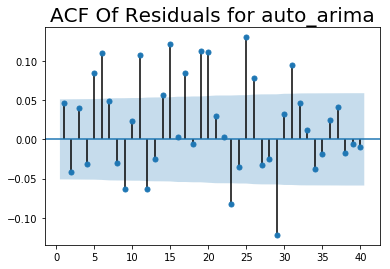

In [429]:
df['auto_arima'] = np.concatenate(([0], model_auto.resid()))
sgt.plot_acf(df.auto_arima[1:], zero = False, lags = 40)
plt.title("ACF Of Residuals for auto_arima",size=20)
plt.show()

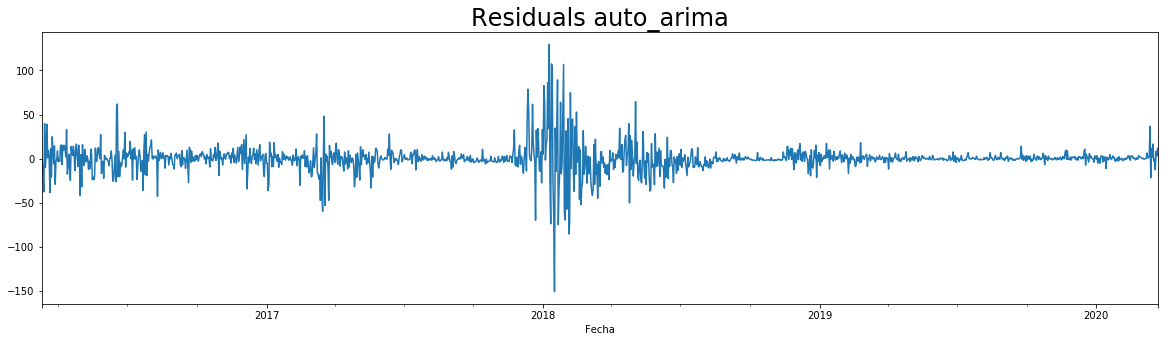

In [430]:
# Plotting residuals
df.auto_arima.plot(figsize = (20,5))
plt.title("Residuals auto_arima", size=24)
plt.show()

In [431]:
# Testing stationarity of residuals
sts.adfuller(df.auto_arima)

(-5.360591065868656,
 4.096294862675783e-06,
 24,
 1449,
 {'1%': -3.4348709954268384,
  '5%': -2.863536715724964,
  '10%': -2.567833035595811},
 11902.384415512544)

In [748]:
forecast = model_auto.predict(30, exogenous = df_test[['Máximo','Mínimo','% var.']][0:30])

In [749]:
forecast

array([-0.92974195, -0.74619024, -0.36823981, -2.59540786, -0.1846433 ,
       -0.76646681,  0.05147067, -0.02580943, -0.19603861, -0.54529601,
        1.50458666, -0.71675675, -0.18212648, -0.93658256, -0.86660306,
       -0.71102367, -0.39057124, -2.27956655, -0.23504798, -0.72859704,
       -0.0349837 , -0.10062046, -0.24508899, -0.54139458,  1.19705359,
       -0.68700173, -0.23366632, -0.87362818, -0.81437142, -0.68251586])

In [446]:
history = [y for y in x]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, 1)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1


Day 1: 146.539788
Day 2: 148.981763
Day 3: 142.717703
Day 4: 147.653601
Day 5: 131.297533
Day 6: 130.191021
Day 7: 116.603878
Day 8: 129.527098
Day 9: 130.231280
Day 10: 134.855362
Day 11: 140.539096
Day 12: 139.320215
Day 13: 143.103037
Day 14: 139.944078
Day 15: 183.492684
Day 16: 172.475561
Day 17: 183.602230
Day 18: 179.596334
Day 19: 159.491107
Day 20: 159.744750
Day 21: 158.414619
Day 22: 154.294672
Day 23: 156.382326
Day 24: 146.614039
Day 25: 172.382186
Day 26: 170.735126
Day 27: 191.792845
Day 28: 181.405175
Day 29: 165.087912
Day 30: 164.993841


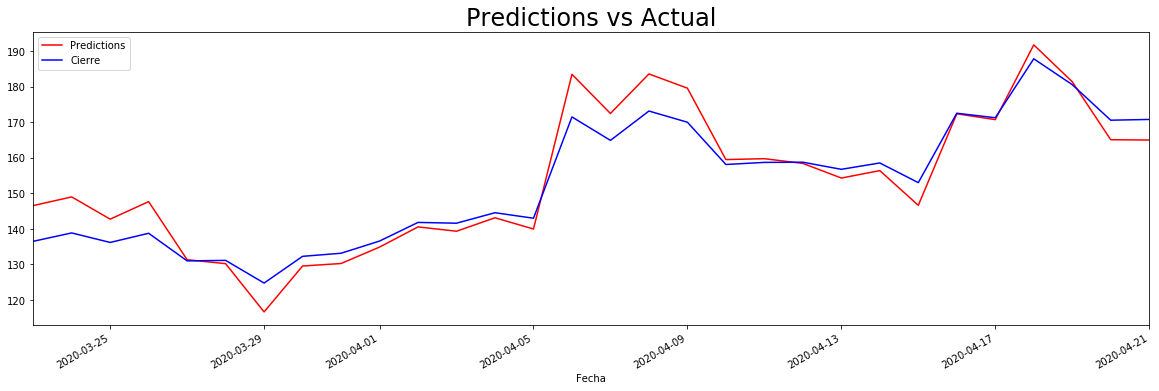

In [447]:
plt.figure(figsize=(20,6))
plt.plot(df_test['Cierre'][0:30].index, pd.Series(history)[-30:].values, color = "red", label="Predictions")
df_test['Cierre'][0:30].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

aux = aux_df.reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Real_value'],
                name="Real value",
                marker_color='rgb(55, 83, 109)',
                mode="lines+text",
                text=list(aux['Real_value']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(x=list(aux['Fecha']),
                y=aux['Forecast'],
                name="Forecast",
                marker_color='rgb(100, 53, 39)',
                mode="lines+text",
                text=list(aux['Forecast']),
                textposition="top center"
                ))
fig.add_trace(go.Scatter(
                name='Upper Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']+19,
                mode='lines',
                marker=dict(color="#444"),
                line=dict(width=0),
                showlegend=False
                ))
fig.add_trace(go.Scatter(
                name='Lower Bound',
                x=list(aux['Fecha']),
                y=aux['Forecast']-19,
                marker=dict(color="#444"),
                line=dict(width=0),
                mode='lines',
                fillcolor='rgba(68, 68, 68, 0.3)',
                fill='tonexty',
                showlegend=False
                ))
fig.update_layout(
    title='Predictions vs Actual SARIMA(5,0,5)x(1,0,1,7) specific window',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Price in dollars $',
        titlefont_size=16,
        tickfont_size=14,
    )
)
fig.show()

In [436]:
from sklearn.metrics import mean_squared_error

mean_squared_error(pd.Series(history)[-7:].values, df_test['Cierre'][0:7])

56.21372782270013